# Notebook for Grenville pmag compilation

In [4]:
import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cartopy.crs as ccrs
import cartopy
%config InlineBackend.figure_format='retina'

In [5]:
def plot_di(ax=None, dec=None, inc=None, di_block=None, color='k', marker='o', markersize=20, legend='no', label='', title=None, edge=None,alpha=1):
    X_down = []
    X_up = []
    Y_down = []
    Y_up = []
    color_down = []
    color_up = []
    if di_block is not None:
        di_lists = unpack_di_block(di_block)
        if len(di_lists) == 3:
            dec, inc, intensity = di_lists
        if len(di_lists) == 2:
            dec, inc = di_lists
    try:
        length = len(dec)
        for n in range(len(dec)):
            XY = pmag.dimap(dec[n], inc[n])
            if inc[n] >= 0:
                X_down.append(XY[0])
                Y_down.append(XY[1])
                if type(color) == list:
                    color_down.append(color[n])
                else:
                    color_down.append(color)
            else:
                X_up.append(XY[0])
                Y_up.append(XY[1])
                if type(color) == list:
                    color_up.append(color[n])
                else:
                    color_up.append(color)
    except:
        XY = pmag.dimap(dec, inc)
        if inc >= 0:
            X_down.append(XY[0])
            Y_down.append(XY[1])
            color_down.append(color)
        else:
            X_up.append(XY[0])
            Y_up.append(XY[1])
            color_up.append(color)

    if len(X_up) > 0:
        ax.scatter(X_up, Y_up, facecolors='none', edgecolors=color_up,
                    s=markersize, marker=marker, label=label,alpha=alpha)

    if len(X_down) > 0:
        ax.scatter(X_down, Y_down, facecolors=color_down, edgecolors=edge,
                    s=markersize, marker=marker, label=label,alpha=alpha)
    if legend == 'yes':
        ax.legend(loc=2)
    plt.tight_layout()
    if title != None:
        ax.set_title(title)

def plot_net(fig):
    ax = fig.add_subplot(121)
    ax.set_axis_off()
    Dcirc = np.arange(0, 361.)
    Icirc = np.zeros(361, 'f')
    Xcirc, Ycirc = [], []
    for k in range(361):
        XY = pmag.dimap(Dcirc[k], Icirc[k])
        Xcirc.append(XY[0])
        Ycirc.append(XY[1])
    ax.plot(Xcirc, Ycirc, 'k')

# put on the tick marks
    Xsym, Ysym = [], []
    for I in range(10, 100, 10):
        XY = pmag.dimap(0., I)
        Xsym.append(XY[0])
        Ysym.append(XY[1])
    ax.plot(Xsym, Ysym, 'k+')
    Xsym, Ysym = [], []
    for I in range(10, 90, 10):
        XY = pmag.dimap(90., I)
        Xsym.append(XY[0])
        Ysym.append(XY[1])
    ax.plot(Xsym, Ysym, 'k+')
    Xsym, Ysym = [], []
    for I in range(10, 90, 10):
        XY = pmag.dimap(180., I)
        Xsym.append(XY[0])
        Ysym.append(XY[1])
    ax.plot(Xsym, Ysym, 'k+')
    Xsym, Ysym = [], []
    for I in range(10, 90, 10):
        XY = pmag.dimap(270., I)
        Xsym.append(XY[0])
        Ysym.append(XY[1])
    ax.plot(Xsym, Ysym, 'k+')
    for D in range(0, 360, 10):
        Xtick, Ytick = [], []
        for I in range(4):
            XY = pmag.dimap(D, I)
            Xtick.append(XY[0])
            Ytick.append(XY[1])
        ax.plot(Xtick, Ytick, 'k')
    ax.axis("equal")
    ax.axis((-1.05, 1.05, -1.05, 1.05))
    return ax


def equi(map_axis, centerlon, centerlat, radius, color, alpha=1.0, outline=True, fill=False):
    
    glon1 = centerlon
    glat1 = centerlat
    X = []
    Y = []
    for azimuth in range(0, 360):
        glon2, glat2, baz = ipmag.shoot(glon1, glat1, azimuth, radius)
        X.append(glon2)
        Y.append(glat2)
    X.append(X[0])
    Y.append(Y[0])
    X = X[::-1]
    Y = Y[::-1]

    # for non-filled ellipses
    if fill==False:
        map_axis.plot(X, Y, color=color,
                 transform=ccrs.Geodetic(), alpha=alpha)

    # for filled ellipses
    else:
        XY = np.stack([X,Y],axis=1)
        if outline==True:
            circle_edge = Polygon(XY,
                                  edgecolor=color,facecolor='none',
                                  transform=ccrs.Geodetic())
            map_axis.add_patch(circle_edge)
        circle_face = Polygon(XY,
                              edgecolor='none',facecolor=color,alpha=alpha,
                              transform=ccrs.Geodetic())
        map_axis.add_patch(circle_face)
    return map_axis
        
def plot_poles(map_axis, plon, plat, A95, label='', color='k', edgecolor='k',
               marker='o', markersize=20, legend='no',outline=True,
               filled_pole=False, fill_color='k', fill_alpha=1.0):
    map_axis.scatter(plon, plat, marker=marker,
                     color=color, edgecolors=edgecolor, s=markersize,
                     label=label, zorder=101, transform=ccrs.PlateCarree())
    if filled_pole==False:
        if isinstance(color,str)==True:
            for n in range(0,len(A95)):
                A95_km = A95[n] * 111.32
                map_axis = equi(map_axis, plon[n], plat[n], A95_km, color)
        else:
            for n in range(0,len(A95)):
                A95_km = A95[n] * 111.32
                map_axis = equi(map_axis, plon[n], plat[n], A95_km, color[n])
    elif filled_pole==True:
        if isinstance(fill_color,str)==True:
            for n in range(0,len(A95)):
                A95_km = A95[n] * 111.32
                map_axis = equi(map_axis, plon[n], plat[n], A95_km, fill_color, alpha=fill_alpha, outline=outline, fill=True)
        else:
            for n in range(0,len(A95)):
                A95_km = A95[n] * 111.32
                map_axis = equi(map_axis, plon[n], plat[n], A95_km, fill_color[n], alpha=fill_alpha, outline=outline, fill=True)

    if legend == 'yes':
        plt.legend(loc=2)
    return map_axis

def plot_vgp(map_axis, vgp_lon=None, vgp_lat=None, di_block=None, label='', color='k', marker='o',
             edge='black', markersize=20, legend=False):
   
    if di_block != None:
        di_lists = unpack_di_block(di_block)
        if len(di_lists) == 3:
            vgp_lon, vgp_lat, intensity = di_lists
        if len(di_lists) == 2:
            vgp_lon, vgp_lat = di_lists
    map_axis.scatter(vgp_lon, vgp_lat, marker=marker, edgecolors=[edge],
                     s=markersize, color=color, label=label, zorder=100, transform=ccrs.PlateCarree())
    map_axis.set_global()
    if legend == True:
        plt.legend(loc=2)
    return map_axis
        
def make_orthographic_map(fig, central_longitude=0, central_latitude=0, figsize=(8, 8),
                          add_land=True, land_color='tan', land_edge_color='black',
                          add_ocean=False, ocean_color='lightblue', grid_lines=True,
                          lat_grid=[-80.,  -60.,  -30.,
                                    0.,   30.,   60., 80.],
                          lon_grid=[-180., -150., -120.,  -90.,  -60.,  -30.,    0.,   30.,   60., 90.,  120.,  150.,  180.]):

    # wrapper class to change the default resolution of the orthographic projection
    class LowerThresholdOrthographic(ccrs.Orthographic):
        @property
        def threshold(self):
            return 1e3
    map_projection = LowerThresholdOrthographic(
        central_longitude=central_longitude, central_latitude=central_latitude)
    ax = fig.add_subplot(122,projection=map_projection)
    ax.set_global()
    if add_ocean == True:
        ax.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor=ocean_color)
    if add_land == True:
        ax.add_feature(cartopy.feature.LAND, zorder=0,
                       facecolor=land_color, edgecolor=land_edge_color)
    if grid_lines == True:
        ax.gridlines(xlocs=lon_grid, ylocs=lat_grid, linewidth=1,
                     color='black', linestyle='dotted')
    return ax

def plot_dir_pole(dec, inc, plat, plon, figsize = (10,5), return_axis=False):
    fig = plt.figure(figsize = figsize)
    ax1 = plot_net(fig)
    ax2 = make_orthographic_map(fig, 180, 0)

    ax1 = plot_di(ax=ax1, dec=dec, inc=inc)
    ax2 = plot_vgp(ax2, plon, plat)
    if return_axis:
        return ax1, ax2
    
# only for A component
def vgp_calc(dataframe, site_lon='site_lon', site_lat='site_lat', dec_is='dec_is', inc_is='inc_is'):
    
    # calculate the paleolatitude/colatitude
    dataframe['paleolatitude'] = np.degrees(
        np.arctan(0.5 * np.tan(np.radians(dataframe[inc_is]))))
    dataframe['colatitude'] = 90 - dataframe['paleolatitude']
    # calculate the latitude of the pole
    dataframe['vgp_lat'] = np.degrees(np.arcsin(np.sin(np.radians(dataframe[site_lat])) *
                                                np.cos(np.radians(dataframe['colatitude'])) +
                                                np.cos(np.radians(dataframe[site_lat])) *
                                                np.sin(np.radians(dataframe['colatitude'])) *
                                                np.cos(np.radians(dataframe[dec_is]))))
    # calculate the longitudinal difference between the pole and the site
    # (beta)
    dataframe['beta'] = np.degrees(np.arcsin((np.sin(np.radians(dataframe['colatitude'])) *
                                              np.sin(np.radians(dataframe[dec_is])))/
                                             (np.cos(np.radians(dataframe['vgp_lat'])))))
    # generate a boolean array (mask) to use to distinguish between the two possibilities for pole longitude
    # and then calculate pole longitude using the site location and
    # calculated beta
    mask = np.cos(np.radians(dataframe['colatitude'])) > np.sin(
        np.radians(dataframe[site_lat])) * np.sin(np.radians(dataframe['vgp_lat']))
    dataframe['vgp_lon'] = np.where(mask, (dataframe[site_lon] + dataframe['beta']) %
                                    360., (dataframe[site_lon] + 180 - dataframe['beta']) % 360.)
    
    dataframe['plon'] = [(dataframe['vgp_lon'][i]+180)%360 if dataframe[inc_is][i] >0 else dataframe['vgp_lon'][i] for i in range(dataframe.shape[0])]
    dataframe['plat'] = [-dataframe['vgp_lat'][i] if dataframe[inc_is][i] >0 else dataframe['vgp_lat'][i] for i in range(dataframe.shape[0])]
    
    del dataframe['colatitude']
    del dataframe['beta']
    return(dataframe)

# Central Gneiss Belt
- McWilliams 1975
- Ueno 1975
- Alvarez 1998
- Hyodo 1993
- Alvarez 1998
- Halls 2015

## McWilliams 1975 Magnetawan gneiss

- This study demonstrate that the AR component carried by high temperature unblocking minerals (likely hematite and single-domian-like magnetite) do not pass a fold test.
- No site level data provided in the original publication. Here we compile the site-mean data reported. 
- Will filter out this site-mean data from the site-mean compilation

In [6]:
McWilliams1975a = pd.read_csv('../data/pmag_compilation/McWilliams1975a.csv')
McWilliams1975a

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples    lat    lon  dir_k  \
0   MT      302      -73            4             23  45.75 -79.67     51   

   vgp_lat  vgp_lon dir_comp_name  
0      -24      130            AR

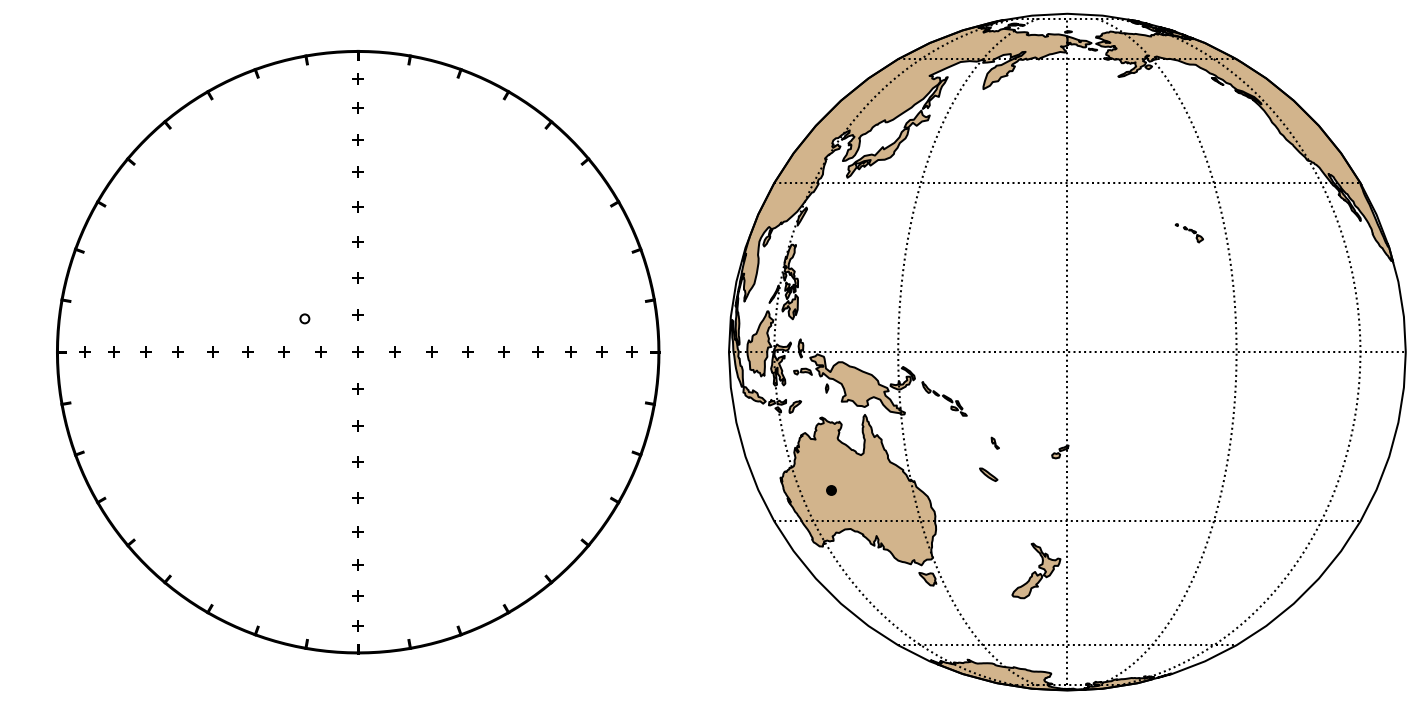

In [7]:
plot_dir_pole(McWilliams1975a['dir_dec'], McWilliams1975a['dir_inc'],
              McWilliams1975a['vgp_lat'], McWilliams1975a['vgp_lon'])

## Ueno 1975 Whitestone anorthosite and diorite

- The paper clearly show two components that needs to be classified by polarity instead of rock unit
- one AR direction and one AN direction
- The AR direction is exclusively carried by hematite and AN is single domain magnetite rods in plag of the anorthosite
- hemo-ilm is absolutely retrograde oxidation
- we compile the site directions and recalculate the mean direction and pole for AR and AN, respectively

In [8]:
Ueno1975a = pd.read_csv('../data/pmag_compilation/Ueno1975a.csv')
Ueno1975a = vgp_calc(Ueno1975a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Ueno1975a_AR = Ueno1975a[Ueno1975a['dir_comp_name']=='AR']
Ueno1975a_AN = Ueno1975a[Ueno1975a['dir_comp_name']=='AN']
Ueno1975a

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples    lat    lon  dir_r  \
0    4B      290      -59          8.9              5  45.66 -79.87   4.92   
1     9      296      -62         12.8              7  45.66 -79.87   6.65   
2    10      274      -54         10.4              5  45.66 -79.87   4.89   
3    11      272      -54          5.7              7  45.66 -79.87   6.93   
4    13      295      -49          7.0              5  45.66 -79.87   4.95   
5     2      108       41          6.3              5  45.66 -79.87   4.96   
6     3      110       36          7.0              4  45.66 -79.87   3.97   
7    4A      103       41         12.1              4  45.66 -79.87   3.91   
8     6      117       44          6.1              7  45.66 -79.87   6.92   
9     7      100       40         24.6              5  45.66 -79.87   4.38   
10   24      105       40         16.9              5  45.66 -79.87   4.71   
11   25       74       34         25.6              4  45.66 -79.87   3.60   
12   26      120       41         12.1              5  45.66 -79.87   4.85   
13   15      292      -62          4.0              4  45.66 -79.87   3.99   
14   16      286      -67          7.0              4  45.66 -79.87   3.97   
15   20      290      -71         12.8              3  45.66 -79.87   2.95   
16   21      298      -60          8.1              4  45.66 -79.87   3.96   

    dir_k    vgp_lat     vgp_lon dir_comp_name  paleolatitude        plon  \
0      50 -15.886346  148.806982            AR     -39.765187  148.806982   
1      17 -15.471087  142.925595            AR     -43.239577  142.925595   
2      36 -21.425947  162.109282            AR     -34.535397  162.109282   
3      86 -22.666542  163.278935            AR     -34.535397  163.278935   
4      80  -5.771046  152.280339            AR     -29.906833  152.280339   
5     100   4.992100  341.240263            AN      23.491856  161.240263   
6     100   1.118614  342.183896            AN      19.964629  162.183896   
7      33   8.100132  344.634115            AN      23.491856  164.634115   
8      75   1.446497  333.511624            AN      25.773313  153.511624   
9       6   9.484664  347.159708            AN      22.760476  167.159708   
10     14   6.309078  343.784827            AN      22.760476  163.784827   
11      8  24.274137    7.831993            AN      18.636898  187.831993   
12     27  -2.028645  332.761130            AN      23.491856  152.761130   
13    300 -17.410652  145.192779            AR     -43.239577  145.192779   
14    100 -24.869148  143.420440            AR     -49.670420  143.420440   
15     40 -26.966015  136.855754            AR     -55.446556  136.855754   
16     75 -12.719353  143.305604            AR     -40.893395  143.305604   

         plat  
0  -15.886346  
1  -15.471087  
2  -21.425947  
3  -22.666542  
4   -5.771046  
5   -4.992100  
6   -1.118614  
7   -8.100132  
8   -1.446497  
9   -9.484664  
10  -6.309078  
11 -24.274137  
12   2.028645  
13 -17.410652  
14 -24.869148  
15 -26.966015  
16 -12.719353

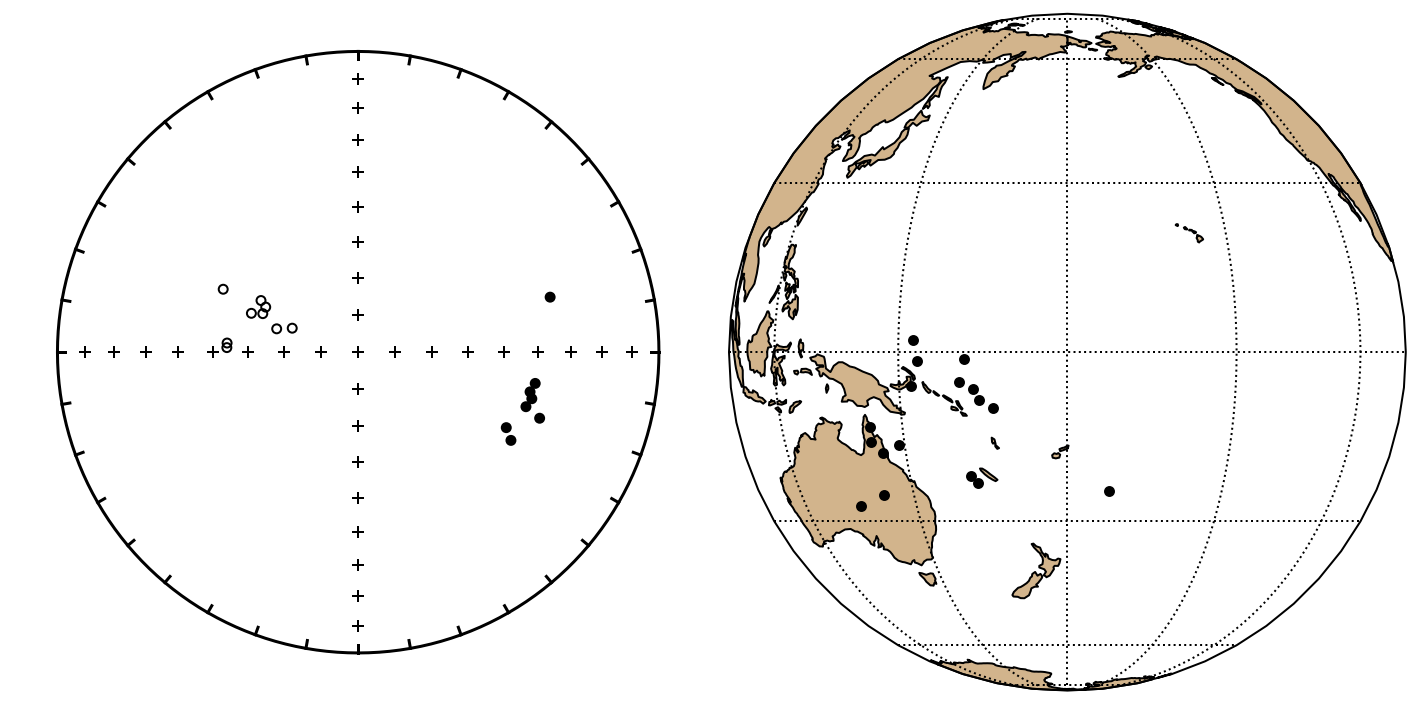

In [9]:
plot_dir_pole(Ueno1975a['dir_dec'], Ueno1975a['dir_inc'],
              Ueno1975a['plat'], Ueno1975a['plon'])

In [10]:
# this site mean data set fails to pass a reversal test
ipmag.reversal_test_MM1990(dec=Ueno1975a['dir_dec'], inc=Ueno1975a['dir_inc'])

Results of Watson V test: 

Watson's V:           32.0
Critical value of V:  6.6
"Fail": Since V is greater than Vcrit, the two means can
be distinguished at the 95% confidence level.

M&M1990 classification:

Angle between data set means: 19.8
Critical angle for M&M1990:   9.0



## Hyodo 1993 Mattawa Gneiss

- petrographic image show that hem-ilm exsolution patter is common in the gneiss and according to the numerical similation result of Harrison (2006) the ferrimagentic hematite form at temepratures <= 527 C
- magnetic unblocking temperature show that the dominant remanence unblock between 580-650 C
- the reversed direction are amost exclusively preserved by mineral with unblocking temperatures above Curie temperature of magnetite
- we compile the site level data and calculate the mean direction and pole position

In [11]:
Hyodo1993a = pd.read_csv('../data/pmag_compilation/Hyodo1993a.csv')
Hyodo1993a = vgp_calc(Hyodo1993a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Hyodo1993a['dir_alpha95'] = 0
Hyodo1993a

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples    lat    lon  dir_k  \
0     48      358      -73            0            NaN  46.25 -78.18    NaN   
1     49      317      -52            0            NaN  46.25 -78.18    NaN   
2     31      294      -73            0            NaN  46.25 -78.18    NaN   
3     69      352      -72            0            NaN  46.25 -78.18    NaN   
4     70      327      -74            0            NaN  46.25 -78.18    NaN   
5     32      311      -70            0            NaN  46.25 -78.18    NaN   
6     33      300      -71            0            NaN  46.25 -78.18    NaN   
7     50      285      -68            0            NaN  46.25 -78.18    NaN   
8     51      300      -63            0            NaN  46.25 -78.18    NaN   
9     52      306      -85            0            NaN  46.25 -78.18    NaN   
10    53      250      -78            0            NaN  46.25 -78.18    NaN   
11    54      319      -67            0            NaN  46.25 -78.18    NaN   
12    55      331      -67            0            NaN  46.25 -78.18    NaN   
13    34      324      -77            0            NaN  46.25 -78.18    NaN   
14    35      307      -74            0            NaN  46.25 -78.18    NaN   
15    58      330      -64            0            NaN  46.25 -78.18    NaN   
16    59      297      -64            0            NaN  46.25 -78.18    NaN   
17    41      325      -76            0            NaN  46.25 -78.18    NaN   
18    60      306      -58            0            NaN  46.25 -78.18    NaN   
19    61      325      -79            0            NaN  46.25 -78.18    NaN   
20    42      333      -75            0            NaN  46.25 -78.18    NaN   
21    62      359      -63            0            NaN  46.25 -78.18    NaN   
22    63      288      -67            0            NaN  46.25 -78.18    NaN   
23    65      304      -74            0            NaN  46.25 -78.18    NaN   
24    66      322      -80            0            NaN  46.25 -78.18    NaN   
25    68      293      -71            0            NaN  46.25 -78.18    NaN   
26    44      282      -75            0            NaN  46.25 -78.18    NaN   
27    45      288      -73            0            NaN  46.25 -78.18    NaN   
28    46      297      -74            0            NaN  46.25 -78.18    NaN   
29    47      319      -72            0            NaN  46.25 -78.18    NaN   

      vgp_lat     vgp_lon  paleolatitude        plon       plat  
0  -14.818849  102.899076     -58.555825  102.899076 -14.818849  
1    2.097273  136.907054     -32.618057  136.907054   2.097273  
2  -28.005599  134.488227     -58.555825  134.488227 -28.005599  
3  -13.448533  106.292041     -56.982602  106.292041 -13.448533  
4  -19.761876  118.552679     -60.166127  118.552679 -19.761876  
5  -18.482696  129.745399     -53.947611  129.745399 -18.482696  
6  -23.505231  134.206819     -55.446556  134.206819 -23.505231  
7  -26.703250  144.630025     -51.059971  144.630025 -26.703250  
8  -15.020444  141.611018     -44.459398  141.611018 -15.020444  
9  -39.903474  112.292916     -80.075015  112.292916 -39.903474  
10 -49.228228  136.080237     -66.969018  136.080237 -49.228228  
11 -12.293719  127.577004     -49.670420  127.577004 -12.293719  
12  -9.163901  120.350965     -49.670420  120.350965  -9.163901  
13 -24.916975  117.585014     -65.215512  117.585014 -24.916975  
14 -24.808991  127.777597     -60.166127  127.777597 -24.808991  
15  -5.677011  122.359696     -45.711564  122.359696  -5.677011  
16 -17.330139  142.493718     -45.711564  142.493718 -17.330139  
17 -23.182941  117.987280     -63.496586  117.987280 -23.182941  
18  -7.697778  141.420361     -38.665651  141.420361  -7.697778  
19 -27.906192  115.422164     -68.755879  115.422164 -27.906192  
20 -20.222525  115.030448     -61.813215  115.030448 -20.222525  
21  -0.713705  102.533785     -44.459398  102.533785  -0.713705  
22 -24.354850  144.323354     -49.67

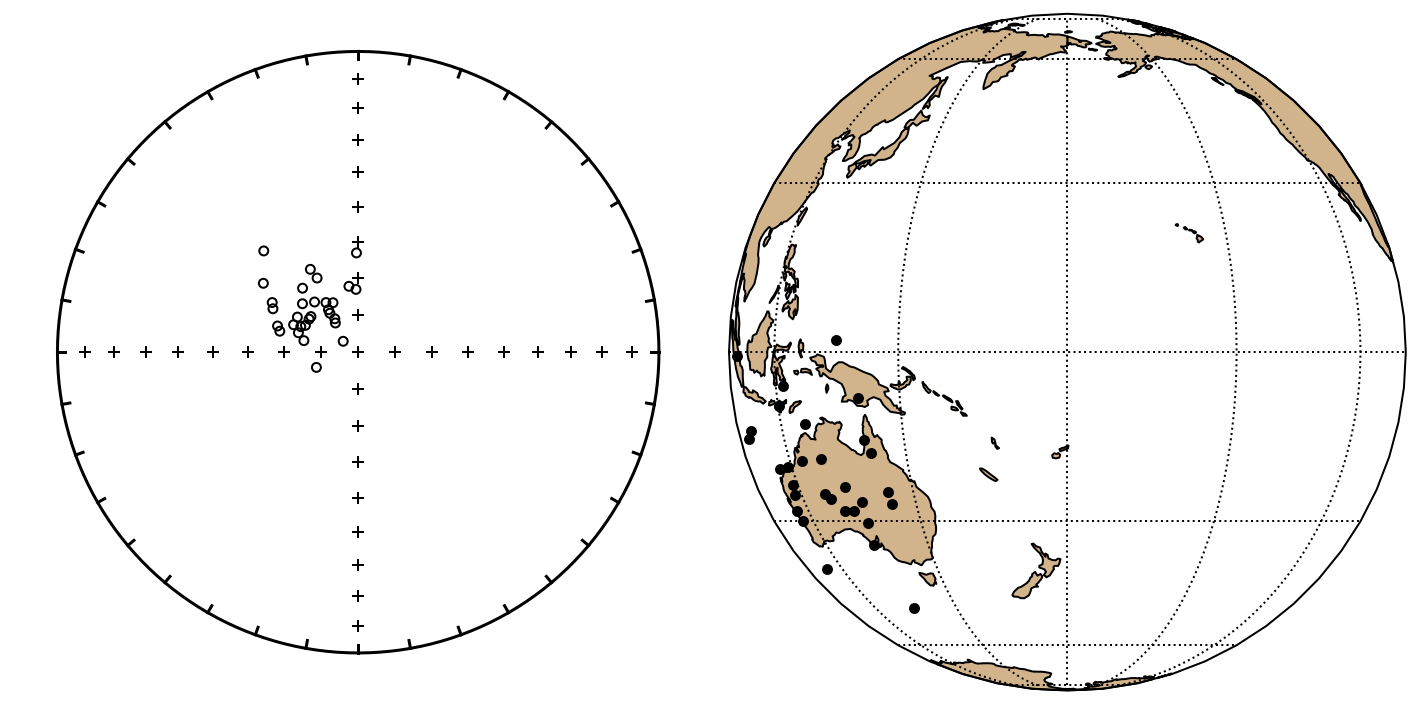

In [12]:
plot_dir_pole(Hyodo1993a['dir_dec'], Hyodo1993a['dir_inc'],
              Hyodo1993a['plat'], Hyodo1993a['plon'])

## Alvarez 1998 work on the Central Gneiss Belt

- extensive smapling through the CGB, isolating antipodal AR and AN
- although there are large a95 but there are few samples for each site
- Argue that there is a pattern of increasing AR away from the GF; and maybe there is a pattern of poles migrating toward north recorded by rocks away from the GF
- we compiled table 1 and 2, and will use the VGPs calculated in table 2 since the location of each site is unknown but span quite large region
- filter for the dir_comp_name = AR+AN

In [13]:
Alvarez1998a = pd.read_csv('../data/pmag_compilation/Alvarez1998a.csv')
Alvarez1998a = vgp_calc(Alvarez1998a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Alvarez1998a['dir_alpha95'] = 0
Alvarez1998a_AN = Alvarez1998a[Alvarez1998a['dir_comp_name'] == 'AN']
Alvarez1998a_AR = Alvarez1998a[Alvarez1998a['dir_comp_name'] == 'AR']
Alvarez1998a_ANAR = Alvarez1998a[Alvarez1998a['dir_comp_name'] == 'AN+AR']

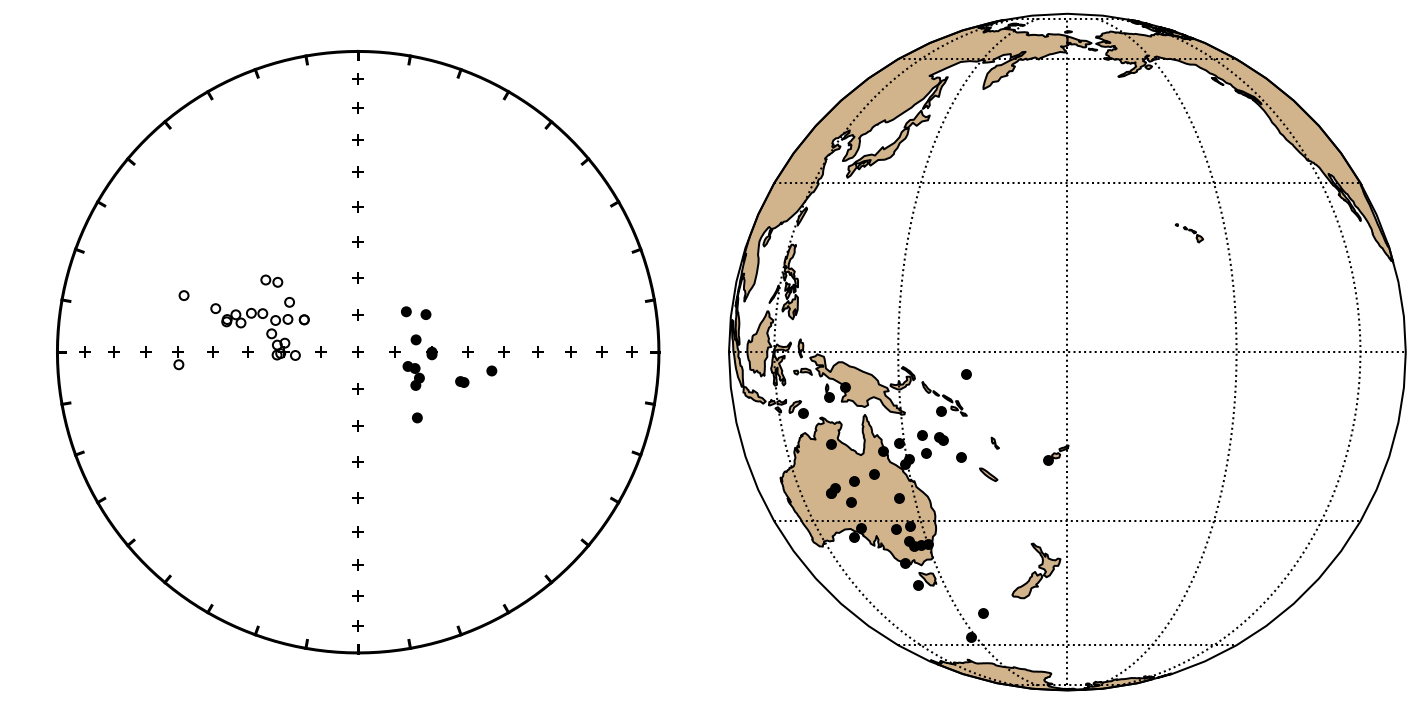

In [14]:
plot_dir_pole(Alvarez1998a['dir_dec'], Alvarez1998a['dir_inc'],
              Alvarez1998a['plat'], Alvarez1998a['plon'])

In [15]:
# this site mean data set fails to pass a reversal test
ipmag.reversal_test_MM1990(dec=Alvarez1998a['dir_dec'], inc=Alvarez1998a['dir_inc'])

Results of Watson V test: 

Watson's V:           9.9
Critical value of V:  6.2
"Fail": Since V is greater than Vcrit, the two means can
be distinguished at the 95% confidence level.

M&M1990 classification:

Angle between data set means: 8.6
Critical angle for M&M1990:   6.8



## Halls 2015 unpublished data
- Mememesing Lake diorite
- Port Loring dyke

- These are site level unpublished data from Halls 2015
- These are all AR components. will filter out these site-mean poles from the site-mean compilation file and plot together.

In [16]:
Halls2015a = pd.read_csv('../data/pmag_compilation/Halls2015a_compilation.csv')
Halls2015a_CGB = Halls2015a[Halls2015a['Halls_Code'].isin(['MMG', 'RV25'])].reset_index(drop=1)
Halls2015a_CGB

Halls_Code                 ROCKNAME dir_comp_name    lat     lon  B   N  \
0        MMG  Mememesing Lake diorite            AR  46.02 -80.003  8 NaN   
1       RV25         Port Loring dyke            AR  45.92 -79.940  6 NaN   

   dir_dec  dir_inc  dir_k  ...  vgp_lat  vgp_lon   dp    dm  pole_alpha95  \
0    284.0    -58.0   42.0  ...     18.0    333.0  9.8  13.2          11.4   
1    292.0    -61.0  219.0  ...     16.8    326.0  5.9   7.7           6.7   

   ChRM_mineralogy blocking_min blocking_max blocking_comment  \
0              NaN          NaN          NaN              NaN   
1              NaN          NaN          NaN              NaN   

                              pmag_reference  
0  H.C.Halls & A. Lovette, Unpublished Data   
1  H.C.Halls & A. Lovette, Unpublished Data   

[2 rows x 21 columns]

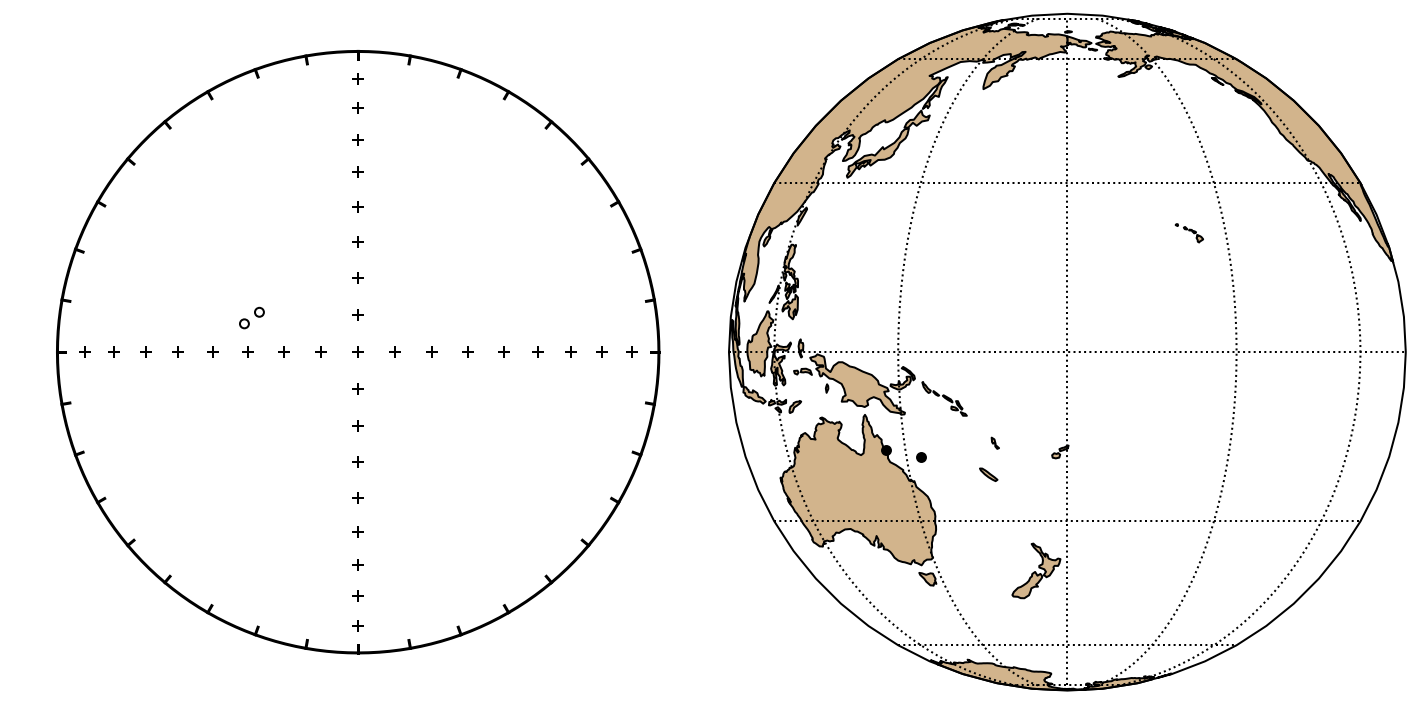

In [17]:
plot_dir_pole(Halls2015a_CGB['dir_dec'], Halls2015a_CGB['dir_inc'],
              -Halls2015a_CGB['vgp_lat'], Halls2015a_CGB['vgp_lon']+180)

## combine data from the CGB

- we group AR and AN directions together and test if their poles are antipodal 
- we group B directions

In [18]:
CGB_AR = pd.concat([McWilliams1975a, Ueno1975a_AR, Hyodo1993a, Alvarez1998a_AR, Halls2015a_CGB]).reset_index(drop=1)
CGB_AN = pd.concat([Ueno1975a_AN, Alvarez1998a_AN]).reset_index(drop=1)

CGB_AN_pole_mean = ipmag.fisher_mean(CGB_AN['vgp_lon'], CGB_AN['vgp_lat'])
CGB_AR_pole_mean = ipmag.fisher_mean(CGB_AR['vgp_lon'], CGB_AR['vgp_lat'])

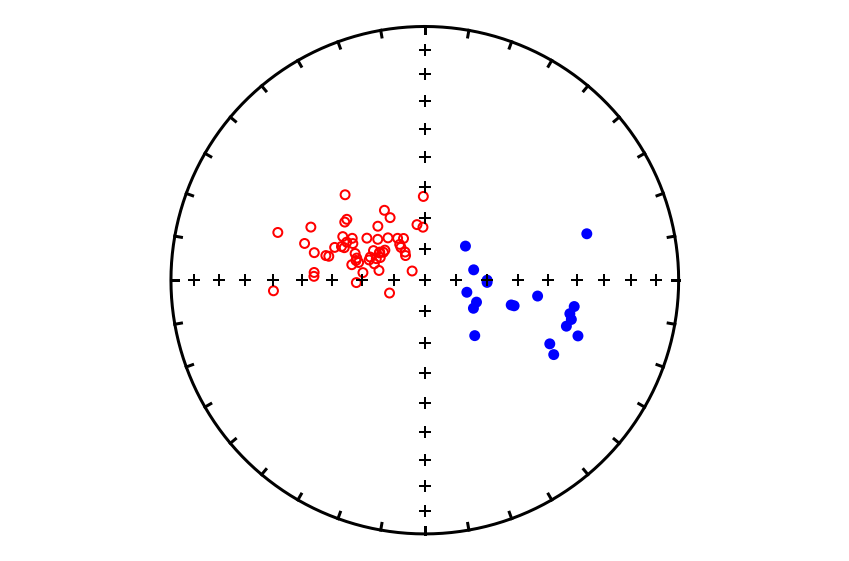

In [83]:
ipmag.plot_net()
ipmag.plot_di(CGB_AR['dir_dec'], CGB_AR['dir_inc'], color = 'r')
ipmag.plot_di(CGB_AN['dir_dec'], CGB_AN['dir_inc'], color = 'b')

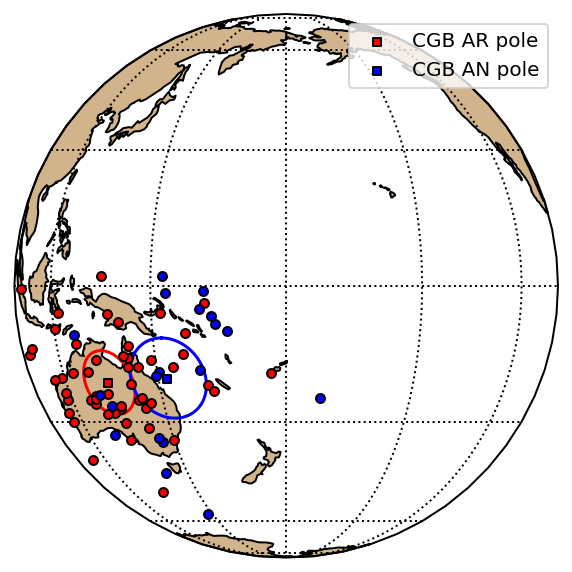

In [20]:
CGB_ax = ipmag.make_orthographic_map(180, 0, figsize=(5,5))
ipmag.plot_vgp(CGB_ax, CGB_AR['vgp_lon'], CGB_AR['vgp_lat'], color = 'r')
ipmag.plot_vgp(CGB_ax, 180+CGB_AN['vgp_lon'], -CGB_AN['vgp_lat'], color = 'b')

ipmag.plot_pole(CGB_ax, CGB_AR_pole_mean['dec'], CGB_AR_pole_mean['inc'], CGB_AR_pole_mean['alpha95'], 
                marker = 's', color = 'r', label = 'CGB AR pole')
ipmag.plot_pole(CGB_ax, 180+CGB_AN_pole_mean['dec'], -CGB_AN_pole_mean['inc'], CGB_AN_pole_mean['alpha95'],
                marker = 's', color = 'b', label = 'CGB AN pole')
plt.legend()
plt.show()

In [21]:
# the AR and AN poles do not pass a common mean
ipmag.reversal_test_MM1990(dec=CGB_AR['vgp_lon'].tolist()+CGB_AN['vgp_lon'].tolist(), inc=CGB_AR['vgp_lat'].tolist()+CGB_AN['vgp_lat'].tolist())

Results of Watson V test: 

Watson's V:           16.7
Critical value of V:  6.4
"Fail": Since V is greater than Vcrit, the two means can
be distinguished at the 95% confidence level.

M&M1990 classification:

Angle between data set means: 14.9
Critical angle for M&M1990:   9.3



# Central Metasedimentary Belt
- Dubois 1962
- Park 1972
- Irving 1972
- Palmer 1973
- Dunlop 1985 Tudor
- Symons 1978
- Palmer 1979
- Dunlop 1985 Cordova
- Buchan 1973, 1976, 1978
- Warnock 2000
- Brett 2008

## Park 1972 Frontenac axis dikes
- AF cleaning result in AN component (20-50 mT)
- dated to be around 910 ma (whole rock Ar age)
- location provided in the text; as well as calculated palepoles
- need to filter odd directions

In [24]:
Park1972a = pd.read_csv('../data/pmag_compilation/Park1972a.csv')
Park1972a = vgp_calc(Park1972a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Park1972a = Park1972a.drop(index=8).reset_index(drop=1)
Park1972a

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples    lat    lon  dir_k  \
0     1      100       43           10              5  44.28 -76.30     59   
1     2      101       46            7              6  44.27 -76.45     96   
2     3      104       49            3              6  44.28 -76.29    485   
3     5      120       59            9              6  44.29 -76.21     59   
4     6      106       49            7              5  44.30 -76.22    129   
5    10       93       51            6              9  44.28 -75.23     83   
6     8      111       70           20              8  44.29 -75.88      9   
7     9      139       45           28              6  44.32 -76.69      7   
8    15      131       60           11              8  44.29 -76.37     28   

     vgp_lat     vgp_lon dir_comp_name  paleolatitude        plon       plat  
0  10.507026  348.899958            AN      24.997641  168.899958 -10.507026  
1  11.514759  346.375188            AN      27.373547  166.375188 -11.514759  
2  11.417822  342.810572            AN      29.906833  162.810572 -11.417822  
3   9.877541  326.298997            AN      39.765187  146.298997  -9.877541  
4  10.207946  341.630146            AN      29.906833  161.630146 -10.207946  
5  19.567311  349.163934            AN      31.693197  169.163934 -19.567311  
6  24.430045  321.238486            AN      53.947611  141.238486 -24.430045  
7  -9.816829  319.859473            AN      26.565051  139.859473   9.816829  
8   5.862503  318.625096            AN      40.893395  138.625096  -5.862503

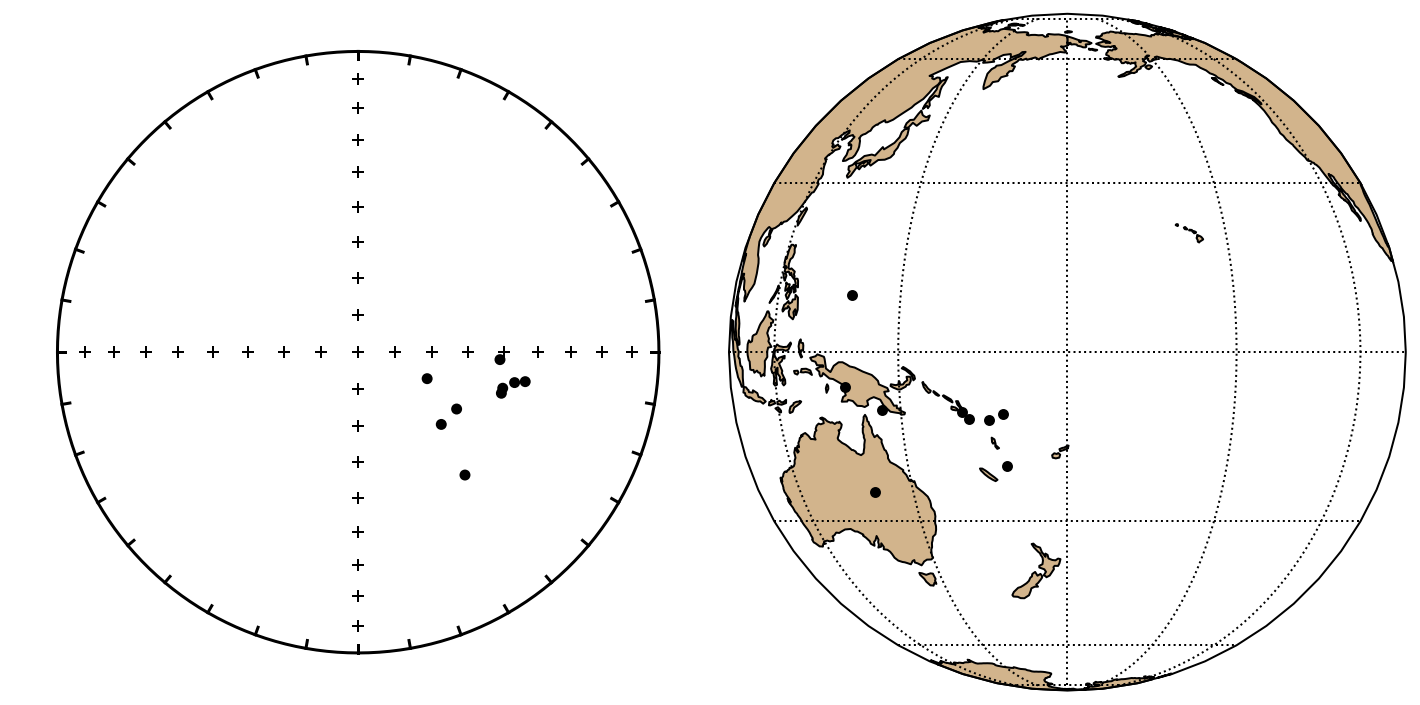

In [25]:
plot_dir_pole(Park1972a['dir_dec'], Park1972a['dir_inc'],
              Park1972a['plat'], Park1972a['plon'])

## Irving 1972 Ottawan Intrusions

- three intrusion localities in the CMB 
- both AR and AN recovered after 30 mT AF
- location provided in text

In [26]:
Irving1972a = pd.read_csv('../data/pmag_compilation/Irving1972a.csv')
Irving1972a = vgp_calc(Irving1972a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Irving1972a

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples    lat    lon  dir_k  \
0      B04      301      -63           16              4  45.68 -76.62     33   
1      B05      269      -59           10              4  45.68 -76.62     94   
2      B11      278      -69           11              5  45.68 -76.62     47   
3      C13      109       64           26              4  45.58 -76.67     14   
4      G01      266      -70            2              7  45.62 -75.85    761   
5      G20      104       59           29              4  45.62 -75.85     11   
6      G19       68       69           18              9  45.62 -75.85      9   
7   G18(N)       41       62           12              4  45.62 -75.85     57   
8   G18(R)      267      -74            3              5  45.62 -75.85    633   
9      G17      266      -61           10              5  45.62 -75.85     57   
10     G27       70       67           15              3  45.62 -75.85     71   
11     G26      276      -61           31              3  45.62 -75.85     17   

      vgp_lat     vgp_lon dir_comp_name  paleolatitude        plon       plat  
0  -14.138635  142.497474            AR     -44.459398  142.497474 -14.138635  
1  -27.840023  163.740673            AR     -39.765187  163.740673 -27.840023  
2  -30.549409  147.825776            AR     -52.485539  147.825776 -30.549409  
3   20.619137  328.193127            AN      45.711564  148.193127 -20.619137  
4  -37.340249  151.748288            AR     -53.947611  151.748288 -37.340249  
5   19.092937  336.266139            AN      39.765187  156.266139 -19.092937  
6   46.590790  339.397089            AN      52.485539  159.397089 -46.590790  
7   60.945330    3.928362            AN      43.239577  183.928362 -60.945330  
8  -39.658232  144.339265            AN     -60.166127  144.339265 -39.658232  
9  -30.993534  163.931308            AR     -42.051214  163.931308 -30.993534  
10  44.400397  342.492197            AN      49.670420  162.492197 -44.400397  
11 -25.114395  158.794950            AR     -42.051214  158.794950 -25.114395

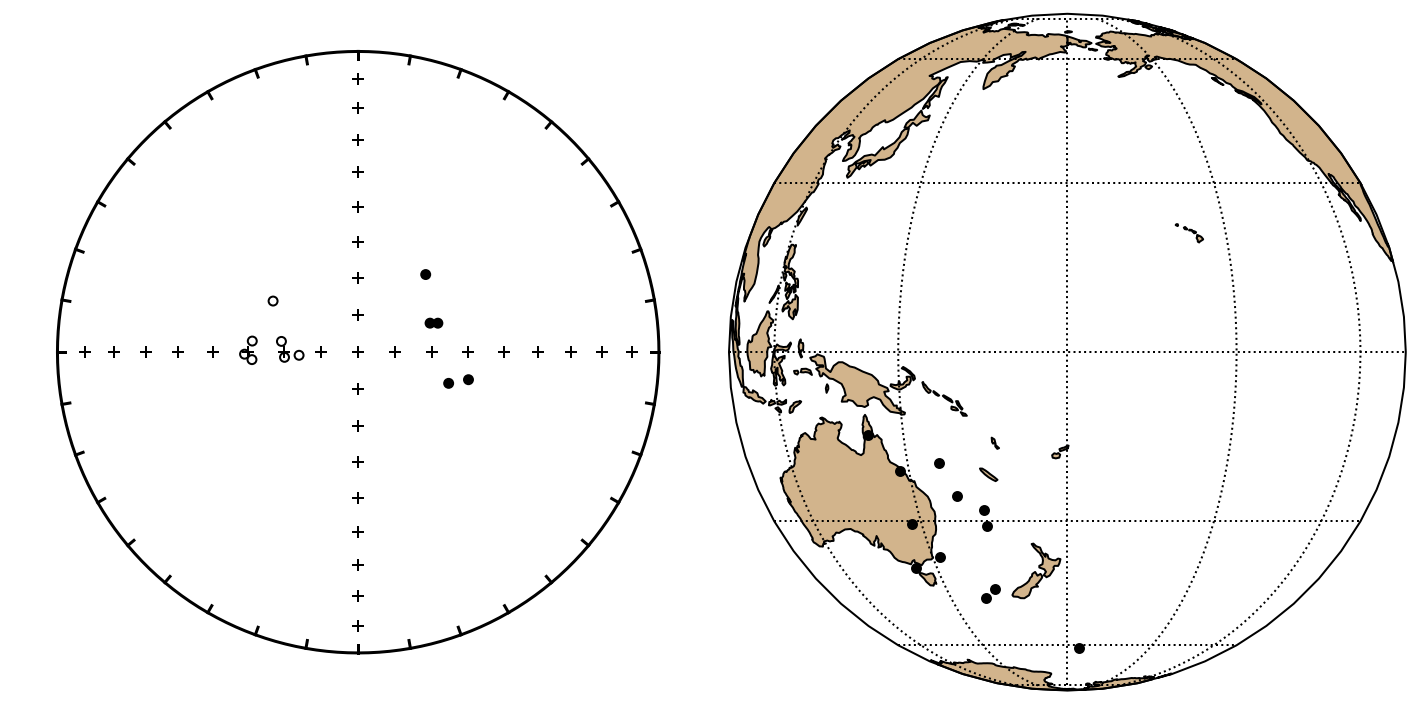

In [27]:
plot_dir_pole(Irving1972a['dir_dec'], Irving1972a['dir_inc'],
              Irving1972a['plat'], Irving1972a['plon'])

In [28]:
# the AR and AN component pass a reversal test
ipmag.reversal_test_MM1990(Irving1972a['dir_dec'], Irving1972a['dir_inc'])

Results of Watson V test: 

Watson's V:           1.9
Critical value of V:  7.5
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 6.3
Critical angle for M&M1990:   12.6
The McFadden and McElhinny (1990) classification for
this test is: 'C'


## Palmer 1973 Wilberforce Pyroxenite and Tudor Gabbro 

as well as St. Charles meta-anorthosite, River Valley anorthosite, and Fall Lake Complex

- This study has only 30 mT magnetic cleaning thus was actually seeing both soft magnetite and hard hematite blended remanence
- But overall both the pyroxenite and gabbro show AR direction - we can subselect them in the compilation of site level data and illustrate this
- the northern Grenville samples - those that are from St. Charles meta-anorthosite, River Valley anorthosite, and Fall Lake Complex are of AN direction but similar pole position - reflecting differential uplift? or perhaps lack of demag 

- we will isolate out the  St. Charles meta-anorthosite, River Valley anorthosite, and Fall Lake Complex for later section as they are North to the ABT and should be regarded as overprinted rocks

In [29]:
Palmer1973a = pd.read_csv('../data/pmag_compilation/Palmer1973a.csv')
Palmer1973a = vgp_calc(Palmer1973a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Palmer1973a.at[5, 'dir_alpha95']= 0
Palmer1973a_WP = Palmer1973a[Palmer1973a['site'].str.startswith('WP')].reset_index(drop=1)
Palmer1973a_TG = Palmer1973a[Palmer1973a['site'].str.startswith('TG')].reset_index(drop=1)
Palmer1973a_TG

site          unit  dir_dec  dir_inc  dir_alpha95  dir_n_samples    lat  \
0   TG1  Tudor Gabbro    337.2    -38.0         22.6              6  46.33   
1   TG2  Tudor Gabbro    333.7    -33.1          0.0              2  46.33   
2   TG3  Tudor Gabbro    331.9    -46.7          6.6              7  46.33   
3   TG4  Tudor Gabbro    324.7    -36.3         15.2              4  46.33   
4   TG5  Tudor Gabbro    325.0    -30.6         25.2              5  46.33   
5   TG6  Tudor Gabbro    343.7    -43.0          4.1              3  46.33   
6   TG8  Tudor Gabbro    296.1    -33.7         11.1              4  46.33   
7  TG10  Tudor Gabbro    309.2    -32.2          5.0              3  46.33   
8  TG11  Tudor Gabbro    325.7    -35.7         17.0              4  46.33   
9  TG12  Tudor Gabbro    315.4    -30.1         36.6              4  46.33   

    lon  dir_k    vgp_lat     vgp_lon dir_comp_name  paleolatitude  \
0 -80.4    9.7  19.251879  122.078257            AR     -21.337745   
1 -80.4    8.4  21.370233  126.495228            AR     -18.053166   
2 -80.4   84.6  11.480880  124.723278            AR     -27.949845   
3 -80.4   37.3  16.237154  133.999723            AR     -20.167603   
4 -80.4   10.2  19.712601  135.351714            AR     -16.472905   
5 -80.4  893.0  17.157615  115.039641            AR     -24.997641   
6 -80.4   69.9   3.403416  158.185282            AR     -18.441405   
7 -80.4  617.0  11.480436  148.560743            AR     -17.477484   
8 -80.4   30.3  16.992782  133.279426            AR     -19.762675   
9 -80.4    7.3  15.715418  144.074022            AR     -16.163695   

         plon       plat  
0  122.078257  19.251879  
1  126.495228  21.370233  
2  124.723278  11.480880  
3  133.999723  16.237154  
4  135.351714  19.712601  
5  115.039641  17.157615  
6  158.185282   3.403416  
7  148.560743  11.480436  
8  133.279426  16.992782  
9  144.074022  15.715418

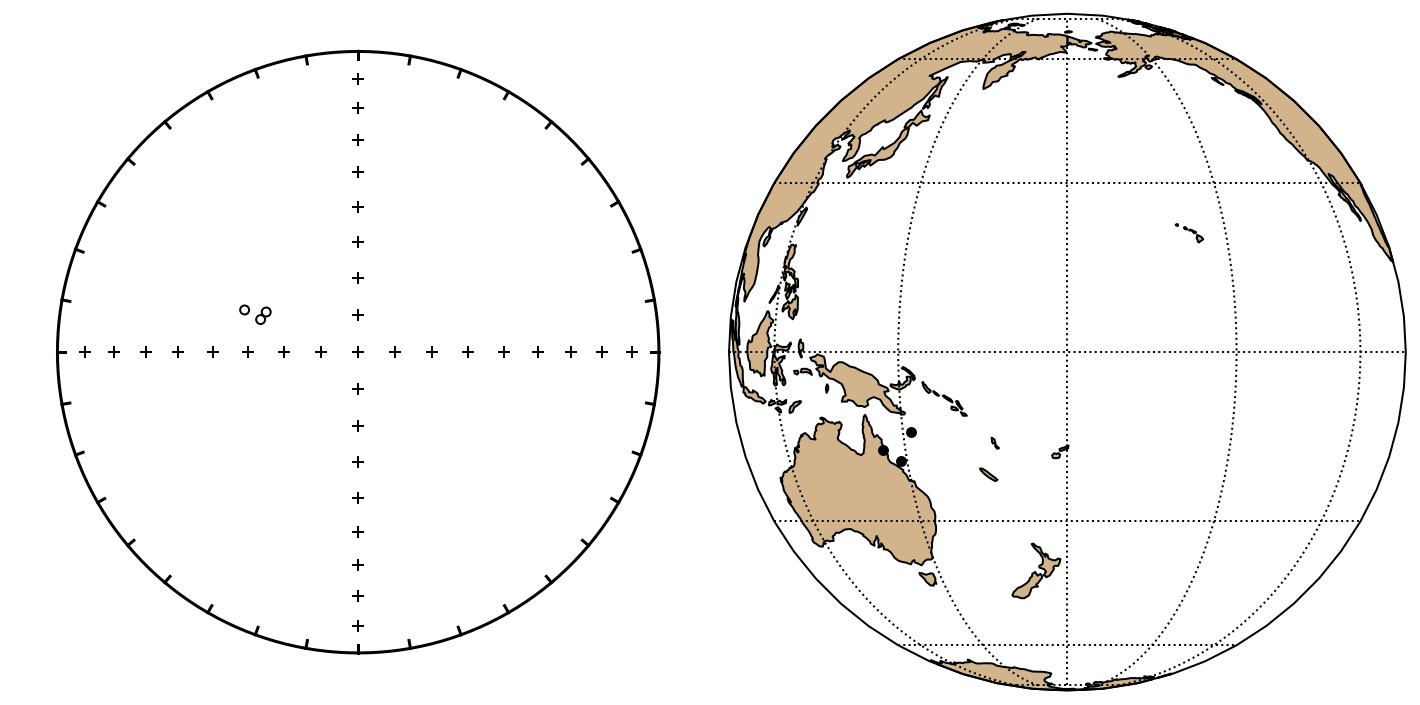

In [30]:
plot_dir_pole(Palmer1973a_WP['dir_dec'], Palmer1973a_WP['dir_inc'],
              Palmer1973a_WP['plat'], Palmer1973a_WP['plon'])

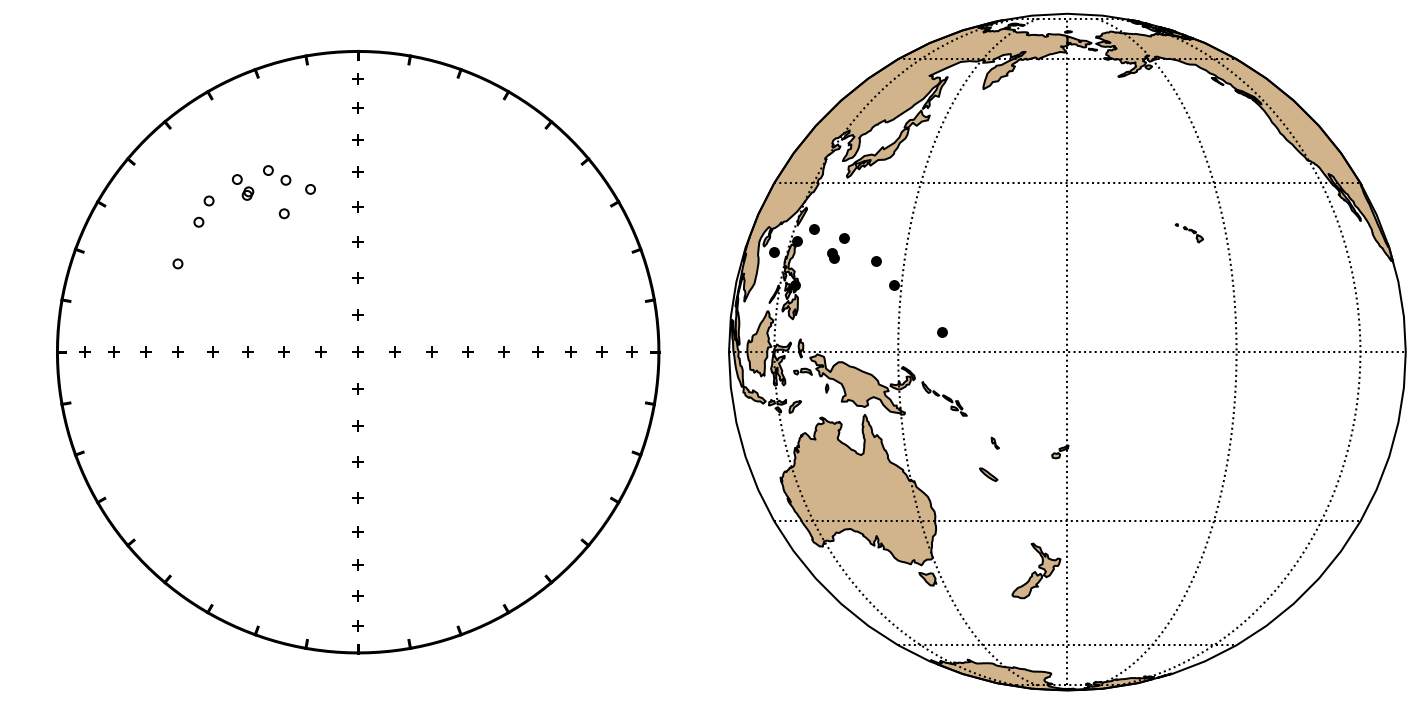

In [31]:
plot_dir_pole(Palmer1973a_TG['dir_dec'], Palmer1973a_TG['dir_inc'],
              Palmer1973a_TG['plat'], Palmer1973a_TG['plon'])

## Dunlop 1985 Tudor Gabbro

- the Tudor direction should be combined with that of Palmer data, as they agree very well

In [32]:
Dunlop1985b = pd.read_csv('../data/pmag_compilation/Dunlop1985b.csv')
Dunlop1985b = vgp_calc(Dunlop1985b, 'lon', 'lat', 'dir_dec', 'dir_inc')
Dunlop1985b

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples    lat    lon  dir_k  \
0     1    334.0    -52.0         11.0              4  44.75 -77.67     69   
1     2    329.0    -49.5         13.5              4  44.75 -77.67     55   
2     6    314.0    -45.5          7.5              6  44.75 -77.67     77   
3     7    323.5    -42.5          8.5              4  44.75 -77.67    110   
4     9    330.5    -47.5         14.5              6  44.75 -77.67     22   
5    10    329.5    -41.0          8.0              6  44.75 -77.67     67   
6    11    317.5    -37.0         12.0              6  44.75 -77.67     31   
7    12    331.0    -49.0         14.0              5  44.75 -77.67     43   

     vgp_lat     vgp_lon dir_comp_name  paleolatitude        plon       plat  
0   9.099430  124.288705            AR     -32.618057  124.288705   9.099430  
1   9.768301  129.138677            AR     -30.345764  129.138677   9.768301  
2   6.917363  142.557526            AR     -26.967160  142.557526   6.917363  
3  13.047825  136.047491            AR     -24.615622  136.047491  13.047825  
4  11.851734  128.540844            AR     -28.619277  128.540844  11.851734  
5  16.293950  131.339196            AR     -23.491856  131.339196  16.293950  
6  13.990222  142.987138            AR     -20.645256  142.987138  13.990222  
7  10.801887  127.660038            AR     -29.906833  127.660038  10.801887

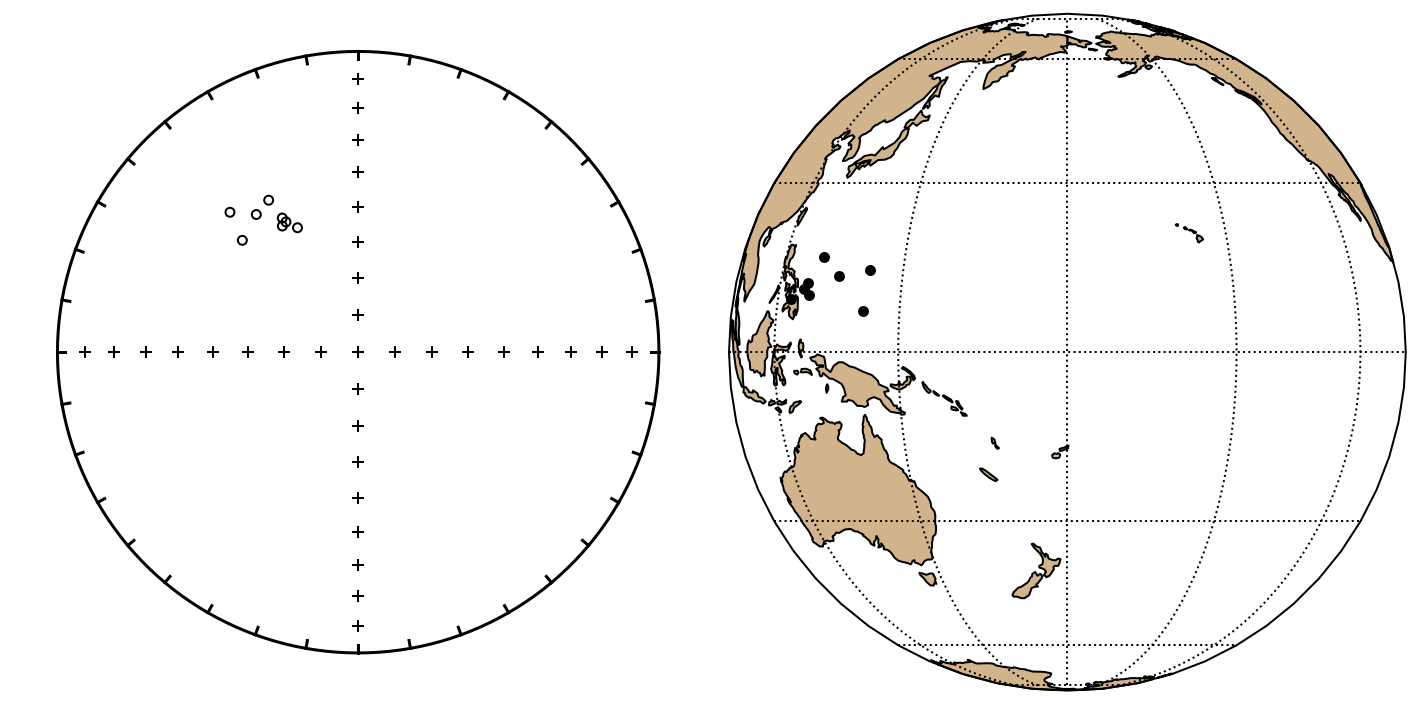

In [33]:
plot_dir_pole(Dunlop1985b['dir_dec'], Dunlop1985b['dir_inc'],
              Dunlop1985b['plat'], Dunlop1985b['plon'])

## Tudor Gabbro 

In [34]:
TG = pd.concat([Palmer1973a_TG, Dunlop1985b]).reset_index(drop=1)

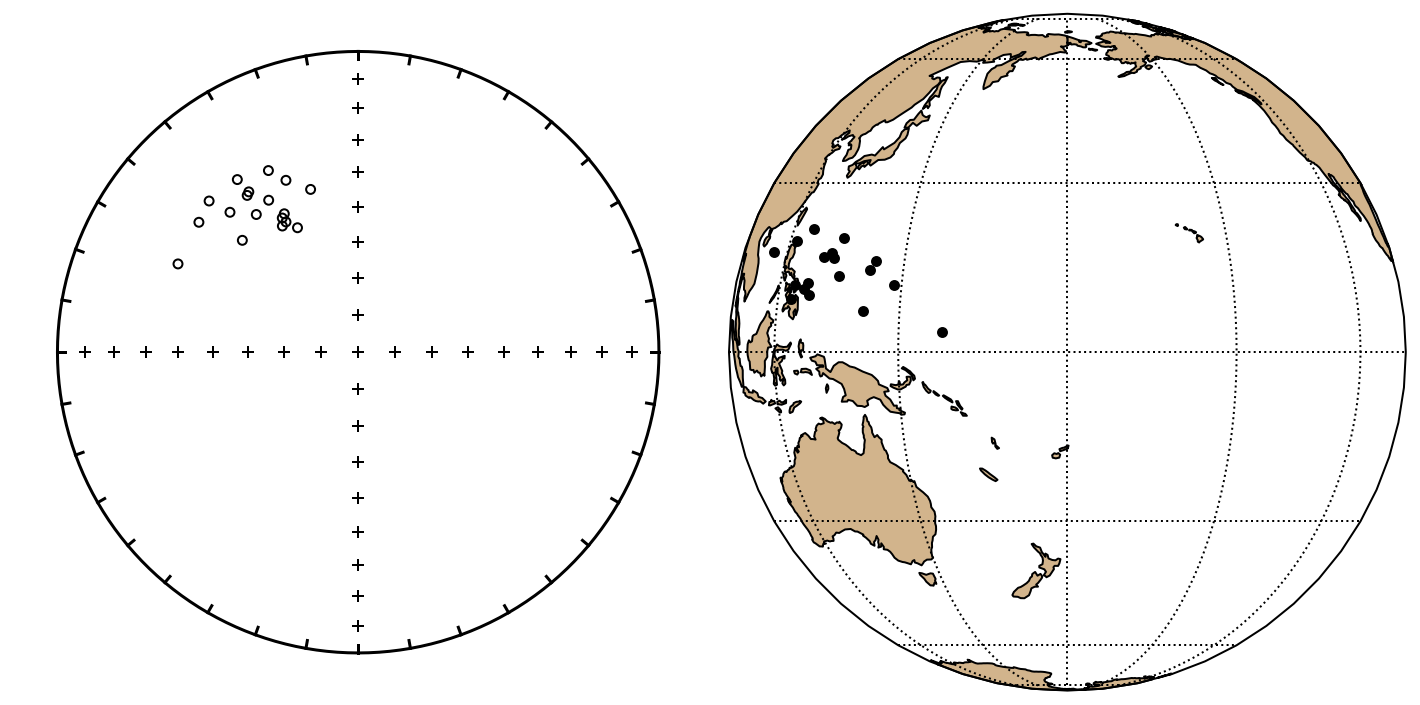

In [35]:
plot_dir_pole(TG['dir_dec'], TG['dir_inc'],
              TG['plat'], TG['plon'])

## Dubois 1962 Haliburton granite-gneiss, pyroxenites, and syenite gneiss
- AF 20 mT cleaning was applied and isolated quite well grouped AR directions
- location provided in the text

In [22]:
Dubois1962a = pd.read_csv('../data/pmag_compilation/Dubois1962a.csv')
Dubois1962a = vgp_calc(Dubois1962a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Dubois1962a['dir_alpha95'] = 0
Dubois1962a

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples    lat    lon  dir_k  \
0    M12    283.5    -32.5            0            NaN  45.78 -78.92    NaN   
1    M13    299.5    -49.0            0            NaN  45.78 -78.92    NaN   
2    M23    313.0    -41.0            0            NaN  45.78 -78.92    NaN   
3    M24    293.5    -49.5            0            NaN  45.78 -78.92    NaN   
4    M29    318.5    -41.5            0            NaN  45.78 -78.92    NaN   
5    M30    257.5    -16.5            0            NaN  45.78 -78.92    NaN   
6    M40    253.5    -10.5            0            NaN  45.78 -78.92    NaN   
7    M41    306.5    -22.0            0            NaN  45.78 -78.92    NaN   
8    M42    308.5    -59.0            0            NaN  45.78 -78.92    NaN   
9    M43    281.0    -64.0            0            NaN  45.78 -78.92    NaN   
10  Ban1    283.0    -57.0            0            NaN  45.08 -78.25    NaN   
11  Ban2    282.5    -63.5            0            NaN  45.08 -78.25    NaN   
12    W1    281.0    -37.5            0            NaN  45.68 -75.88    NaN   
13    W2    230.0    -54.5            0            NaN  45.68 -75.88    NaN   
14    W3    294.0    -30.5            0            NaN  45.68 -75.88    NaN   
15    W4    252.5    -44.0            0            NaN  45.68 -75.88    NaN   

      vgp_lat     vgp_lon dir_comp_name  paleolatitude        plon       plat  
0   -3.576820  169.252895            AR     -17.668505  169.252895  -3.576820  
1   -3.418656  150.175475            AR     -29.906833  150.175475  -3.418656  
2    8.658040  143.804065            AR     -23.491856  143.804065   8.658040  
3   -7.012148  153.960629            AR     -30.345764  153.960629  -7.012148  
4   10.821864  139.173686            AR     -23.862808  139.173686  10.821864  
5  -14.733140  194.118495            AR      -8.424648  194.118495 -14.733140  
6  -15.269612  199.323743            AR      -5.294451  199.323743 -15.269612  
7   15.350015  155.874366            AR     -11.420796  155.874366  15.350015  
8   -7.162910  138.402520            AR     -39.765187  138.402520  -7.162910  
9  -24.840487  150.133646            AR     -45.711564  150.133646 -24.840487  
10 -17.825562  155.941789            AR     -37.593842  155.941789 -17.825562  
11 -23.172041  150.328004            AR     -45.081383  150.328004 -23.172041  
12  -7.574300  171.721555            AR     -20.989985  171.721555  -7.574300  
13 -51.115143  191.887438            AR     -35.029462  191.887438 -51.115143  
14   4.040654  165.583337            AR     -16.410888  165.583337   4.040654  
15 -30.018425  186.818055            AR     -25.773313  186.818055 -30.018425

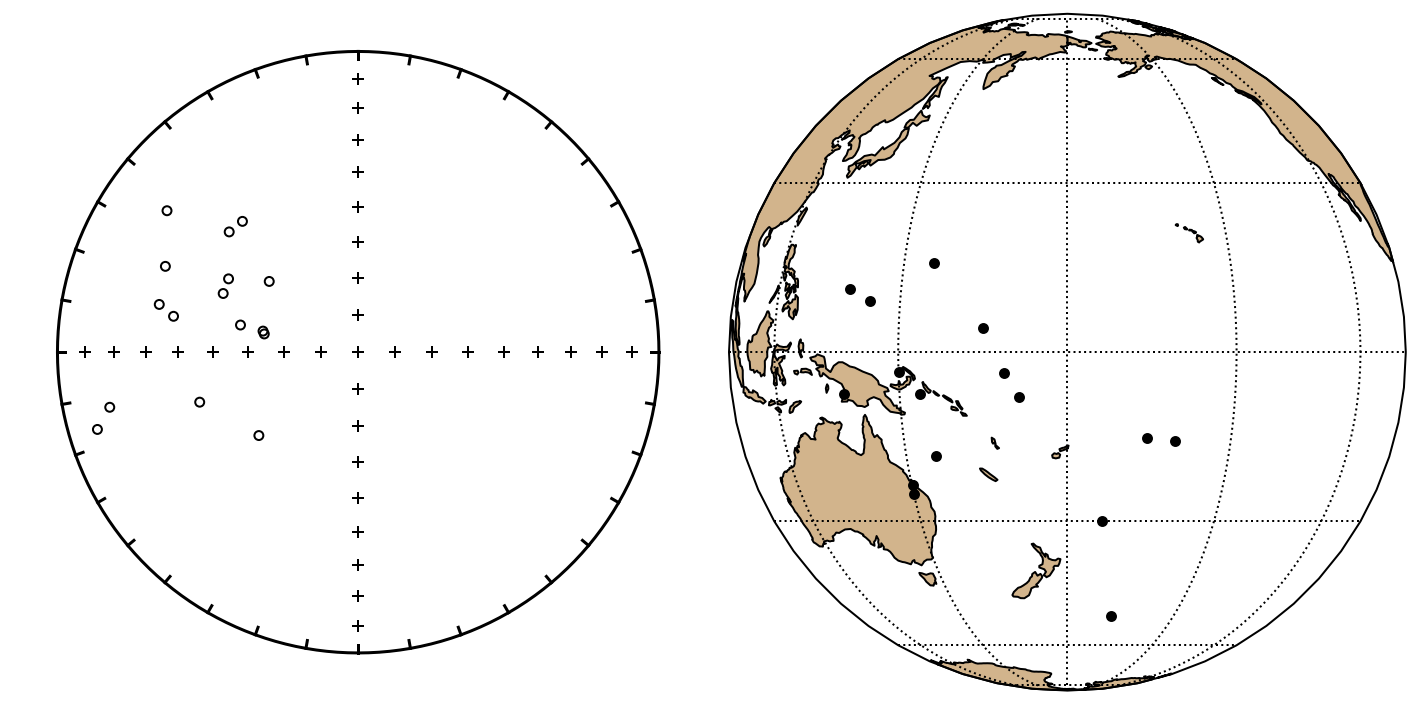

In [23]:
plot_dir_pole(Dubois1962a['dir_dec'], Dubois1962a['dir_inc'],
              Dubois1962a['plat'], Dubois1962a['plon'])

## Buchan 1973, 1976 Bark Lake diorite, Dudmon diorite, and Glamoragan gabbro-anorthosite of the Haliburton intrusions

- the sites in Buchan 1973, 1976 need to be binned by intrusion/ polarity together first before calculating mean direction or pole for AR or AN or B
- There is an AR component carried by hematite
- There is a B component carried by titanomagentite
- There is a C component carried by magnetite with low unblocking temeprature
- we compile the site level data and calculate the site mean and pole mean
- "site" name with letters are sites for A component; name with only numbers are samples for B component

In [36]:
Buchan1973a = pd.read_csv('../data/pmag_compilation/Buchan1973a.csv')
Buchan1976a = pd.read_csv('../data/pmag_compilation/Buchan1976a.csv')
Buchan_73_76 = pd.concat([Buchan1973a, Buchan1976a]).reset_index(drop=1)
Buchan_73_76 = vgp_calc(Buchan_73_76, 'lon', 'lat', 'dir_dec', 'dir_inc')
Buchan_73_76_A = Buchan_73_76[Buchan_73_76['dir_comp_name'].str.contains('A')].reset_index(drop=1)
Buchan_73_76_B = Buchan_73_76[Buchan_73_76['dir_comp_name'] == 'B'].reset_index(drop=1)
Buchan_73_76_A

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples    lat    lon   dir_k  \
0    D1    254.0    -68.0         10.0              3  44.95 -78.44   163.0   
1    D2    280.0    -70.0         14.0              3  44.95 -78.44    81.0   
2    D4    257.0    -73.0          NaN              1  44.95 -78.44     NaN   
3    D5    155.0    -85.0         18.0              4  44.95 -78.44    27.0   
4    D6    266.0    -72.0          6.0              4  44.95 -78.44   214.0   
5   D11    289.0    -69.0         49.0              2  44.95 -78.44    28.0   
6    B1    245.0    -71.0         11.0              4  44.95 -78.44    69.0   
7    B2    279.0    -65.0          NaN              1  44.95 -78.44     NaN   
8    B8    288.0    -66.0          NaN              1  44.95 -78.44     NaN   
9    B9    228.0    -75.0          NaN              1  44.95 -78.44     NaN   
10   G4    293.0    -67.0          8.0              4  44.95 -78.44   132.0   
11   B1    233.7    -74.6         12.7              5  44.95 -78.44    54.0   
12   B2    267.2    -57.2          NaN              2  44.95 -78.44     NaN   
13   B5    308.1    -64.2          NaN              1  44.95 -78.44     NaN   
14   B8    288.0    -66.1          NaN              1  44.95 -78.44     NaN   
15   B9    227.7    -75.1          NaN              1  44.95 -78.44     NaN   
16  B12    212.4    -71.7          5.9              5  44.95 -78.44   168.0   
17  B14    269.5    -62.3         16.4              3  44.95 -78.44    58.0   
18   D1    253.7    -67.6          9.7              3  44.95 -78.44   163.0   
19   D2    279.8    -69.9         13.8              3  44.95 -78.44    81.0   
20   D4    256.9    -72.5          NaN              1  44.95 -78.44     NaN   
21   D5    165.6    -83.3         19.4              4  44.95 -78.44    23.0   
22   D6    266.0    -72.0          6.3              4  44.95 -78.44   214.0   
23  D11    288.7    -68.9          NaN              2  44.95 -78.44     NaN   
24   G3    344.1    -66.2         12.0              3  44.95 -78.44   107.0   
25   G4     94.1     43.2          5.9              3  44.95 -78.44   425.0   
26  G16    127.0     29.9          2.9              3  44.95 -78.44  1779.0   
27  G16    121.6     26.8          NaN              2  44.95 -78.44     NaN   
28  G19     88.9     38.0          7.9              3  44.95 -78.44   243.0   
29  G20    101.1     42.4         15.6              3  44.95 -78.44    64.0   
30  G20    105.5     34.1          8.1              3  44.95 -78.44   232.0   
31  G21    105.2     34.8          4.0              3  44.95 -78.44   542.0   
32  G21    102.0     34.4          4.4              3  44.95 -78.44   437.0   
33  G22    100.2     27.3          9.7              3  44.95 -78.44   161.0   
34  G22    105.3     31.4          6.0              4  44.95 -78.44   231.0   

      vgp_lat     vgp_lon dir_comp_name  paleolatitude        plon       plat  
0  -42.230624  156.240449            AR     -51.059971  156.240449 -42.230624  
1  -29.924298  143.529591            AR     -53.947611  143.529591 -29.924298  
2  -43.297908  145.859136            AR     -58.555825  145.859136 -43.297908  
3  -53.752442   94.483492            AR     -80.075015   94.483492 -53.752442  
4  -38.264707  145.372599            AR     -56.982602  145.372599 -38.264707  
5  -24.839320  140.941483            AR     -52.485539  140.941483 -24.839320  
6  -48.720753  152.743733            AR     -55.446556  152.743733 -48.720753  
7  -26.177780  150.205273            AR     -46.996928  150.205273 -26.177780  
8  -22.469226  144.750643            AR     -48.316298  144.750643 -22.469226  
9  -57.821516  142.793173            AR     -61.813215  142.793173 -57.821516  
10 -21.076600  141.236136            AR     -49.670420  141.236136 -21.076600  
11 -55.182060  144.487886            AR     -61.149992  144.487886 -55.182060  
12 -27.412034  164.302964            AR     -37.806031  164.302964 -27.412034  
13 -11.793015  135.531597            A

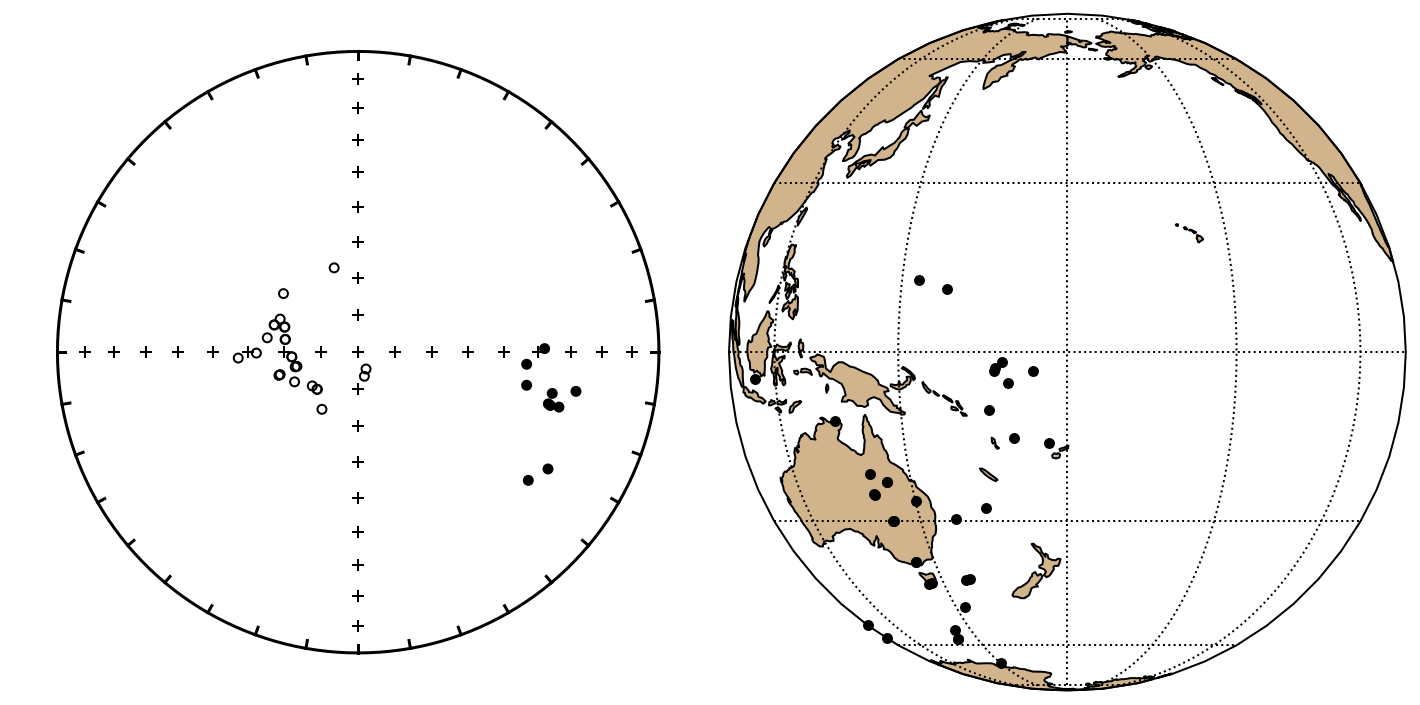

In [37]:
plot_dir_pole(Buchan_73_76_A['dir_dec'], Buchan_73_76_A['dir_inc'],
              Buchan_73_76_A['plat'], Buchan_73_76_A['plon'])

## Warnock 2000 Haliburton Glamoragan intrusions

- nice work on studying the undeformed intrusions, showing that there is no hemo-ilmenite - that these rocks are protected from oxidation during metamorphism
- but that magnetite carry the AR is excellent evidence for there bing a reversal during Grenville (post Grenville uplift)
- AR and AN are real
- clear evidence that post Grenville thermochemical remanence by magnetite or pyrrhotite carry the B component
- we can combined these data with Buchan's work
- site location estimated from map figure

In [38]:
Warnock2000a = pd.read_csv('../data/pmag_compilation/Warnock2000a.csv')
Warnock2000a = vgp_calc(Warnock2000a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Warnock2000a_AR = Warnock2000a[Warnock2000a['dir_comp_name'] == 'AR']
Warnock2000a_B = Warnock2000a[Warnock2000a['dir_comp_name'] == 'B']
Warnock2000a

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples    lat    lon  \
0    1010201L    283.9    -64.0          NaN              4  44.95 -78.44   
1    1020201L    316.1    -70.1          NaN              6  44.95 -78.44   
2    1030201L    292.7    -54.5          NaN              4  44.95 -78.44   
3    2030101L    239.4    -79.4          NaN              7  44.95 -78.44   
4      96A02L    269.7    -72.1          NaN              5  44.95 -78.44   
5      96A03L    263.4    -59.3          NaN              5  44.95 -78.44   
6      96A05L    283.4    -73.9          NaN              7  44.95 -78.44   
7      96A06L    259.0    -75.6          NaN              6  44.95 -78.44   
8      96A07L    254.6    -78.6          NaN              8  44.95 -78.44   
9      96A08L    265.8    -77.4          NaN              6  44.95 -78.44   
10     96C05L    293.9    -53.8          NaN              4  44.95 -78.44   
11     96C06L    284.4    -64.1          NaN              5  44.95 -78.44   
12     96C07L    291.6    -63.6          NaN              7  44.95 -78.44   
13     96C08L    262.1    -78.9          NaN              6  44.95 -78.44   
14     96C09L    268.2    -78.2          NaN              6  44.95 -78.44   
15     96C10L    268.2    -73.8          NaN              4  44.95 -78.44   
16     96D02L    327.4    -71.8          NaN              6  44.95 -78.44   
17  01010101S    318.1     32.2          NaN              3  44.95 -78.44   
18  01020201L    343.4     21.9          NaN             10  44.95 -78.44   
19  01030101S    306.6    -12.5          NaN              7  44.95 -78.44   
20     96C02S    300.4     18.9          NaN              5  44.95 -78.44   
21     96C05L    303.7     17.7          NaN              6  44.95 -78.44   
22     96C10S    326.7     43.2          NaN              7  44.95 -78.44   

    dir_k    vgp_lat     vgp_lon dir_comp_name  paleolatitude        plon  \
0     NaN -22.768729  148.876219            AR     -45.711564  148.876219   
1     NaN -15.855051  126.566065            AR     -54.095842  126.566065   
2     NaN -10.479357  151.756161            AR     -35.029462  151.756161   
3     NaN -51.994057  130.901709            AR     -69.479636  130.901709   
4     NaN -36.544672  144.044719            AR     -57.138251  144.044719   
5     NaN -31.150858  164.166649            AR     -40.100596  164.166649   
6     NaN -31.996048  136.551428            AR     -60.003435  136.551428   
7     NaN -43.642518  139.850125            AR     -62.818925  139.850125   
8     NaN -46.511113  133.156221            AR     -68.037222  133.156221   
9     NaN -41.768800  134.634877            AR     -65.912827  134.634877   
10    NaN  -9.309802  151.465656            AR     -34.339458  151.465656   
11    NaN -22.594258  148.521171            AR     -45.838593  148.521171   
12    NaN -18.530301  145.260866            AR     -45.206760  145.260866   
13    NaN -43.884175  131.691644            AR     -68.575732  131.691644   
14    NaN -41.333949  132.435893            AR     -67.323766  132.435893   
15    NaN -38.464109  141.450273            AR     -59.841111  141.450273   
16    NaN -15.231648  119.425966            AR     -56.672418  119.425966   
17    NaN  45.612831  167.155211             B      17.477484  347.155211   
18    NaN  53.528034  129.671284             B      11.364943  309.671284   
19    NaN  19.971822  159.661750             B      -6.325262  159.661750   
20    NaN  28.177562  176.235498             B       9.714202  356.235498   
21    NaN  29.940277  173.017147             B       9.066273  353.017147   
22    NaN  56.689249  166.373654             B      25.151523  346.373654   

         plat  
0  -22.768729  
1  -15.855051  
2  -10.479357  
3  -51.994057  
4  -36.544672  
5  -31.150858  
6  -31.996048  
7  -43.642518  
8  -46.511113  
9  -41.768800  
10  -9.309802  
11 -22.594258  
12 -18.530301  
13 -43.884175  
14 -41.333949  
15 -38.464109  
16 -15.231648  
17 -45.612831  
18 -53.

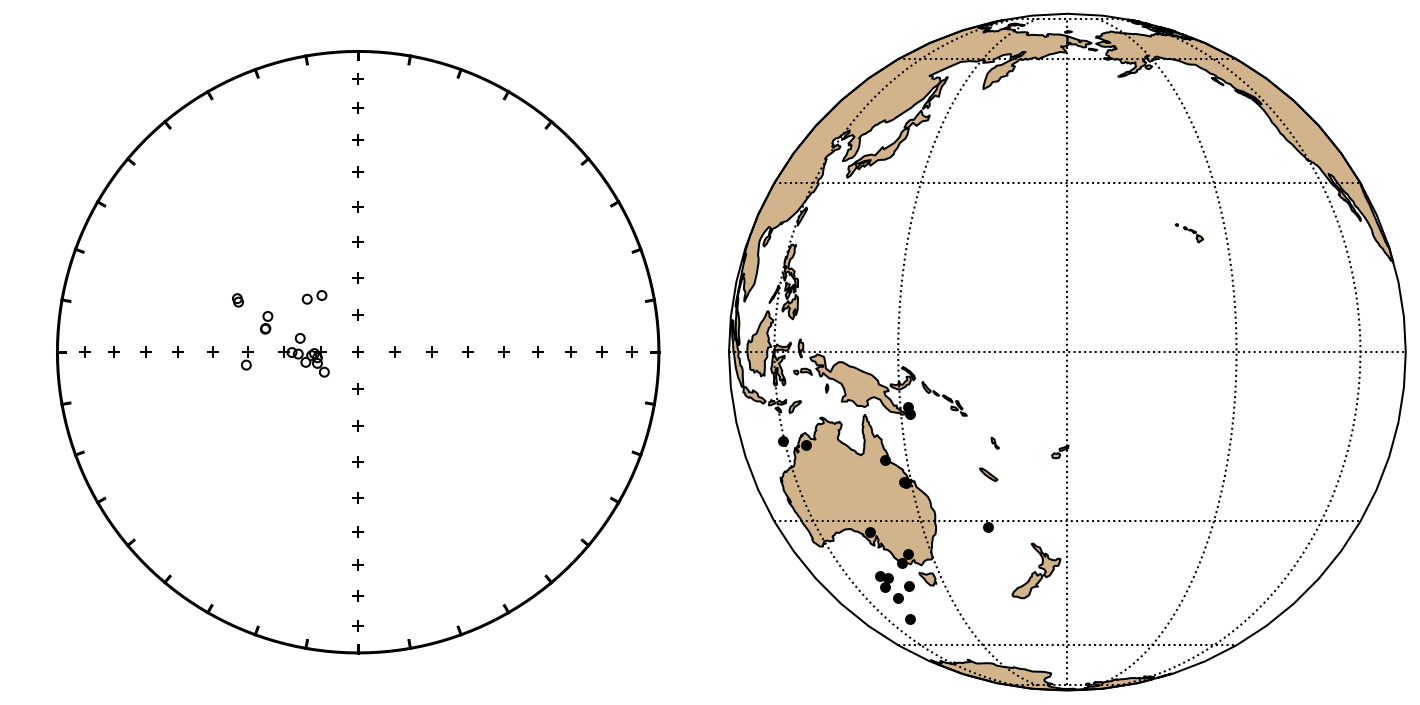

In [39]:
plot_dir_pole(Warnock2000a_AR['dir_dec'], Warnock2000a_AR['dir_inc'],
              Warnock2000a_AR['plat'], Warnock2000a_AR['plon'])

## Haliburton Intrusions

In [175]:
Haliburton_A = pd.concat([Warnock2000a_AR, Buchan_73_76_A]).reset_index(drop=1)
Haliburton_AN = Haliburton_A[Haliburton_A['dir_inc'] > 0].reset_index(drop=1)
Haliburton_AR = Haliburton_A[Haliburton_A['dir_inc'] < 0].reset_index(drop=1)
Haliburton_B = pd.concat([Warnock2000a_B, Buchan_73_76_B]).reset_index(drop=1)

Haliburton_AN_mean_pole = ipmag.fisher_mean(Haliburton_AN['plon'], Haliburton_AN['plat'])
Haliburton_AR_mean_pole = ipmag.fisher_mean(Haliburton_AR['plon'], Haliburton_AR['plat'])

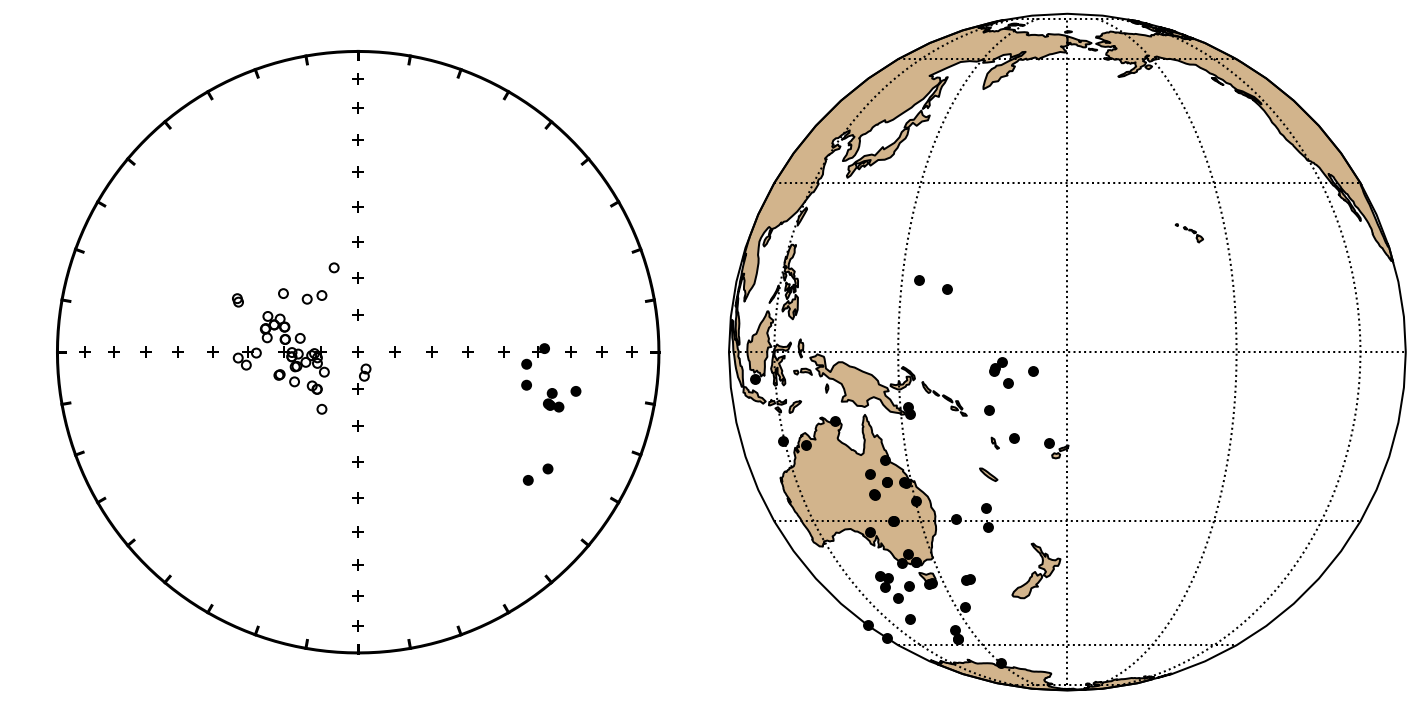

In [41]:
plot_dir_pole(Haliburton_A['dir_dec'], Haliburton_A['dir_inc'],
              Haliburton_A['plat'], Haliburton_A['plon'])

In [42]:
# AR and AN directions fail reversal test
ipmag.reversal_test_MM1990(Haliburton_A['dir_dec'], Haliburton_A['dir_inc'])

Results of Watson V test: 

Watson's V:           179.1
Critical value of V:  6.6
"Fail": Since V is greater than Vcrit, the two means can
be distinguished at the 95% confidence level.

M&M1990 classification:

Angle between data set means: 37.8
Critical angle for M&M1990:   7.2



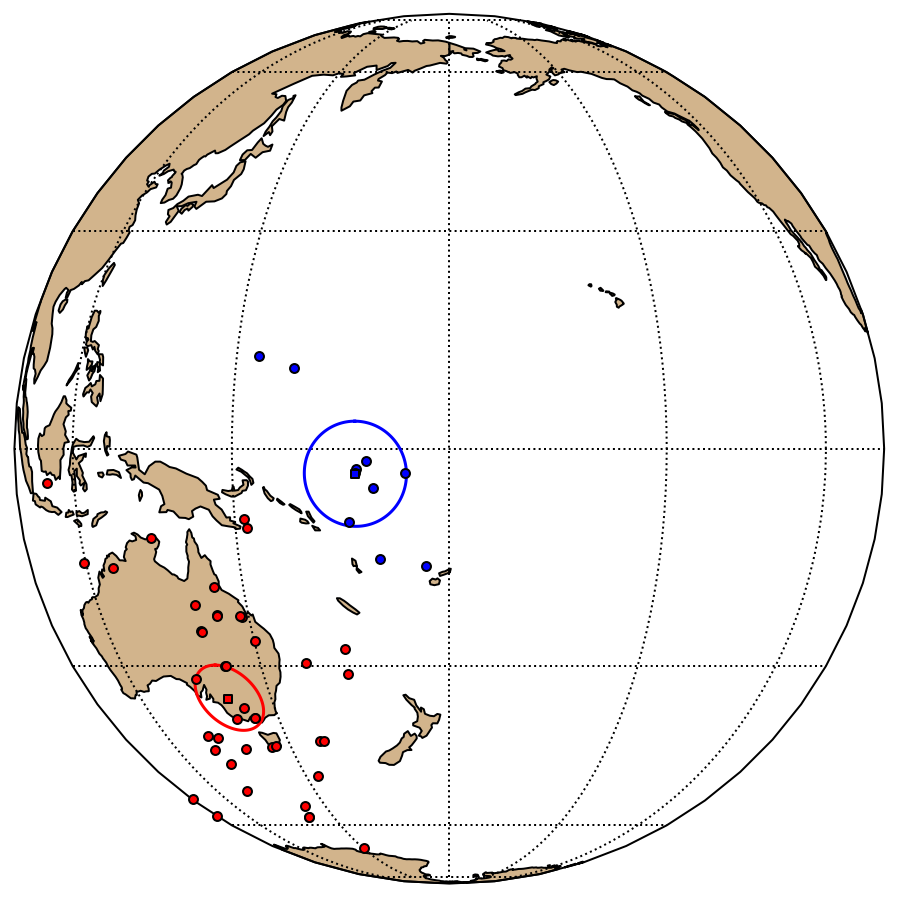

In [176]:
Haliburton_ax = ipmag.make_orthographic_map(180, 0)
ipmag.plot_vgp(Haliburton_ax, Haliburton_AN['plon'], Haliburton_AN['plat'], color='b')
ipmag.plot_vgp(Haliburton_ax, Haliburton_AR['plon'], Haliburton_AR['plat'], color='r')

ipmag.plot_pole(Haliburton_ax, Haliburton_AN_mean_pole['dec'], Haliburton_AN_mean_pole['inc'], Haliburton_AN_mean_pole['alpha95'], 
                marker = 's', color = 'b')
ipmag.plot_pole(Haliburton_ax, Haliburton_AR_mean_pole['dec'], Haliburton_AR_mean_pole['inc'], Haliburton_AR_mean_pole['alpha95'], 
                marker = 's', color = 'r')

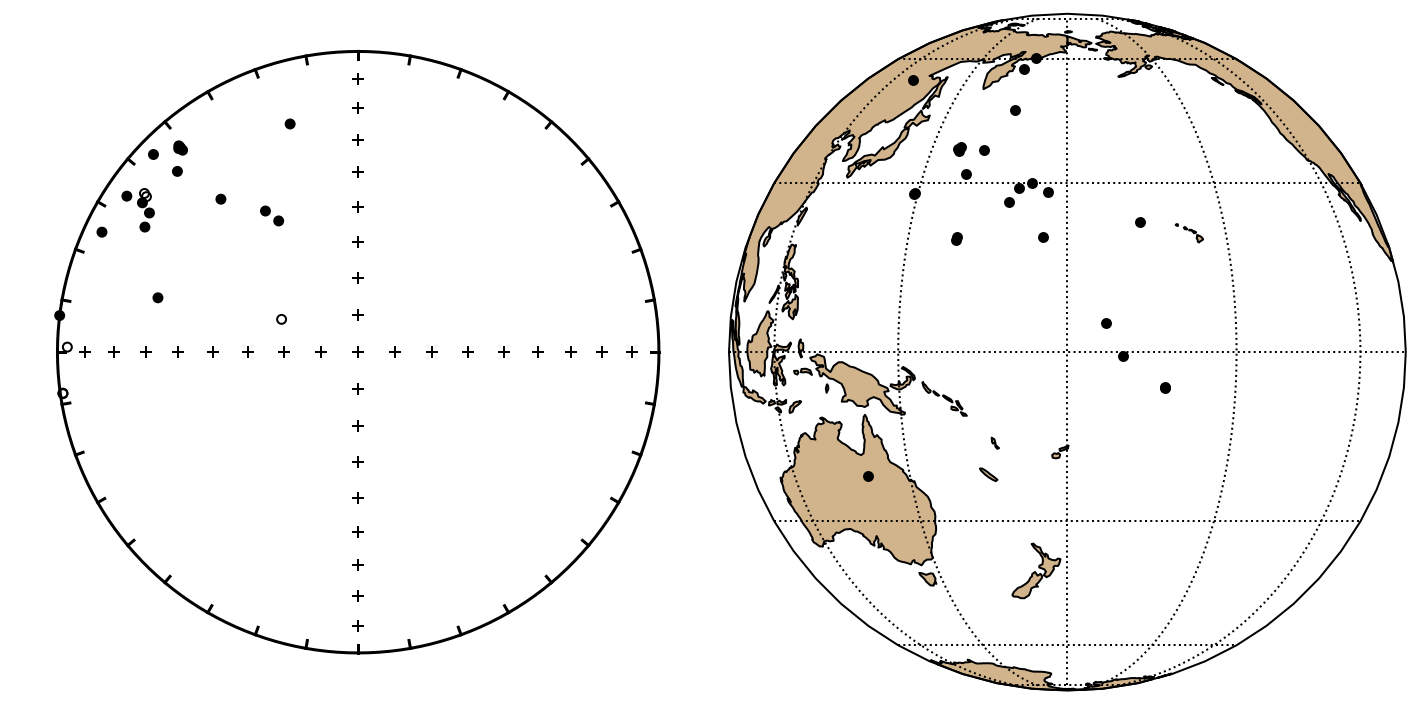

In [43]:
plot_dir_pole(Haliburton_B['dir_dec'], Haliburton_B['dir_inc'],
              Haliburton_B['vgp_lat'], Haliburton_B['vgp_lon'])

## Buchan 1978 Thanet Gabbro 
- it is in the Haliburton intrusion region 
- classic AN component and B component
- both carried by magnetite and based on Buchan 1978 and Berger 1981b interpretation both could be low temperature thermochemical acquisition
- we may consider to drop this record due to lack of pmag age data; or we can consider combining this with other Haliburton intrusions as they are regionally close
- but given that they have inconsistent thermochron ages, perhaps we just drop the Thanet discussion and not use it

In [44]:
Buchan1978a = pd.read_csv('../data/pmag_compilation/Buchan1978a.csv')
Buchan1978a = vgp_calc(Buchan1978a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Buchan1978a_A = Buchan1978a[Buchan1978a['dir_comp_name'].str.contains('A')].reset_index(drop=1)
Buchan1978a_B = Buchan1978a[Buchan1978a['dir_comp_name'].str.contains('B')].reset_index(drop=1)
Buchan1978a_A

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples  lat  lon  dir_k  \
0    T2     87.3     62.7          6.4              5   45  -78  142.0   
1    T3     73.7     54.8         13.3              3   45  -78   86.0   
2    T4     87.3     49.2         12.5              4   45  -78   54.0   
3    T5     90.9     59.1          NaN              1   45  -78    NaN   
4    T6     86.1     58.3         11.5              5   45  -78   45.0   
5    T7     92.7     65.3         12.0              4   45  -78   59.0   
6    T8     66.5     51.9         15.6              3   45  -78   63.0   
7   T10     83.6     55.1          NaN              1   45  -78    NaN   
8   T11     95.3     62.1          6.7              6   45  -78  101.0   
9   T12     79.4     59.4          8.3              3   45  -78  219.0   
10  T13     57.7     58.9          NaN              1   45  -78    NaN   
11  T14     94.0     60.0          5.2              6   45  -78  163.0   
12  T15     81.3     59.8          5.9              6   45  -78  127.0   

      vgp_lat     vgp_lon dir_comp_name  paleolatitude        plon       plat  
0   31.059046  338.879084            AN      44.090095  158.879084 -31.059046  
1   34.806827  354.494185            AN      35.328831  174.494185 -34.806827  
2   22.535157  351.358385            AN      30.081807  171.358385 -22.535157  
3   26.412409  340.955185            AN      39.876702  160.955185 -26.412409  
4   28.836079  344.274719            AN      38.992558  164.274719 -28.836079  
5   29.858358  333.239688            AN      47.389134  153.239688 -29.858358  
6   38.164410    1.561735            AN      32.524584  181.561735 -38.164410  
7   28.424020  348.699884            AN      35.630425  168.699884 -28.424020  
8   25.976249  335.639145            AN      43.360129  155.639145 -25.976249  
9   33.769986  346.551461            AN      40.212977  166.551461 -33.769986  
10  47.914606  358.159620            AN      39.653959  178.159620 -47.914606  
11  25.190145  338.443146            AN      40.893395  158.443146 -25.190145  
12  32.813742  345.145359            AN      40.665414  165.145359 -32.813742

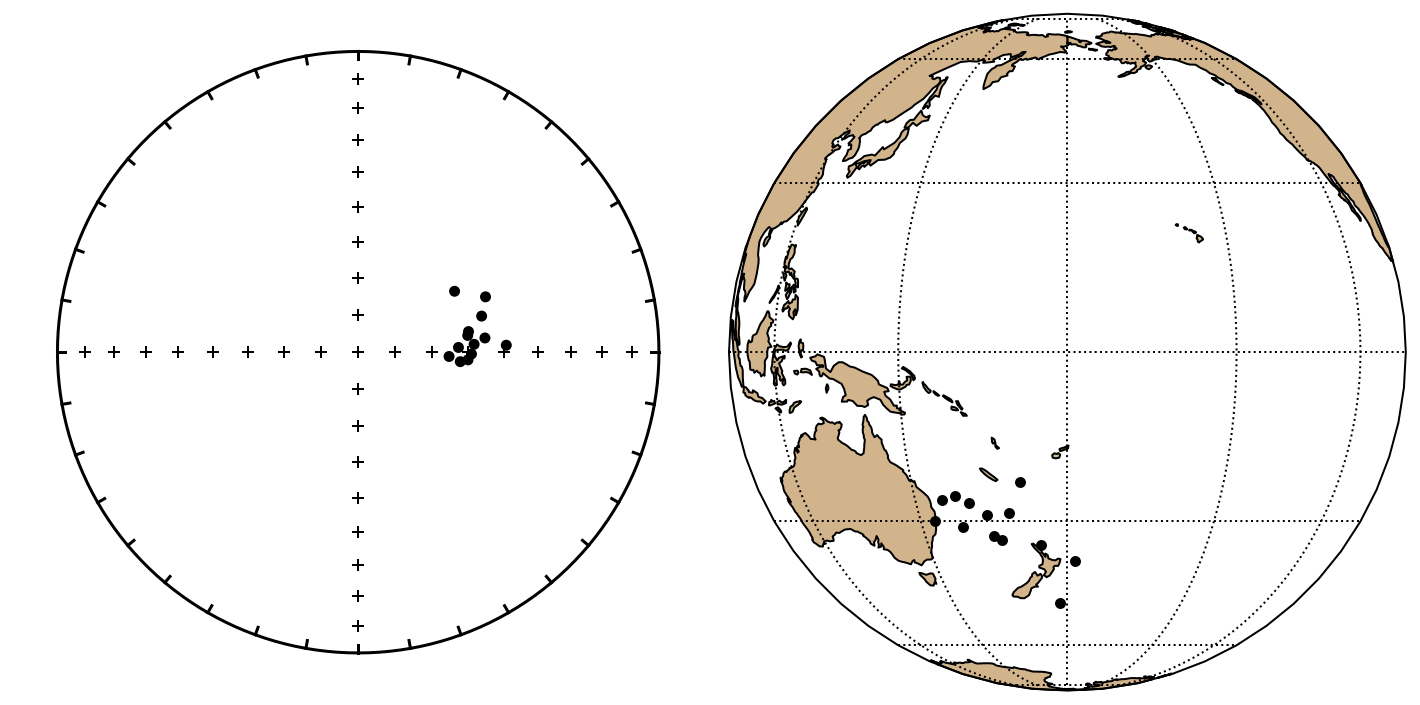

In [45]:
plot_dir_pole(Buchan1978a_A['dir_dec'], Buchan1978a_A['dir_inc'],
              Buchan1978a_A['plat'], Buchan1978a_A['plon'])

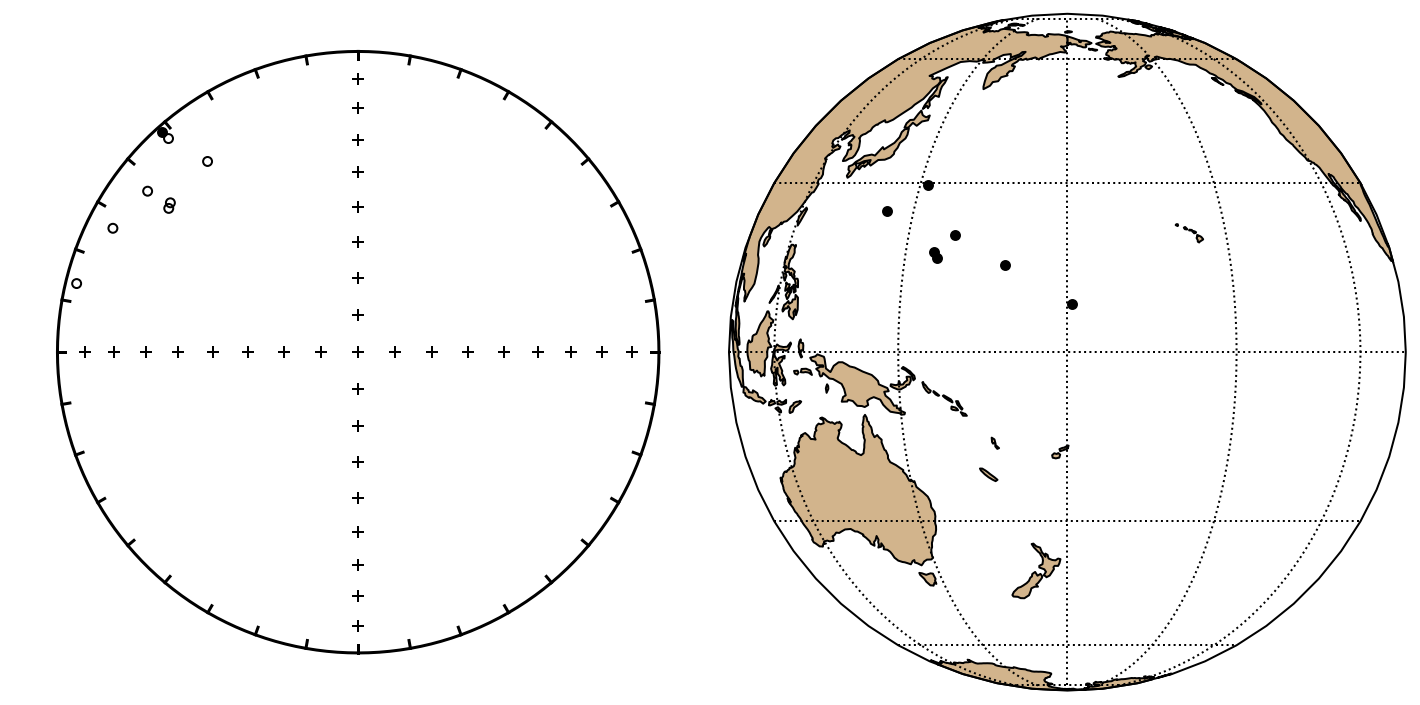

In [46]:
plot_dir_pole(Buchan1978a_B['dir_dec'], Buchan1978a_B['dir_inc'],
              Buchan1978a_B['plat'], Buchan1978a_B['plon'])

## Symons 1978 Umfraville Gabbro
- early study before Palmer but with AF they isolated AN component, not AR
- their thermal demag shows the AN is carried by magnetite
- we need to filter the data because many have large a95
- site location approximated based on map figure

In [47]:
Symons1978a = pd.read_csv('../data/pmag_compilation/Symons1978a.csv')
Symons1978a = vgp_calc(Symons1978a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Symons1978a

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples    lat    lon  dir_k  \
0      1    106.8     26.8         15.6              3  44.95 -77.75   63.6   
1      2     88.5     37.9         43.7              3  44.95 -77.75    9.0   
2      3     90.4     50.1         13.0              5  44.95 -77.75   35.5   
3      4    109.4     23.7          3.5              5  44.95 -77.75  485.0   
4      5     22.4     43.5         27.5              5  44.95 -77.75    8.7   
5      6     93.8     37.8          8.2              5  44.95 -77.75   87.8   
6      8    101.8     51.5          9.2              5  44.95 -77.75   69.6   
7      9    108.8     45.1          4.4              5  44.95 -77.75  309.0   
8     10     29.9     80.0        161.0              4  44.95 -77.75    1.4   
9     11    113.9     61.9          6.8              5  44.95 -77.75  127.0   
10    12    104.4     61.2         77.1              4  44.95 -77.75    2.0   
11    13    107.9     61.9         60.6              4  44.95 -77.75    3.3   
12    14     83.9     47.7         24.7              4  44.95 -77.75   14.8   
13    15     92.6     69.1         52.4              5  44.95 -77.75    3.1   
14    16    102.1     45.7         23.4              5  44.95 -77.75   11.7   
15    17     91.0     51.4         13.9              3  44.95 -77.75   80.0   

      vgp_lat     vgp_lon dir_comp_name  paleolatitude        plon       plat  
0   -1.451038  350.447633            AN      14.174649  170.447633   1.451038  
1   15.874383  357.833237            AN      21.267947  177.833237 -15.874383  
2   20.998917  349.071494            AN      30.879141  169.071494 -20.998917  
3   -4.482484  349.785931            AN      12.379252  169.785931   4.482484  
4   63.381331   52.039690            AN      25.383511  232.039690 -63.381331  
5   12.224002  354.400761            AN      21.198273  174.400761 -12.224002  
6   14.681748  341.199423            AN      32.152900  161.199423 -14.681748  
7    6.487178  340.632705            AN      26.645135  160.632705  -6.487178  
8   60.495598  301.921641            AN      70.574600  121.921641 -60.495598  
9   15.879065  326.183103            AN      43.119340  146.183103 -15.879065  
10  20.190734  332.020585            AN      42.286414  152.020585 -20.190734  
11  18.912421  329.492740            AN      43.119340  149.492740 -18.912421  
12  23.962575  354.734224            AN      28.788479  174.734224 -23.962575  
13  32.818855  328.427822            AN      52.630096  148.427822 -32.818855  
14  10.960238  344.671347            AN      27.129197  164.671347 -10.960238  
15  21.379728  347.752463            AN      32.060526  167.752463 -21.379728

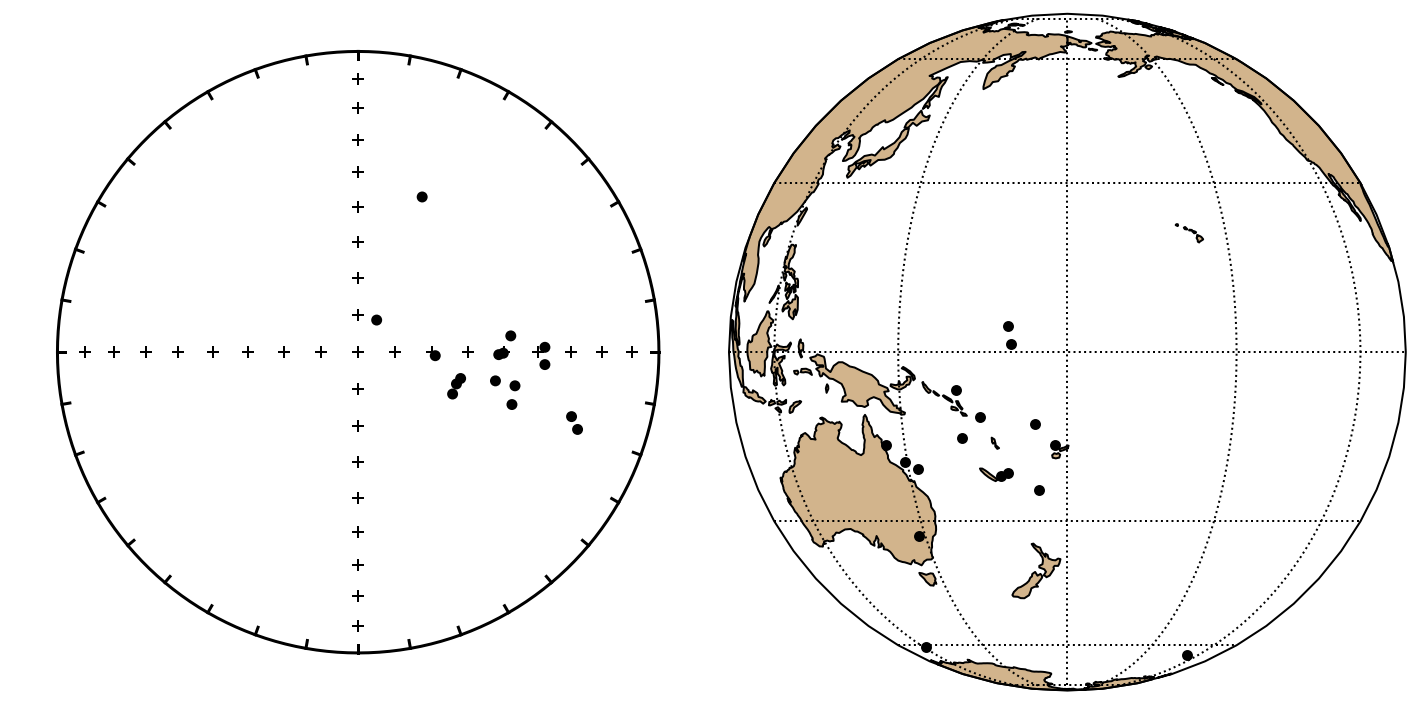

In [48]:
plot_dir_pole(Symons1978a['dir_dec'], Symons1978a['dir_inc'],
              Symons1978a['plat'], Symons1978a['plon'])

## Palmer 1979 Umfraville Gabbro

- Bancroft terrane pole
- has both AR and AN components
- site location from map figure for recalculating pole position
- we should regroup into AR and AN and calculate mean

In [55]:
Palmer1979a = pd.read_csv('../data/pmag_compilation/Palmer1979a.csv')
Palmer1979a = vgp_calc(Palmer1979a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Palmer1979a = Palmer1979a[~Palmer1979a['site'].str.contains('U12|U13')].reset_index(drop=1)
Palmer1979a

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples    lat    lon  dir_k  \
0      U2      138       52          7.3              2  44.95 -77.75   1167   
1      U3      278      -63         24.5              2  44.95 -77.75    106   
2      U4      112       68         19.8              3  44.95 -77.75     40   
3      U5       96       41         14.5              2  44.95 -77.75    298   
4      U6      280      -54         10.9              2  44.95 -77.75    531   
5      U7      124       59         31.2              3  44.95 -77.75     17   
6      U8      135       34          6.1              2  44.95 -77.75   1685   
7      U9       43       63         11.7              2  44.95 -77.75    456   
8     U10       93       56          5.8              2  44.95 -77.75   1866   
9     U11      117       25         12.8              2  44.95 -77.75    380   
10    U14      124       51          7.5              2  44.95 -77.75   1103   
11    U15      103       18          NaN              2  44.95 -77.75     13   
12    U16      107       24          NaN              2  44.95 -77.75     23   
13    U17       91       62         12.3              2  44.95 -77.75    417   
14    SP6      106       29          5.5              4  44.95 -77.75    276   
15    SP8      108       39          6.3              4  44.95 -77.75    216   
16    SP9      113       26         15.9              4  44.95 -77.75     34   
17   SP10      100       44         11.9              3  44.95 -77.75    109   
18   SP12       59       36         17.1              4  44.95 -77.75     30   
19   SP13      130       51          NaN              4  44.95 -77.75      6   
20   SP13      145       46         12.5              4  44.95 -77.75     55   
21   SP14      113       27         10.8              4  44.95 -77.75     73   
22   SP16      134       46         11.0              4  44.95 -77.75     70   
23  SP17a      280      -58          3.2              2  44.95 -77.75   6141   
24  SP17a      278      -55          1.3              2  44.95 -77.75  36477   
25  SP17a       97       61          NaN              2  44.95 -77.75      6   
26  SP17b       97       48          NaN              2  44.95 -77.75      6   

      vgp_lat     vgp_lon dir_comp_name  paleolatitude        plon       plat  
0   -3.564240  316.630719            AN      32.618057  136.630719   3.564240  
1  -25.120696  153.568934            AR     -44.459398  153.568934 -25.120696  
2   22.512322  321.359962            AN      51.059971  141.359962 -22.512322  
3   12.343618  351.265345            AN      23.491856  171.265345 -12.343618  
4  -17.414469  160.486874            AR     -34.535397  160.486874 -17.414469  
5    8.493414  322.365058            AN      39.765187  142.365058  -8.493414  
6  -14.384162  326.015779            AN      18.636898  146.015779  14.384162  
7   59.798376  357.638048            AN      44.459398  177.638048 -59.798376  
8   23.014506  342.898028            AN      36.548819  162.898028 -23.014506  
9   -8.771207  343.652209            AN      13.124268  163.652209   8.771207  
10   1.973211  327.146203            AN      31.693197  147.146203  -1.973211  
11  -2.513344  356.548957            AN       9.227645  176.548957   2.513344  
12  -2.777497  351.405988            AN      12.550216  171.405988   2.777497  
13  28.358239  338.114675            AN      43.239577  158.114675 -28.358239  
14   0.040400  350.121568            AN      15.490954  170.121568  -0.040400  
15   3.579310  344.288378            AN      22.042632  164.288378  -3.579310  
16  -5.812467  346.266237            AN      13.705006  166.266237   5.812467  
17  11.333554  347.003071            AN      25.773313  167.003071 -11.333554  
18  35.719877   19.350493            AN      19.964629  199.350493 -35.719877  
19  -0.911449  322.934206            AN      31.693197  142.934206   0.911449  
20 -10.951764  313.501824            AN      27.373547  133.501824  10.951764  
21  

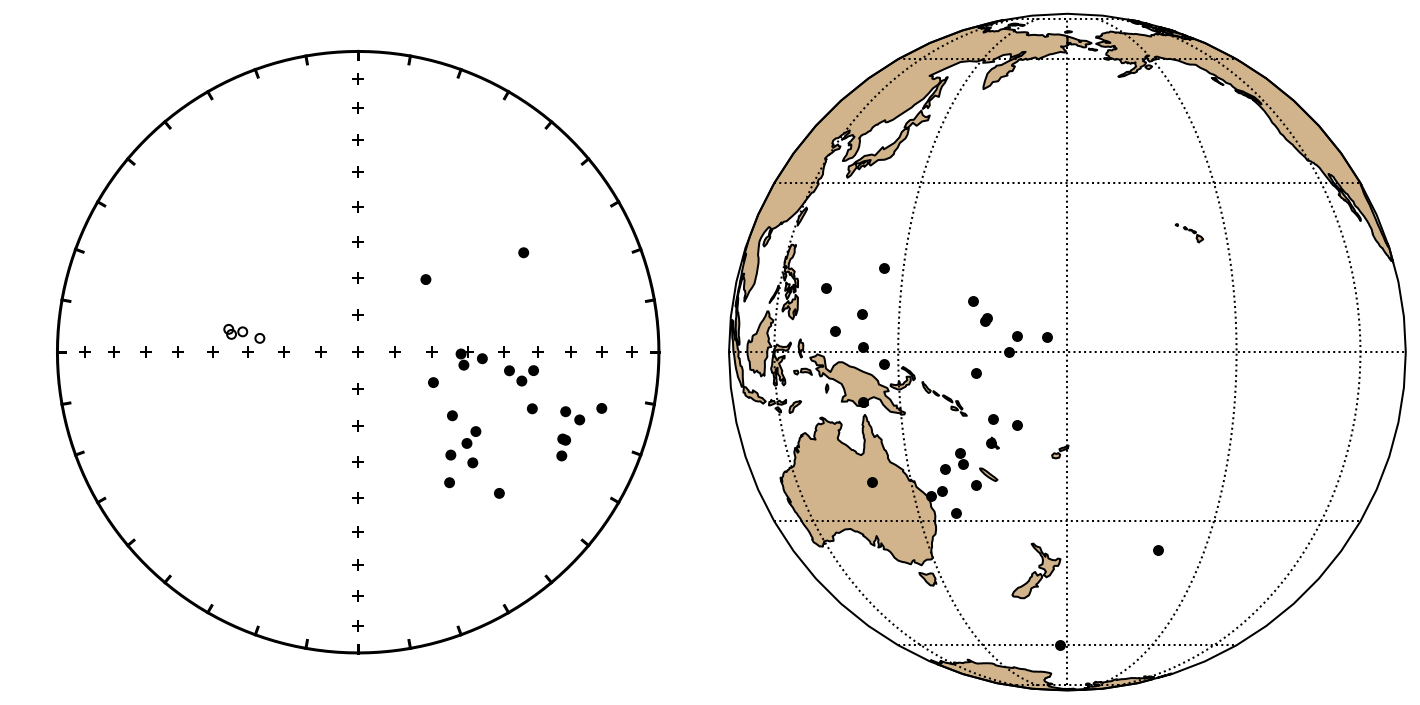

In [56]:
plot_dir_pole(Palmer1979a['dir_dec'], Palmer1979a['dir_inc'],
              Palmer1979a['plat'], Palmer1979a['plon'])

## Umfraville Gabbro

In [59]:
UG = pd.concat([Symons1978a, Palmer1979a]).reset_index(drop=1)

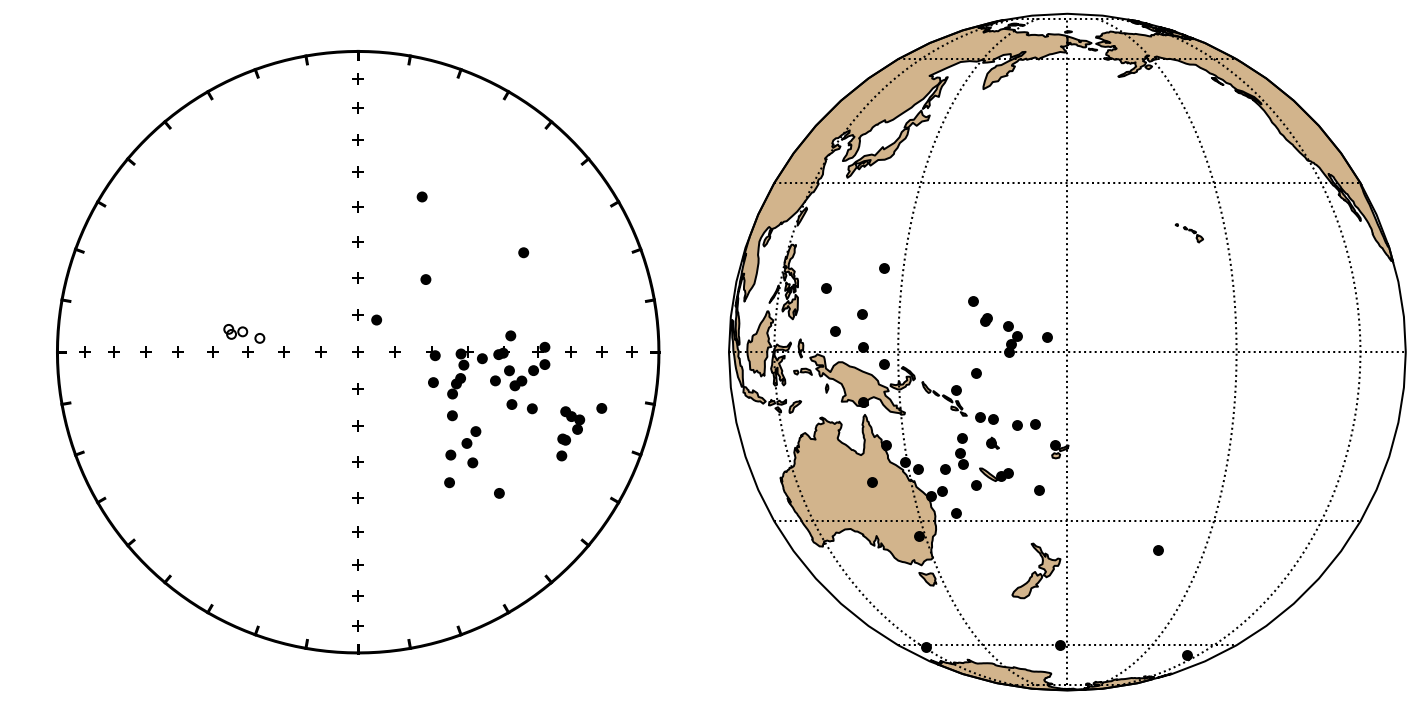

In [60]:
plot_dir_pole(UG['dir_dec'], UG['dir_inc'],
              UG['plat'], UG['plon'])

## Dunlop 1985 Cordova Gabbro
- may be combined with Tudor Gabbro directions for A
- it does have more complicated components including B and C
- B is magnetite later slow cooling component and C is Paleozoic overprint or hydrothermal chemical remanence
- location estiamted from map, recalcualte pole means

In [66]:
Dunlop1985a = pd.read_csv('../data/pmag_compilation/Dunlop1985a.csv')
Dunlop1985a = vgp_calc(Dunlop1985a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Dunlop1985a_A = Dunlop1985a[Dunlop1985a['dir_comp_name'] == 'AN+AR'].reset_index(drop=1)
Dunlop1985a_B = Dunlop1985a[Dunlop1985a['dir_comp_name'] == 'B'].reset_index(drop=1)
Dunlop1985a_C = Dunlop1985a[Dunlop1985a['dir_comp_name'] == 'C'].reset_index(drop=1)
Dunlop1985a_A

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples   lat    lon   dir_k  \
0      2    317.0    -64.0          NaN              2  44.5 -77.83    57.0   
1      3    285.0    -66.5          NaN              2  44.5 -77.83  1054.0   
2      4    287.5    -44.0          7.0              4  44.5 -77.83   163.0   
3      5    308.0    -39.5          NaN              2  44.5 -77.83    78.0   
4      6    284.0    -67.5         10.0              3  44.5 -77.83   151.0   
5      8    299.0    -50.0          NaN              1  44.5 -77.83     NaN   
6      9    292.5    -65.0          NaN              2  44.5 -77.83    14.0   
7     11    264.0    -61.0          NaN              2  44.5 -77.83    62.0   
8     12    300.5    -55.0         14.0              4  44.5 -77.83    43.0   
9     13    297.0    -56.0         20.5              3  44.5 -77.83    36.0   
10    15    262.5    -67.5          NaN              2  44.5 -77.83    55.0   
11    16    308.0    -42.0         16.5              5  44.5 -77.83    22.0   
12    17    298.0    -55.5          NaN              2  44.5 -77.83   209.0   
13    18    267.5    -68.5          NaN              1  44.5 -77.83     NaN   
14    19    303.5    -49.0         10.5              7  44.5 -77.83    34.0   
15    20    298.0    -42.0          NaN              2  44.5 -77.83    21.0   
16    22    292.5    -43.5         28.0              3  44.5 -77.83    20.0   
17    23    292.5    -44.5          NaN              2  44.5 -77.83    10.0   

      vgp_lat     vgp_lon dir_comp_name  paleolatitude        plon       plat  
0   -7.902607  130.906715         AN+AR     -45.711564  130.906715  -7.902607  
1  -24.064027  146.131527         AN+AR     -48.988971  146.131527 -24.064027  
2   -6.408769  161.966413         AN+AR     -25.773313  161.966413  -6.408769  
3    7.983800  149.534998         AN+AR     -22.399899  149.534998   7.983800  
4  -25.446894  145.445516         AN+AR     -50.360728  145.445516 -25.446894  
5   -3.539443  151.001714         AN+AR     -30.789733  151.001714  -3.539443  
6  -19.051955  143.978030         AN+AR     -46.996928  143.978030 -19.051955  
7  -31.656515  162.346756         AN+AR     -42.051214  162.346756 -31.656515  
8   -6.471712  147.056423         AN+AR     -35.529645  147.056423  -6.471712  
9   -9.048177  148.622967         AN+AR     -36.548819  148.622967  -9.048177  
10 -36.808721  154.354165         AN+AR     -50.360728  154.354165 -36.808721  
11   6.469695  148.485578         AN+AR     -24.237370  148.485578   6.469695  
12  -8.138407  148.328328         AN+AR     -36.036059  148.328328  -8.138407  
13 -34.738168  150.964415         AN+AR     -51.768219  150.964415 -34.738168  
14  -0.470971  148.461758         AN+AR     -29.906833  148.461758  -0.470971  
15   1.008388  155.803703         AN+AR     -24.237370  155.803703   1.008388  
16  -3.087681  158.879721         AN+AR     -25.383511  158.879721  -3.087681  
17  -3.676312  158.361541         AN+AR     -26.167131  158.361541  -3.676312

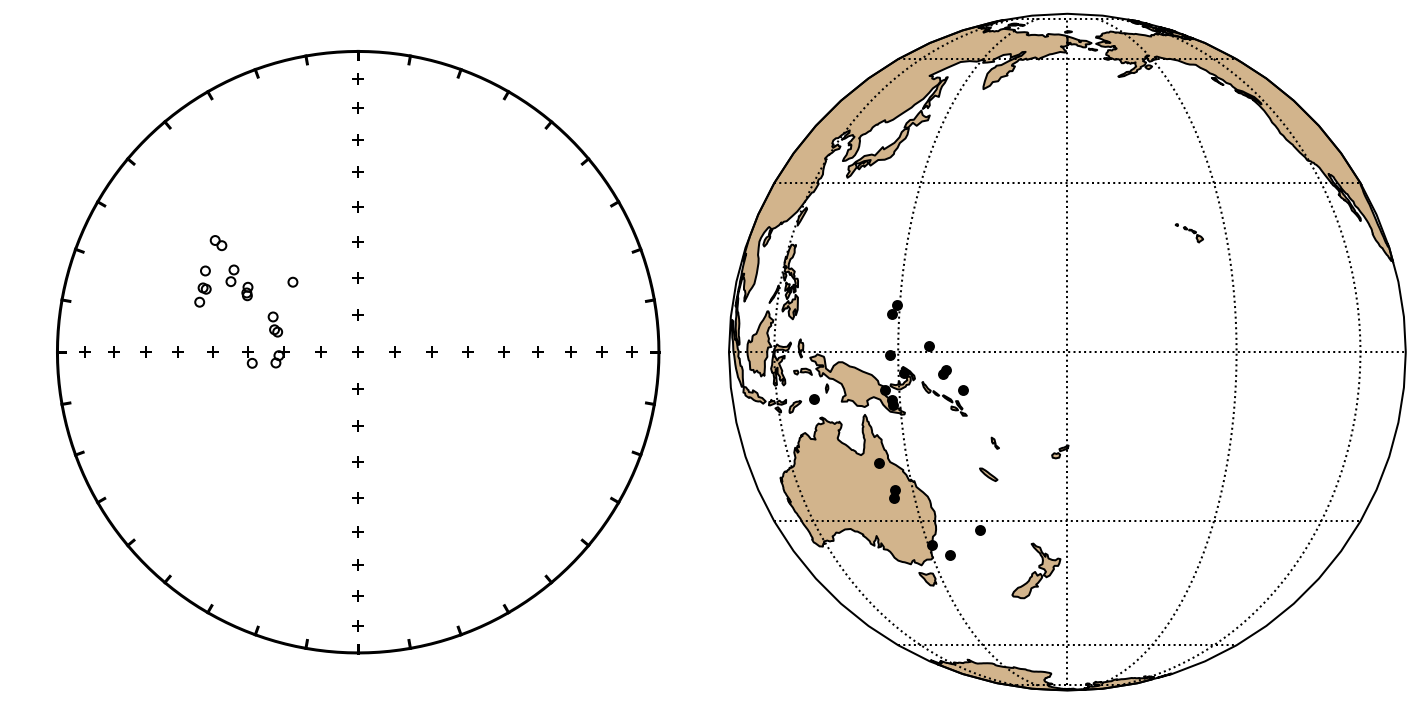

In [67]:
plot_dir_pole(Dunlop1985a_A['dir_dec'], Dunlop1985a_A['dir_inc'],
              Dunlop1985a_A['plat'], Dunlop1985a_A['plon'])

## Brett 2008 Central Metasedimentary Belt

- we can compare their results with the Central Gneiss Belt data from Alvarez 1998 to compare the two belts drections - infer for timing of magnetization/exhumation/cooling of the two general regions
- we will not take direction groups by terrane, but instead take means by AR and AN and B components, since there is strong evidence in the paper thatn there is no significant differential uplift history in the CMB and the AR and AN is antipodal roughly - they may not past a reversal test but that is likely caused bu anisotropy which is not tested in the study.
- the location info is inferred general average locality

In [73]:
Brett2008a = pd.read_csv('../data/pmag_compilation/Brett2008a.csv')
Brett2008a = Brett2008a[Brett2008a['terrane'] != 'Elsevir']
Brett2008a = Brett2008a[Brett2008a['site'] != 26].reset_index(drop=1)
Brett2008a = vgp_calc(Brett2008a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Brett2008a_A = Brett2008a[Brett2008a['dir_comp_name'].str.contains('A')].reset_index(drop=1)
Brett2008a_B = Brett2008a[Brett2008a['dir_comp_name'] == 'B'].reset_index(drop=1)
Brett2008a_A

site       terrane  dir_dec  dir_inc  dir_alpha95  dir_n_samples   lat  \
0      1     Frontenac      149       72           13              5  44.7   
1      1     Frontenac      297      -56            5              7  44.7   
2      2     Frontenac       98       60           10              8  44.7   
3      3     Frontenac       65       65           22              4  44.7   
4     12     Frontenac       76       62           11             12  44.7   
5     14     Frontenac       40       64            7             13  44.7   
6     45     Frontenac      131       74           12              9  44.7   
7     46     Frontenac       57       59            5             24  44.7   
8     16  Sharbot Lake       89       42           12              9  44.7   
9     17  Sharbot Lake       63       67           11             15  44.7   
10    19  Sharbot Lake       49       72            6             14  44.7   
11    19  Sharbot Lake      298      -47           11              7  44.7   
12    20  Sharbot Lake      106       60           11             19  44.7   
13    22  Sharbot Lake       80       46           11             18  44.7   
14    28  Sharbot Lake      283      -56            3              3  44.7   
15    30  Sharbot Lake      270      -42            4             14  44.7   
16    47  Sharbot Lake      103       48           12              5  44.7   
17    21       Mazinaw      102       49           14              4  44.7   
18    21       Mazinaw      269      -40            8             12  44.7   
19    25       Mazinaw      317      -64            5             10  44.7   
20    27       Mazinaw       75       51            7             10  44.7   
21    27       Mazinaw      292      -57            6             11  44.7   
22    32       Mazinaw       48       37           11              5  44.7   
23    34       Mazinaw       78       59            9             12  44.7   
24    34       Mazinaw      280      -46            4              8  44.7   

      lon  dir_k    vgp_lat     vgp_lon dir_comp_name  paleolatitude  \
0  -76.75     38  14.940184  300.135488            AN      56.982602   
1  -76.75    148  -9.185937  149.726234            AR     -36.548819   
2  -76.75     32  22.687222  337.478169            AN      40.893395   
3  -76.75     18  45.995606  346.094486            AN      46.996928   
4  -76.75     16  37.382379  346.069677            AN      43.239577   
5  -76.75     33  62.095009  356.795616            AN      45.711564   
6  -76.75     21  22.221214  307.177498            AN      60.166127   
7  -76.75     36  48.374005  359.296047            AN      39.765187   
8  -76.75     22  17.461674  356.142979            AN      24.237370   
9  -76.75     14  48.164730  343.080914            AN      49.670420   
10 -76.75     51  57.554099  333.291772            AN      56.982602   
11 -76.75     30  -2.194507  154.393476            AR     -28.199513   
12 -76.75     10  18.202486  333.150183            AN      40.893395   
13 -76.75     11  25.659506  359.231168            AN      27.373547   
14 -76.75    977 -16.883410  158.136918            AR     -36.548819   
15 -76.75    110 -16.783500  175.505154            AR     -24.237370   
16 -76.75     41  11.635994  343.675723            AN      29.043688   
17 -76.75     43  12.861912  343.675717            AN      29.906833   
18 -76.75     33 -16.473283  177.290349            AR     -22.760476   
19 -76.75     82  -8.077963  132.000216            AR     -45.711564   
20 -76.75     52  31.740760  358.360127            AN      31.693197   
21 -76.75     63 -12.599365  152.082349            AR     -37.593842   
22 -76.75     52  43.874231   28.517615            AN      20.645256   
23 -76.75     26  34.299472  348.775568            AN      39.765187   
24 -76.75    126 -12.345448  166.788997            AR     -27.373547   

          plon       plat  
0   120.135488 -14.940184  
1   149.726234  -9.185937  
2   157.478169 -22

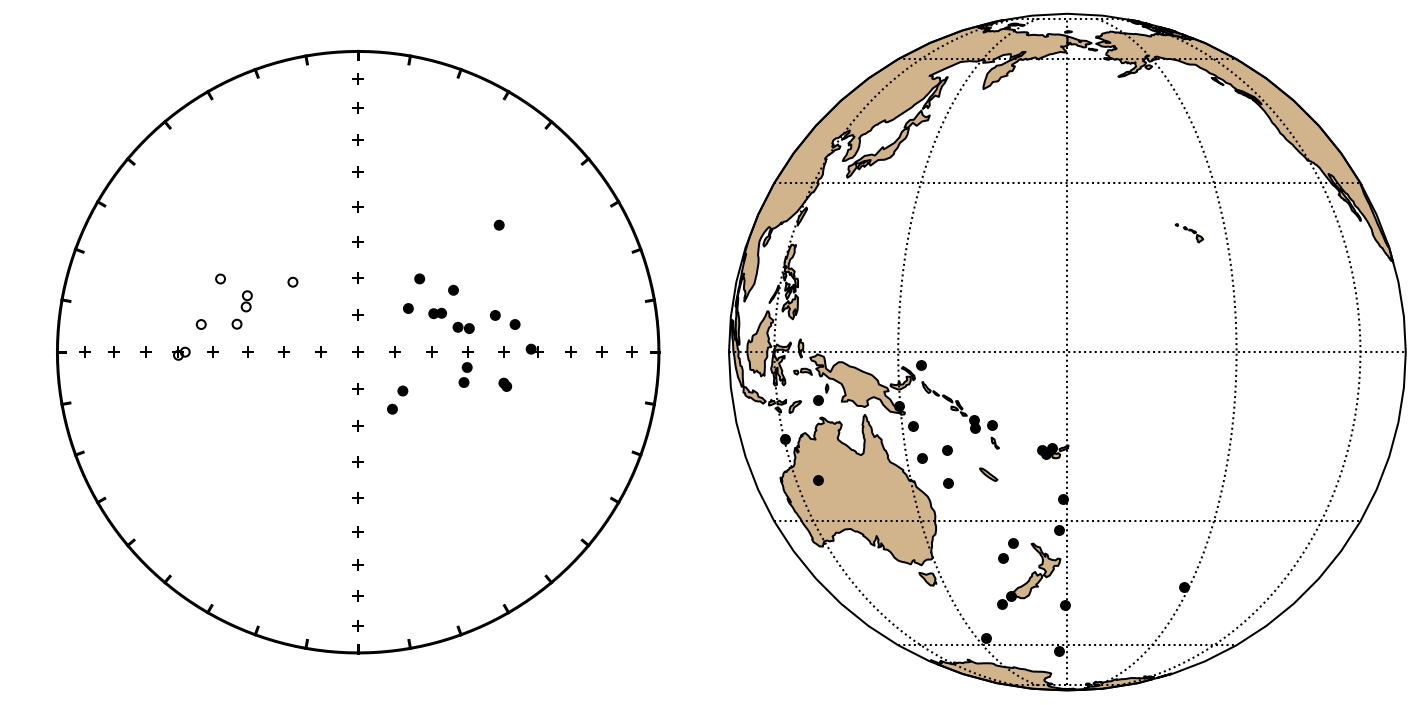

In [74]:
plot_dir_pole(Brett2008a_A['dir_dec'], Brett2008a_A['dir_inc'],
              Brett2008a_A['plat'], Brett2008a_A['plon'])

## Halls 2015 Northbook  dike
- Northbrook dyke

- These are site level unpublished data from Halls 2015
- These are all AR components. will filter out these site-mean poles from the site-mean compilation file and plot together.

In [75]:
Halls2015a_CMB = Halls2015a[Halls2015a['Halls_Code'].isin(['ND'])].reset_index(drop=1)
Halls2015a_CMB

Halls_Code         ROCKNAME dir_comp_name    lat    lon  B   N  dir_dec  \
0         ND  Northbrook dyke            AR  44.74 -77.17  6 NaN    303.0   

   dir_inc  dir_k  ...  vgp_lat  vgp_lon    dp    dm  pole_alpha95  \
0    -65.0   68.0  ...     14.6    319.2  10.4  12.9          11.6   

   ChRM_mineralogy blocking_min blocking_max blocking_comment  \
0              NaN          NaN          NaN              NaN   

                              pmag_reference  
0  H.C.Halls & A. Lovette, Unpublished Data   

[1 rows x 21 columns]

## combine data from CMB

In [79]:
CMB = pd.concat([Park1972a, Irving1972a, Palmer1973a, Dunlop1985b, Dubois1962a, 
                 Buchan_73_76_A, Warnock2000a_AR, Buchan1978a_A, Symons1978a, 
                 Palmer1979a, Dunlop1985a_A, Brett2008a_A, Halls2015a_CMB]).reset_index(drop=1)
CMB_AN = CMB[CMB['dir_inc'] > 0].reset_index(drop=1)
CMB_AR = CMB[CMB['dir_inc'] < 0].reset_index(drop=1)

CMB_AN_pole_mean = ipmag.fisher_mean(CMB_AN['vgp_lon'], CMB_AN['vgp_lat'])
CMB_AR_pole_mean = ipmag.fisher_mean(CMB_AR['vgp_lon'], CMB_AR['vgp_lat'])

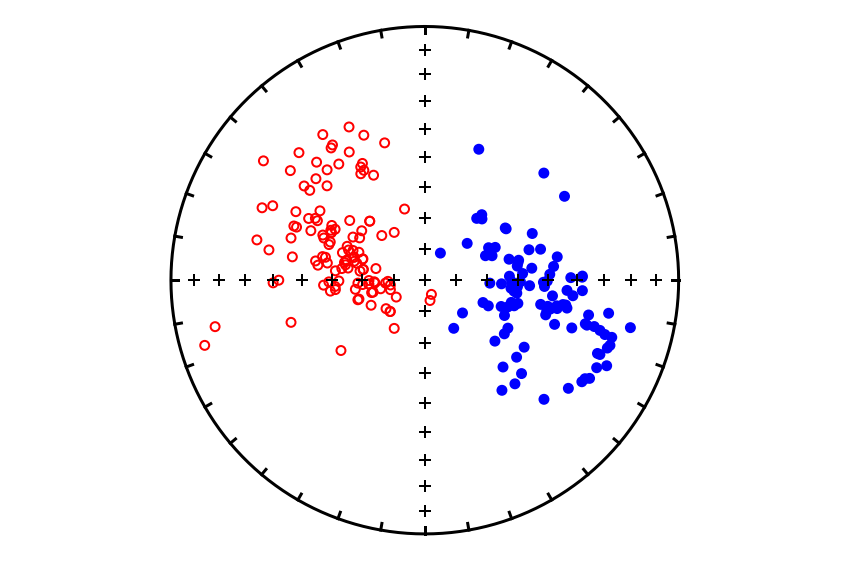

In [80]:
ipmag.plot_net()
ipmag.plot_di(CMB_AR['dir_dec'], CMB_AR['dir_inc'], color = 'r')
ipmag.plot_di(CMB_AN['dir_dec'], CMB_AN['dir_inc'], color = 'b')

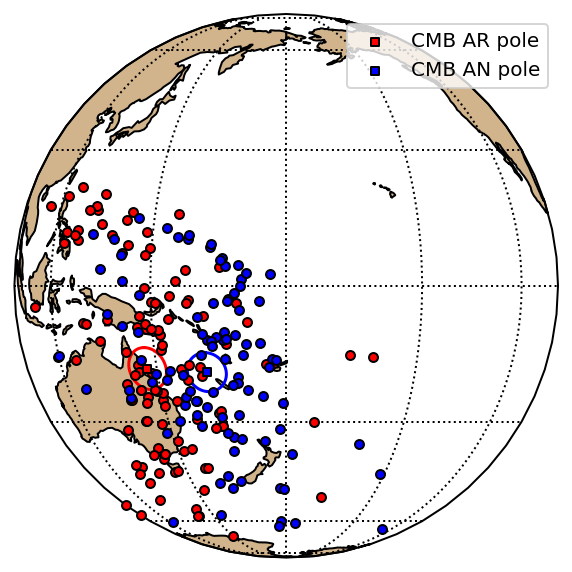

In [81]:
CMB_ax = ipmag.make_orthographic_map(180, 0, figsize=(5,5))
ipmag.plot_vgp(CMB_ax, CMB_AR['vgp_lon'], CMB_AR['vgp_lat'], color = 'r')
ipmag.plot_vgp(CMB_ax, 180+CMB_AN['vgp_lon'], -CMB_AN['vgp_lat'], color = 'b')

ipmag.plot_pole(CMB_ax, CMB_AR_pole_mean['dec'], CMB_AR_pole_mean['inc'], CMB_AR_pole_mean['alpha95'], 
                marker = 's', color = 'r', label = 'CMB AR pole')
ipmag.plot_pole(CMB_ax, 180+CMB_AN_pole_mean['dec'], -CMB_AN_pole_mean['inc'], CMB_AN_pole_mean['alpha95'],
                marker = 's', color = 'b', label = 'CMB AN pole')
plt.legend()
plt.show()

In [88]:
ipmag.reversal_test_MM1990(CMB['vgp_lon'], CMB['vgp_lat'])

Results of Watson V test: 

Watson's V:           31.0
Critical value of V:  6.0
"Fail": Since V is greater than Vcrit, the two means can
be distinguished at the 95% confidence level.

M&M1990 classification:

Angle between data set means: 13.6
Critical angle for M&M1990:   6.0



# Adirondack 

- Brown 2012


## Brown 2012 Adirondack Highlands
- show both AR and AN directions
- show extensive hemo-ilmenite exsolutions
- sho rutile being a product in the hemo-ilmenite exsolutions thus they could be crsytallization age not cooling thermochron

In [84]:
Brown2012a = pd.read_csv('../data/pmag_compilation/Brown2012a.csv')
Brown2012a

location   site   N  dir_inc  dir_dec     k  \
0                    microcline gneiss    AD1   6    -62.3    232.1   100   
1                    microcline gneiss    AD2   4    -62.9    257.8    97   
2                    microcline gneiss    AD5  10    -51.5    292.2    22   
3                    microcline gneiss    AD6  10    -67.8    271.2   260   
4                    microcline gneiss   AD11   7     44.8     98.1   120   
5                    microcline gneiss   AD15   3     68.9    138.7   351   
6                    microcline gneiss   AD18   5     55.3    111.6   165   
7                    microcline gneiss   AD21   7    -64.1    318.4   655   
8                    microcline gneiss   AD22   5    -63.3    282.3   113   
9                    microcline gneiss   AD26   5     76.9    162.9   760   
10                   microcline gneiss   AD34   7    -61.1    262.7    62   
11                   microcline gneiss   AD35   3    -58.6    309.9   238   
12                   microcline gneiss   AD36   5    -51.2    316.9    55   
13                   microcline gneiss   AD40   3    -55.6    294.2   130   
14            metamorphic anorthosites   AD12   5    -61.5    304.4    44   
15            metamorphic anorthosites   AD28   5     51.2    101.6    67   
16            metamorphic anorthosites   AD32   3    -87.5    182.2   926   
17            metamorphic anorthosites   AD33   5    -65.6    290.4   153   
18            metamorphic anorthosites   ADH9   5    -75.6    312.8   210   
19            metamorphic anorthosites  ADH10   4    -76.0    279.5   177   
20            metamorphic anorthosites  ADH12   5    -73.3    240.7   798   
21            metamorphic anorthosites  ADH32   6     43.9    100.3   107   
22            metamorphic anorthosites  ADH33   6     46.6     82.5    16   
23            metamorphic anorthosites  ADH34   6    -73.3    240.7    46   
24            metamorphic anorthosites  ADH35   6     53.9    108.0    25   
25        associated metamorphic rocks   ADH8   4    -75.6    283.1   117   
26        associated metamorphic rocks  ADH18   4     72.8    146.3    33   
27        associated metamorphic rocks  ADH19   4    -68.9    264.9    72   
28  post-metamorphic fayalite granites    AD9   7    -75.6    271.8   289   
29  post-metamorphic fayalite granites   AD10   4    -78.3    269.7  2409   
30  post-metamorphic fayalite granites   AD20   4    -76.4    317.3  2157   
31  post-metamorphic fayalite granites   AD37   5    -74.5    291.0    99   
32  post-metamorphic fayalite granites   AD38   7    -69.9    320.7   244   
33  post-metamorphic fayalite granites   ADH4   4    -75.7    286.3   847   
34  post-metamorphic fayalite granites   ADH5   4    -78.7    309.8  1406   
35  post-metamorphic fayalite granites  ADH20   5     71.7    118.7   177   

     a95  vgp_lat  vgp_lon   lat  lon dir_comp_name  
0    6.7    -53.1    175.8  44.2  -74            AR  
1    9.4    -36.4    164.3  44.2  -74            AR  
2   10.6     -8.0    157.4  44.2  -74            AR  
3    3.0    -31.9    152.1  44.2  -74            AR  
4    5.5     12.6    349.3  44.2  -74            AN  
5    6.6     12.7    308.5  44.2  -74            AN  
6    6.0     11.0    334.2  44.2  -74            AN  
7    2.4     -7.1    131.8  44.2  -74            AR  
8    7.2    -22.4    152.6  44.2  -74            AR  
9    2.8     19.9    291.6  44.2  -74            AN  
10   7.7    -32.3    164.4  44.2  -74            AR  
11   8.0     -4.8    140.6  44.2  -74            AR  
12  10.4      4.6    139.6  44.2  -74            AR  
13  10.9     -9.8    152.4  44.2  -74            AR  
14  11.7    -10.0    142.0  44.2  -74            AR  
15   9.4     14.1    343.1  44.2  -74            AN  
16   4.1    -49.1    104.3  44.2  -74            AR  
17   6.2    -20.3    146.2  44.2  -74            AR  
18   4.3    -23.5    128.0  44.2  -74            AR  
19   5.3    -19.5    105.6  44.2  -74            AR  
20   2.2    -41.6    130.1  44.2  -74         

## data from Adirondack

In [86]:
Adirondack_AN = Brown2012a[Brown2012a['dir_inc'] > 0].reset_index(drop=1)
Adirondack_AR = Brown2012a[Brown2012a['dir_inc'] < 0].reset_index(drop=1)

Adirondack_AN_pole_mean = ipmag.fisher_mean(Adirondack_AN['vgp_lon'], Adirondack_AN['vgp_lat'])
Adirondack_AR_pole_mean = ipmag.fisher_mean(Adirondack_AR['vgp_lon'], Adirondack_AR['vgp_lat'])

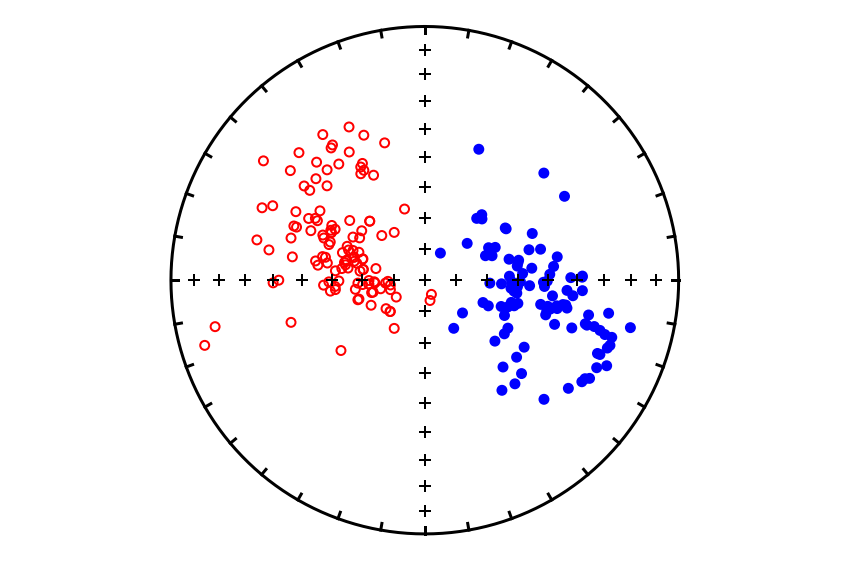

In [80]:
ipmag.plot_net()
ipmag.plot_di(Adirondack_AR['dir_dec'], Adirondack_AR['dir_inc'], color = 'r')
ipmag.plot_di(Adirondack_AN['dir_dec'], Adirondack_AN['dir_inc'], color = 'b')

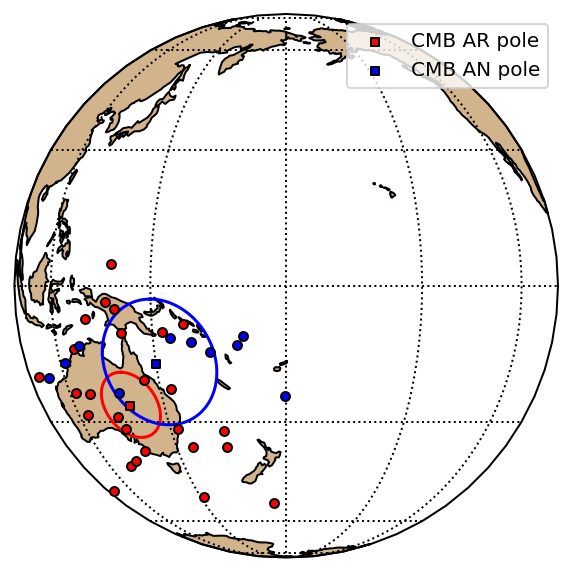

In [87]:
CMB_ax = ipmag.make_orthographic_map(180, 0, figsize=(5,5))
ipmag.plot_vgp(CMB_ax, Adirondack_AR['vgp_lon'], Adirondack_AR['vgp_lat'], color = 'r')
ipmag.plot_vgp(CMB_ax, 180+Adirondack_AN['vgp_lon'], -Adirondack_AN['vgp_lat'], color = 'b')

ipmag.plot_pole(CMB_ax, Adirondack_AR_pole_mean['dec'], Adirondack_AR_pole_mean['inc'], Adirondack_AR_pole_mean['alpha95'], 
                marker = 's', color = 'r', label = 'Adirondack AR pole')
ipmag.plot_pole(CMB_ax, 180+Adirondack_AN_pole_mean['dec'], -Adirondack_AN_pole_mean['inc'], Adirondack_AN_pole_mean['alpha95'],
                marker = 's', color = 'b', label = 'Adirondack AN pole')
plt.legend()
plt.show()

In [89]:
ipmag.reversal_test_MM1990(Brown2012a['vgp_lon'], Brown2012a['vgp_lat'])

Results of Watson V test: 

Watson's V:           4.8
Critical value of V:  6.5
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 13.2
Critical angle for M&M1990:   15.3
The McFadden and McElhinny (1990) classification for
this test is: 'C'


# Quebec NE Grenville pmag

- Hargraves 1967
- Hargraves 1974
- Robertson 1979 
- Irving 1974
- Buchan 1983

Great pmag and thermocrhon pair with Morisset 2009 for Allard Lake and Urbain anorthosite

## Hargraves 1967 Allard Lake anorthosite

- the study do find AR and AN residing in same specimens but only AR is recovered
- Hargraves 1959 and Carmichael 1964 already found that the magnetite and ilmenite (which I think is hem-ilmenite) have opposite magnetic polarities with the E and down direction in magnetite
- together with work of Hargraves and Carmichael's, this is an excellend case to demonstrate that AR is hematite in hemo-ilmenite and is AR becase they rotated from AN upon cooling
- will use the VGPs provided in the table in the paper

- this location has recent and direct U-Pb and Ar ages defining a ~925 Ma cooling age for around 500 C

In [93]:
Hargraves1967a = pd.read_csv('../data/pmag_compilation/Hargraves1967a.csv')
Hargraves1967a = vgp_calc(Hargraves1967a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Hargraves1967a

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples  lat  lon  \
0           Lac Tio    244.6    -80.1          5.5             10   51  -63   
1  Lac Allard-McRae    326.9    -83.8          9.4             10   51  -63   
2            Grader    295.7    -77.2         10.1             10   51  -63   
3          Puyjalon    311.0    -70.0         10.1             21   51  -63   

   dir_k    vgp_lat     vgp_lon dir_comp_name  paleolatitude        plon  \
0   78.9 -55.355094  148.578665            AR     -70.758159  148.578665   
1   27.5 -40.353094  125.751349            AR     -77.741889  125.751349   
2   23.6 -36.486292  144.621893            AR     -65.563482  144.621893   
3   10.8 -22.663693  145.772471            AR     -53.947611  145.772471   

        plat  
0 -55.355094  
1 -40.353094  
2 -36.486292  
3 -22.663693

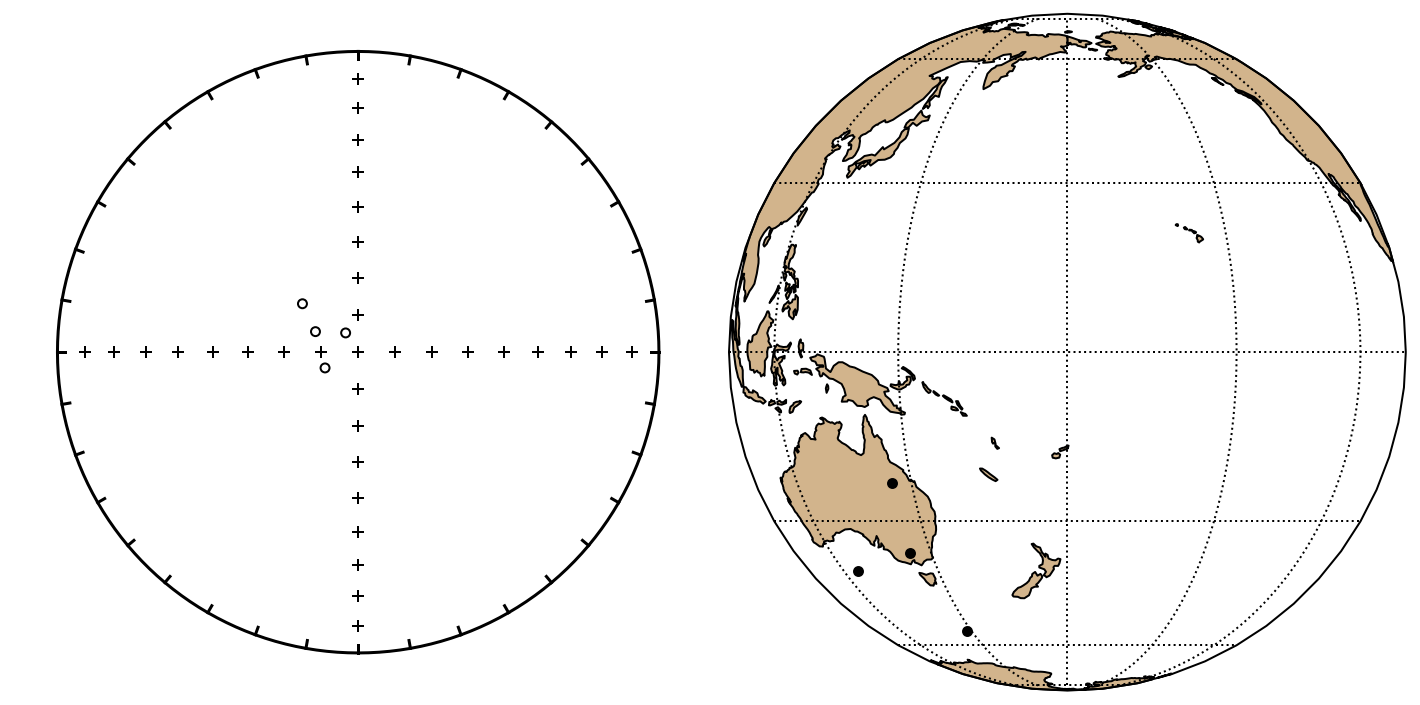

In [94]:
plot_dir_pole(Hargraves1967a['dir_dec'], Hargraves1967a['dir_inc'],
              Hargraves1967a['plat'], Hargraves1967a['plon'])

## Hargraves 1974 St Urbain anorthosite
- only AF cleaning was used and the data is a bit scattered, but overall we can see AR and An components
- need to combine site 93, 92, 99, 90 with Robertson's 1, 11, 12 and 13
- need to filter out the huge a95 data; authors choose to use sites 84, 85, 93, 94, 95 to calculate mean

In [117]:
Hargraves1974a = pd.read_csv('../data/pmag_compilation/Hargraves1974a.csv')
Hargraves1974a = Hargraves1974a.drop([2,3,10,11,12,13]).reset_index(drop=1)
Hargraves1974a = vgp_calc(Hargraves1974a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Hargraves1974a

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples   lat    lon  dir_k  \
0    84    120.2     67.3          4.7              4  47.5 -70.33  260.7   
1    85    142.8     43.4          4.3              4  47.5 -70.33  459.0   
2    92    325.8    -68.2         35.3              4  47.5 -70.33   13.2   
3    93    131.4     52.2         10.3              4  47.5 -70.33   80.1   
4    94    113.8     65.0         19.6              4  47.5 -70.33   23.0   
5    95    132.6     52.6         19.8              5  47.5 -70.33   15.9   
6    96    109.4     23.1         11.8              4  47.5 -70.33   61.1   
7    97     80.2     27.0         23.0              4  47.5 -70.33   16.9   

     vgp_lat     vgp_lon dir_comp_name  paleolatitude        plon       plat  
0  20.329311  325.927690            AN      50.083537  145.927690 -20.329311  
1  -9.865530  323.365850            AN      25.306025  143.365850   9.865530  
2 -13.102204  130.800921            AR     -51.342186  130.800921 -13.102204  
3   1.371199  328.768736            AN      32.805671  148.768736  -1.371199  
4  20.685543  331.508921            AN      46.996928  151.508921 -20.685543  
5   1.192586  327.708338            AN      33.183597  147.708338  -1.192586  
6  -3.766461  357.259181            AN      12.038999  177.259181   3.766461  
7  17.064576   16.961127            AN      14.292786  196.961127 -17.064576

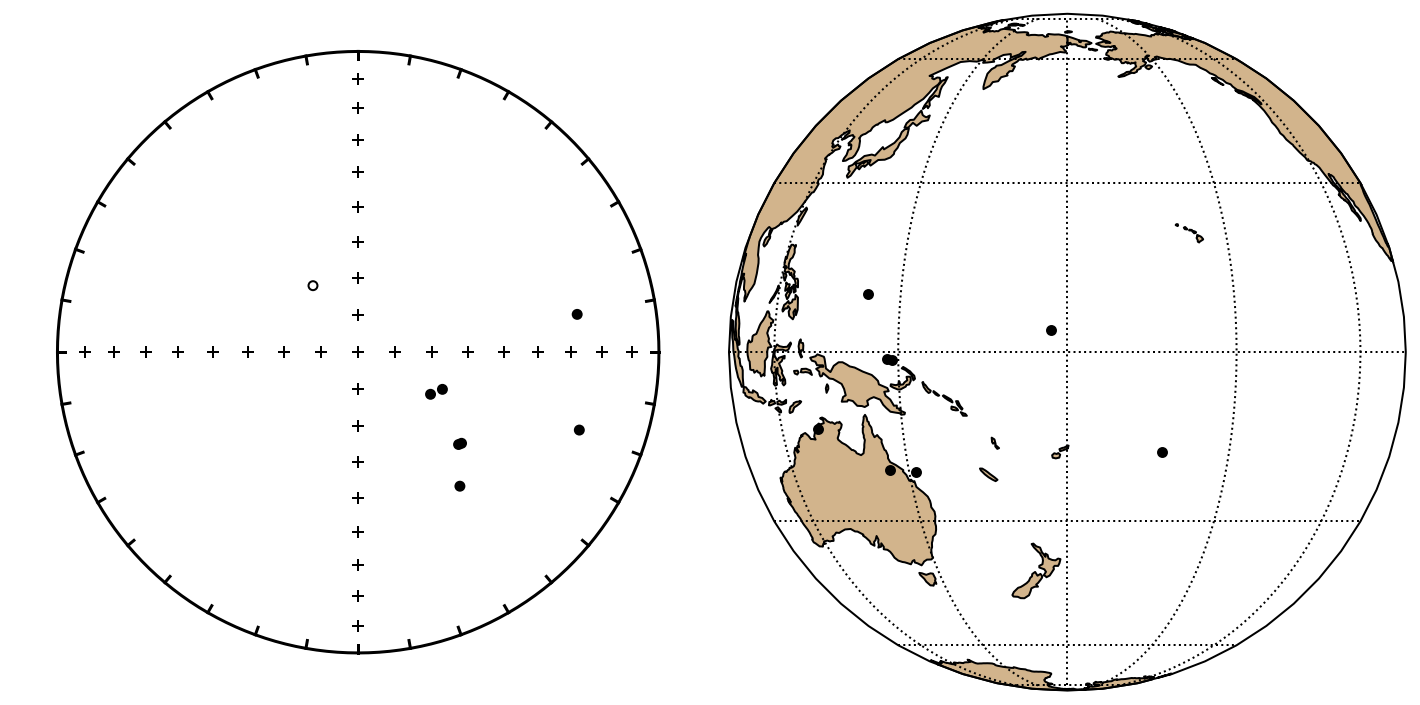

In [118]:
plot_dir_pole(Hargraves1974a['dir_dec'], Hargraves1974a['dir_inc'],
              Hargraves1974a['plat'], Hargraves1974a['plon'])

## Robertson 1979 St. Urbain anorthosite

- classic hemo-ilmenite anorthosite with AR and AN remanence
- shock impact around 360 Ma only overprinted limited unblocking temperature and Grenville TRM and TCRM survived
- site location approximated from map
- need to be combined with Roy 1979 study

In [163]:
Robertson1979a = pd.read_csv('../data/pmag_compilation/Robertson1979a.csv')
Robertson1979a = vgp_calc(Robertson1979a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Robertson1979a

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples   lat    lon  dir_k  \
0    1      134       49            5              7  47.5 -70.33    138   
1    3       98        8            4             13  47.5 -70.33    101   
2    8      107       39            5             13  47.5 -70.33     71   
3    9      133       65            7              6  47.5 -70.33     91   
4   10      127       39           11              9  47.5 -70.33     24   
5   11      295      -62            9             15  47.5 -70.33     18   
6   13      120       49           16              5  47.5 -70.33     24   
7  14a      126       23           10             10  47.5 -70.33     24   
8   15      142       50            6              9  47.5 -70.33     71   
9   16      116       53            4              9  47.5 -70.33    175   

     vgp_lat     vgp_lon dir_comp_name  paleolatitude        plon       plat  
0  -2.247179  328.281062            AN      29.906833  148.281062   2.247179  
1  -2.413517   11.051944            AN       4.019591  191.051944   2.413517  
2   5.371441  352.582620            AN      22.042632  172.582620  -5.371441  
3  12.998984  320.462430            AN      46.996928  140.462430 -12.998984  
4  -5.748602  337.743342            AN      22.042632  157.743342   5.748602  
5 -17.281975  153.415599            AR     -43.239577  153.415599 -17.281975  
6   4.288957  338.504493            AN      29.906833  158.504493  -4.288957  
7 -13.614093  344.185021            AN      11.982503  164.185021  13.614093  
8  -4.584613  321.714831            AN      30.789733  141.714831   4.584613  
9   9.256393  339.029207            AN      33.565165  159.029207  -9.256393

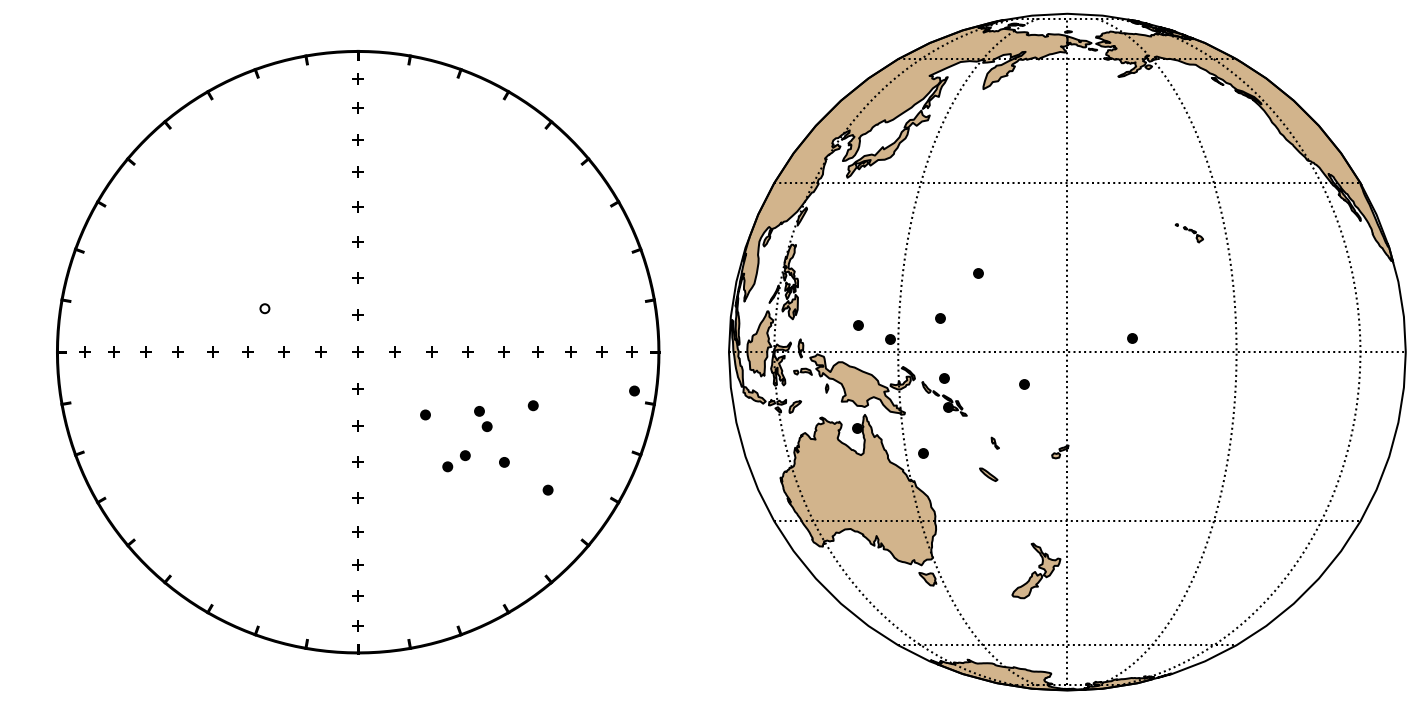

In [164]:
plot_dir_pole(Robertson1979a['dir_dec'], Robertson1979a['dir_inc'],
              Robertson1979a['plat'], Robertson1979a['plon'])

## St. Urbain anorthosite

In [172]:
SUA = pd.concat([Hargraves1974a, Robertson1979a])
SUA = SUA[SUA['dir_alpha95'] <=15].reset_index(drop=1)
SUA_pole_mean = ipmag.fisher_mean(SUA['plon'], SUA['plat'])
SUA_pole_mean

{'dec': 157.16248279981576,
 'inc': -1.9165425196963706,
 'n': 13,
 'r': 12.378809438598848,
 'k': 19.31774361305959,
 'alpha95': 9.677344906195993,
 'csd': 18.429214292695164}

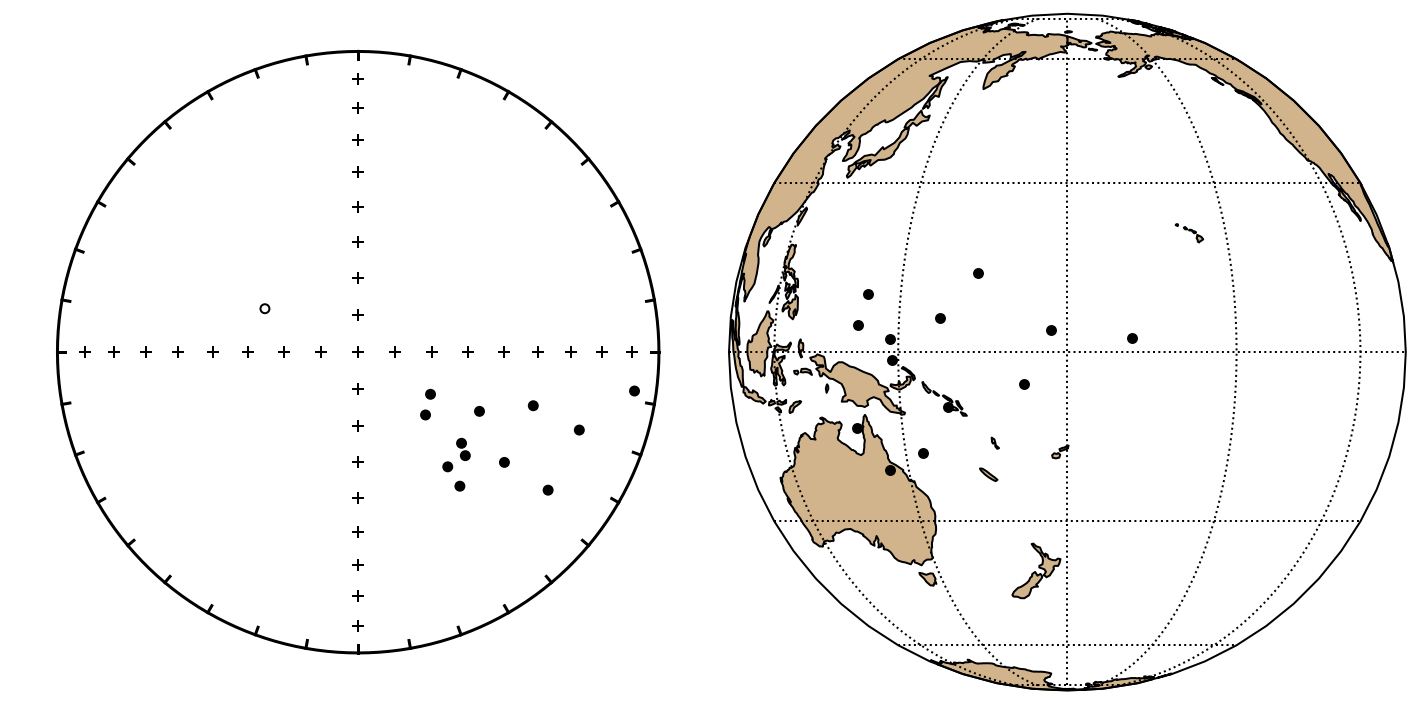

In [162]:
plot_dir_pole(SUA['dir_dec'], SUA['dir_inc'],
              SUA['plat'], SUA['plon'])

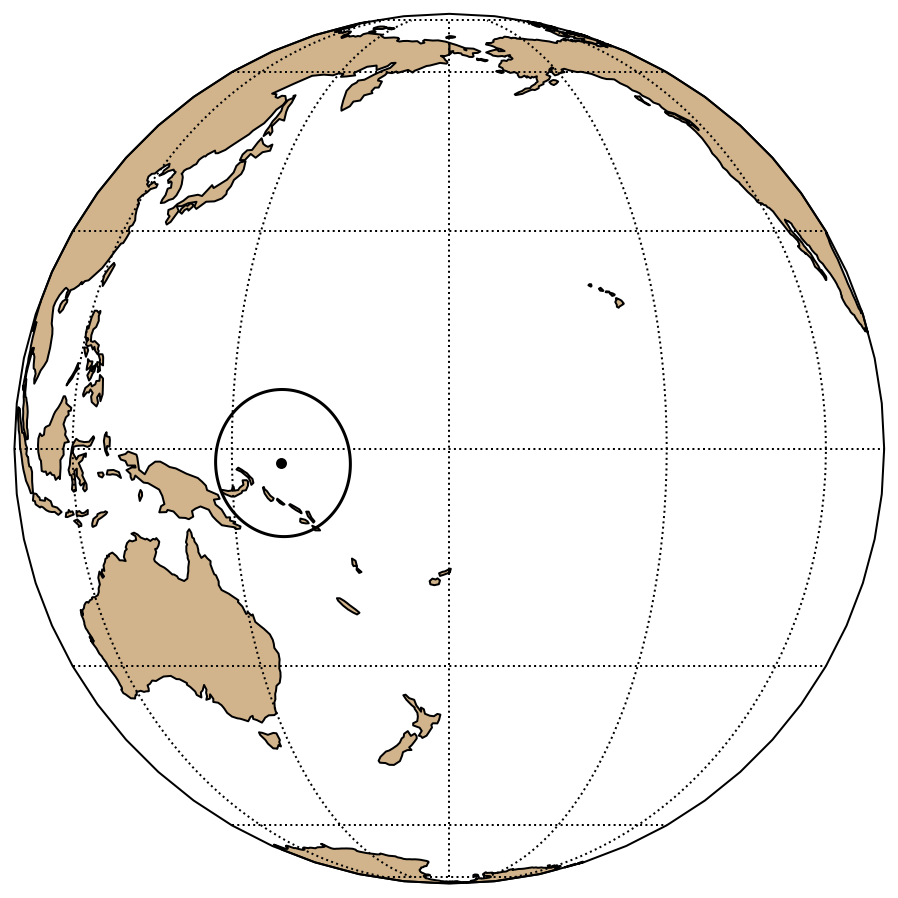

In [171]:
SUA_ax = ipmag.make_orthographic_map(180, 0)
ipmag.plot_vgp(SUA_ax, SUA['plat'], SUA['plon'])
ipmag.plot_pole(SUA_ax, SUA_pole_mean['dec'], SUA_pole_mean['inc'], SUA_pole_mean['alpha95'], 's')

## Irving 1974 Morin Complex

- both AR and AN components were recovered
- petro image show hemo-ilmenite exsolution
- the location is estimated, calculated pole need to compared with that reported in the text

In [177]:
Irving1974b = pd.read_csv('../data/pmag_compilation/Irving1974b.csv')
Irving1974b = Irving1974b.drop([19]).reset_index(drop=1)
Irving1974a = vgp_calc(Irving1974b, 'lon', 'lat', 'dir_dec', 'dir_inc')
Irving1974b

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples  lat    lon  dir_r  \
0     31      277      -76          4.0              4   46 -74.25   3.99   
1     32      289      -69          6.3              5   46 -74.25   4.96   
2     33      279      -77         10.8              5   46 -74.25   4.88   
3     34      245      -84         10.7              4   46 -74.25   3.93   
4     35      311      -69          6.3              5   46 -74.25   4.96   
5     36      229      -84          9.4              5   46 -74.25   4.91   
6     37      280      -76          3.1              5   46 -74.25   4.99   
7     38      293      -70          5.4              5   46 -74.25   4.97   
8     39      271      -66          9.4              5   46 -74.25   4.91   
9     40      234      -70          4.4              5   46 -74.25   4.98   
10    41      315      -83         14.7              5   46 -74.25   4.78   
11    42      280      -68          4.4              5   46 -74.25   4.98   
12    43      280      -64          8.9              5   46 -74.25   4.92   
13    44      309      -61          5.4              5   46 -74.25   4.97   
14    45      308      -73          8.3              5   46 -74.25   4.93   
15    53      213      -51          9.9              5   46 -74.25   4.90   
16    54      233      -81         10.8              5   46 -74.25   4.88   
17    55      268      -69          6.3              5   46 -74.25   4.96   
18    56      132      -82          5.4              5   46 -74.25   4.97   
19    58      142      -76         14.3              5   46 -74.25   4.79   
20    59      212      -75          7.0              5   46 -74.25   4.95   
21    60      265      -76          6.3              5   46 -74.25   4.96   
22    74      191      -67         13.4              4   46 -74.25   3.89   
23    31      120       46         27.1              6   46 -74.25   4.88   
24    32       93       40         17.2              9   46 -74.25   7.91   
25    33      110       14         17.1              3   46 -74.25   2.91   
26    34      138       41         31.3              2   46 -74.25   1.90   
27    35      128       10         19.0              9   46 -74.25   7.67   
28    36      113       27         23.1              8   46 -74.25   6.47   
29    37      114       30         12.3              8   46 -74.25   7.57   
30    39       61       56         18.3              8   46 -74.25   7.04   
31    40      123       53         14.0              2   46 -74.25   1.98   
32    41       21       51         21.8              9   46 -74.25   7.26   
33    54      106       45          9.4              8   46 -74.25   7.75   
34    55      122       37         28.6              3   46 -74.25   2.75   
35    56      112       28         14.7              6   46 -74.25   5.67   

    dir_k    vgp_lat     vgp_lon dir_comp_name  paleolatitude        plon  \
0     300 -37.298260  139.584348            AR     -63.496586  139.584348   
1     100 -25.649083  145.446663            AR     -52.485539  145.446663   
2      33 -37.410947  137.167578            AR     -65.215512  137.167578   
3      43 -49.848936  122.556477            AR     -78.128781  122.556477   
4     100 -17.040871  134.480711            AR     -52.485539  134.480711   
5      44 -52.911569  120.668696            AR     -78.128781  120.668696   
6     400 -36.150850  138.724090            AR     -63.496586  138.724090   
7     133 -24.950250  142.441209            AR     -53.947611  142.441209   
8      44 -31.948740  157.343003            AR     -48.316298  157.343003   
9     200 -55.272607  162.448173            AR     -53.947611  162.448173   
10     18 -35.552013  117.712486            AR     -76.202942  117.712486   
11    200 -28.926759  150.756569            AR     -51.059971  150.756569   
12     50 -25.511860  155.386956            AR     -45.711564  155.386956   
13    133  -9.044199  141.505794            AR     -42.051214  141.505794   

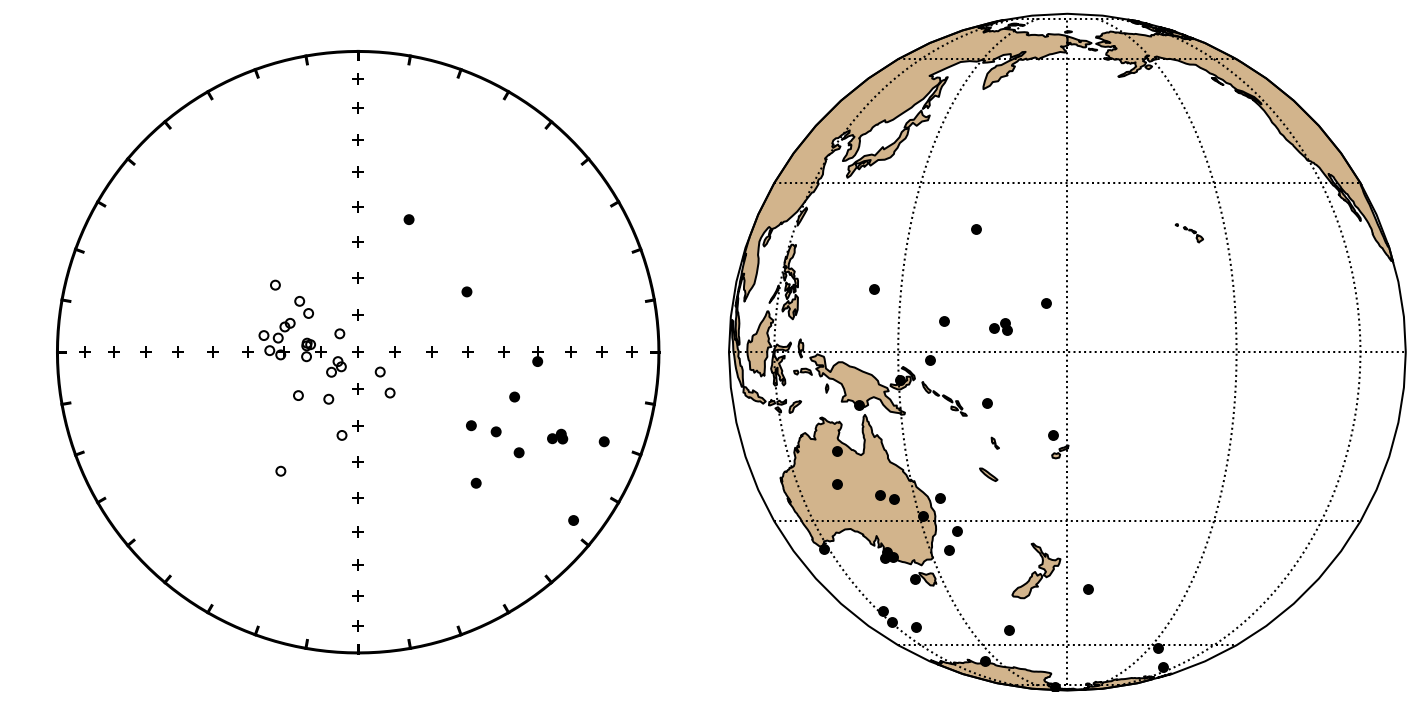

In [178]:
plot_dir_pole(Irving1974b['dir_dec'], Irving1974b['dir_inc'],
              Irving1974b['plat'], Irving1974b['plon'])

## Buchan 1983 Lac St. Jean anorthosite

- although they call the AN "reversed component" (which I like) we will continue our convention here in this compilation tha these are the AN component for us
- the AN and AR component are not exactly antipodal - again this could be attributed to the anisotropy associated with hematite
- location of sites estimated, need to check poles upon recalculation

In [126]:
Buchan1983a = pd.read_csv('../data/pmag_compilation/Buchan1983a.csv')
Buchan1983a = vgp_calc(Buchan1983a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Buchan1983a

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples    lat    lon  dir_k  \
0      1      103       24          8.1              7  48.33 -70.95    130   
1      2      105       42          4.9              7  48.33 -70.95    156   
2      5      106       42          5.5              7  48.33 -70.95    119   
3      6       92       48          5.9              8  48.33 -70.95     90   
4      7       82       55          4.8              7  48.33 -70.95    161   
5      8      111       32          5.3              7  48.33 -70.95    213   
6     10      111       33          8.1              8  48.33 -70.95    234   
7     11      125       41         12.4              7  48.33 -70.95     99   
8     25      101       70         14.8              6  48.33 -70.95     28   
9     31      110       35          8.6              7  48.33 -70.95     51   
10    32      114       40          9.8              7  48.33 -70.95     62   
11    33      110       43          9.9              8  48.33 -70.95    157   
12    34      109       60         10.6              7  48.33 -70.95     41   
13    35      111       41          4.9              8  48.33 -70.95    151   
14    37      118       47          5.5              7  48.33 -70.95    193   
15    38       90       58          4.7             10  48.33 -70.95    108   
16    39      105       42          3.2              9  48.33 -70.95    257   
17    40      112       48          6.2              8  48.33 -70.95     97   
18    49      107       36          6.6              5  48.33 -70.95    134   
19    53      154       45          6.0              4  48.33 -70.95    234   
20    22      122       57          9.0              6  48.33 -70.95     57   
21     9      281      -66          4.8              6  48.33 -70.95    255   
22    12      271      -61          9.8              7  48.33 -70.95     48   
23     3      321      -63         11.1              7  48.33 -70.95     48   
24     4      284      -73          7.3              6  48.33 -70.95     86   
25    14      318      -44         10.5              6  48.33 -70.95     78   
26    15      312      -76          6.2              6  48.33 -70.95    116   
27    17      268      -68          3.7              6  48.33 -70.95    323   
28    26      305      -66         19.7              8  48.33 -70.95     40   
29    29      325      -66         12.1              6  48.33 -70.95    105   
30    42      298      -68          5.8              6  48.33 -70.95    133   
31    45      320      -67         10.2              7  48.33 -70.95     36   
32    36      295      -55          7.3              8  48.33 -70.95     69   

      vgp_lat     vgp_lon dir_comp_name  paleolatitude        plon       plat  
0    0.935896    1.079465            AN      12.550216  181.079465  -0.935896  
1    8.612206  352.027282            AN      24.237370  172.027282  -8.612206  
2    8.021815  351.324975            AN      24.237370  171.324975  -8.021815  
3   20.020688  357.471212            AN      29.043688  177.471212 -20.020688  
4   30.623357  358.522694            AN      35.529645  178.522694 -30.623357  
5   -0.266480  352.063066            AN      17.350615  172.063066   0.266480  
6    0.233905  351.666948            AN      17.988810  171.666948  -0.233905  
7   -2.978833  337.837791            AN      23.491856  157.837791   2.978833  
8   31.955760  331.963782            AN      53.947611  151.963782 -31.955760  
9    1.846213  351.594434            AN      19.295343  171.594434  -1.846213  
10   2.271592  346.515782            AN      22.760476  166.515782  -2.271592  
11   6.290779  348.012095            AN      24.997641  168.012095  -6.290779  
12  18.989579  338.152464            AN      40.893395  158.152464 -18.989579  
13   4.545639  348.243735            AN      23.491856  168.243735  -4.545639  
14   4.468266  340.358265            AN      28.199513  160.358265  -4.468266  
15  27.820181  351.037797            

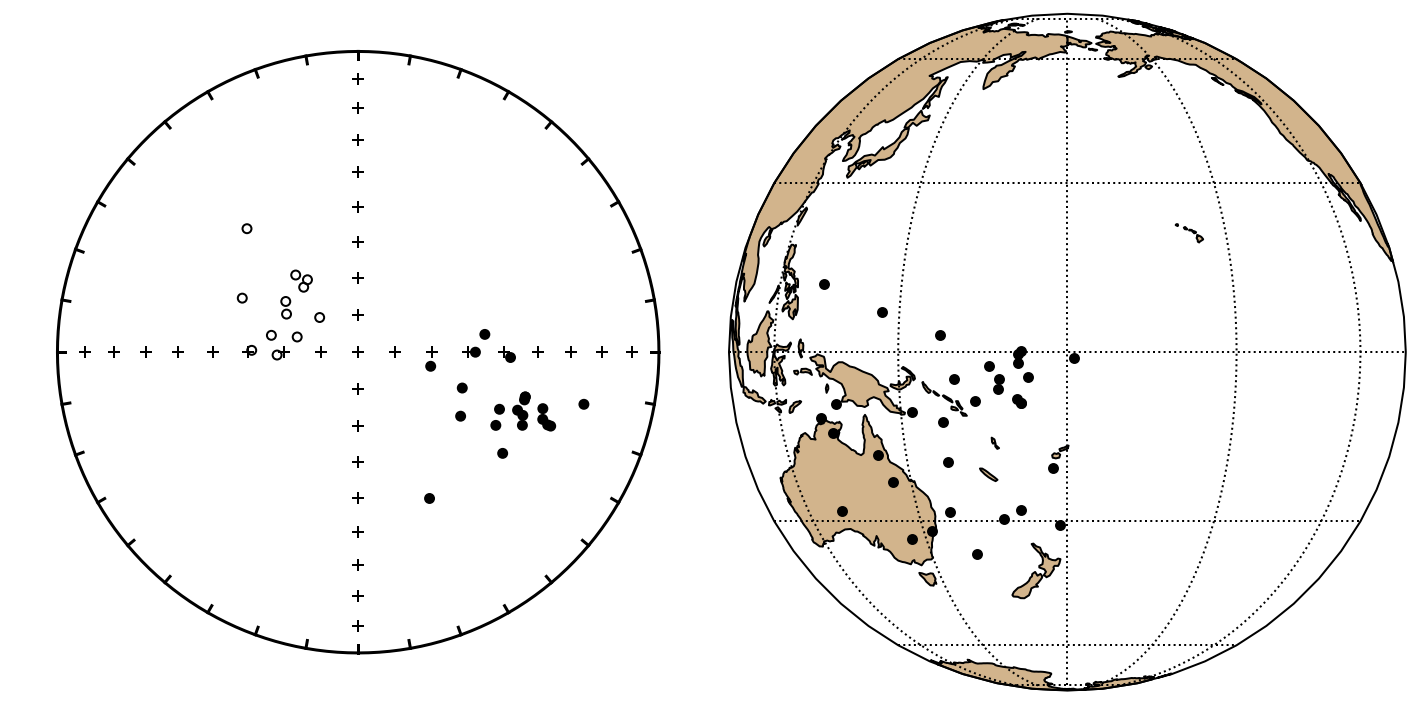

In [127]:
plot_dir_pole(Buchan1983a['dir_dec'], Buchan1983a['dir_inc'],
              Buchan1983a['plat'], Buchan1983a['plon'])

## combine data from Quebec

In [133]:
Quebec_data = pd.concat([Hargraves1967a, Hargraves1974a, Robertson1979a, Irving1974b, Buchan1983a]).reset_index(drop=1)
Quebec_AN = Quebec_data[Quebec_data['dir_inc'] > 0].reset_index(drop=1)
Quebec_AR = Quebec_data[Quebec_data['dir_inc'] < 0].reset_index(drop=1)

Quebec_AN_pole_mean = ipmag.fisher_mean(Quebec_AN['vgp_lon'], Quebec_AN['vgp_lat'])
Quebec_AR_pole_mean = ipmag.fisher_mean(Quebec_AR['vgp_lon'], Quebec_AR['vgp_lat'])

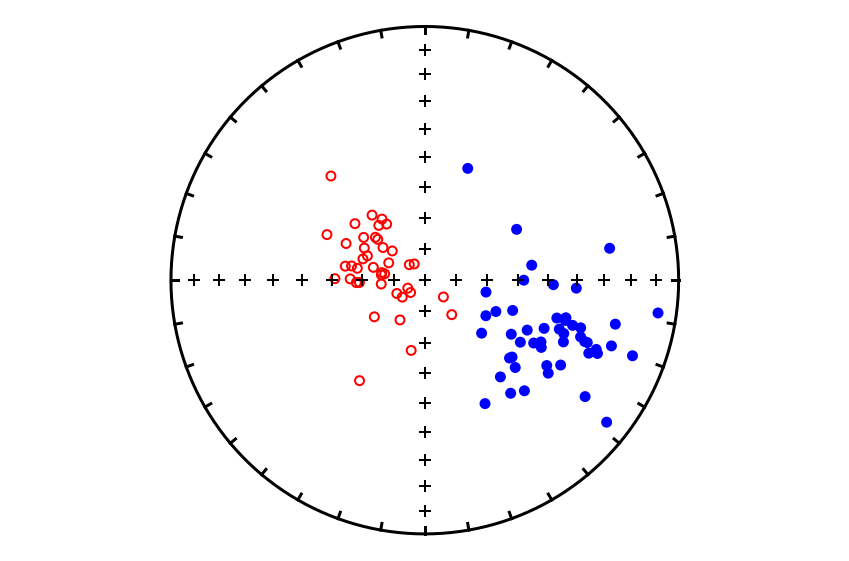

In [134]:
ipmag.plot_net()
ipmag.plot_di(Quebec_AR['dir_dec'], Quebec_AR['dir_inc'], color = 'r')
ipmag.plot_di(Quebec_AN['dir_dec'], Quebec_AN['dir_inc'], color = 'b')

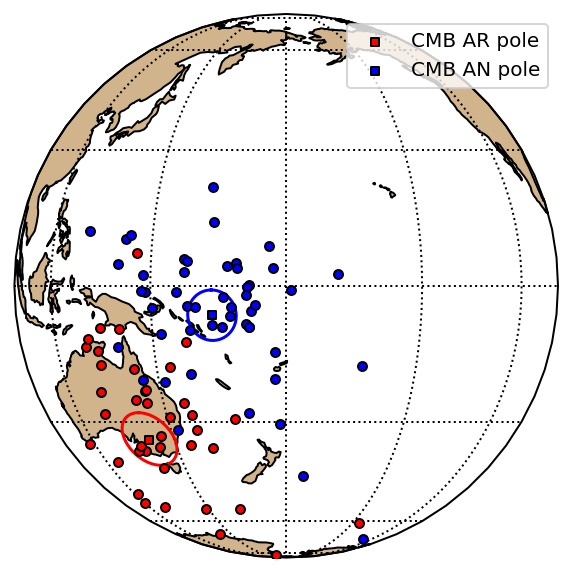

In [135]:
CMB_ax = ipmag.make_orthographic_map(180, 0, figsize=(5,5))
ipmag.plot_vgp(CMB_ax, Quebec_AR['vgp_lon'], Quebec_AR['vgp_lat'], color = 'r')
ipmag.plot_vgp(CMB_ax, 180+Quebec_AN['vgp_lon'], -Quebec_AN['vgp_lat'], color = 'b')

ipmag.plot_pole(CMB_ax, Quebec_AR_pole_mean['dec'], Quebec_AR_pole_mean['inc'], Quebec_AR_pole_mean['alpha95'], 
                marker = 's', color = 'r', label = 'Quebec AR pole')
ipmag.plot_pole(CMB_ax, 180+Quebec_AN_pole_mean['dec'], -Quebec_AN_pole_mean['inc'], Quebec_AN_pole_mean['alpha95'],
                marker = 's', color = 'b', label = 'Quebec AN pole')
plt.legend()
plt.show()

In [88]:
ipmag.reversal_test_MM1990(CMB['vgp_lon'], CMB['vgp_lat'])

Results of Watson V test: 

Watson's V:           31.0
Critical value of V:  6.0
"Fail": Since V is greater than Vcrit, the two means can
be distinguished at the 95% confidence level.

M&M1990 classification:

Angle between data set means: 13.6
Critical angle for M&M1990:   6.0



# Thermally overprinted Paleoproterozoic or Archean province near the GF or the GFTZ

## Ueno 1976 Chibougamau Greenstone Belt

- this is in the Archean Superior Province immediately to the N of the Grenville Front
- Ueno reported that the CH component in some of the sills and complex is amongst the Grenville poles
- if true, this will be a solid, direct evidence, unambiguously support that Grenville two plate model is incorrect, at least there was no large separation
- if the above interpretation is true, the fact that Chibougamau only has magnetite carrier and if they are overprinted thermally, this means we only see AN component here is solid Grenville cooling direction, and AR direction is hemo-exsolution reversal or later hydrothermal hem/mag direction
- location data approximated based on the map, will use to recalculate VGPs

In [137]:
Ueno1976a = pd.read_csv('../data/pmag_compilation/Ueno1976a.csv')
Ueno1976a = vgp_calc(Ueno1976a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Ueno1976a

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples    lat  lon  dir_k  \
0    66      129       55          9.5              5  49.50  -74     43   
1    51      137       45         18.7              4  50.00  -74     14   
2    54      116       72          9.8              5  50.00  -74     41   
3    70       90       54         12.8              5  49.75  -74     24   
4    72      117       23          5.8              4  49.75  -74    144   

     vgp_lat     vgp_lon dir_comp_name  paleolatitude        plon       plat  
0   6.273535  325.513740            CH      35.529645  145.513740  -6.273535  
1  -4.467252  323.723875            CH      26.565051  143.723875   4.467252  
2  29.261235  320.151223            CH      56.982602  140.151223 -29.261235  
3  25.638278  352.027357            CH      34.535397  172.027357 -25.638278  
4  -7.382098  347.507207            CH      11.982503  167.507207   7.382098

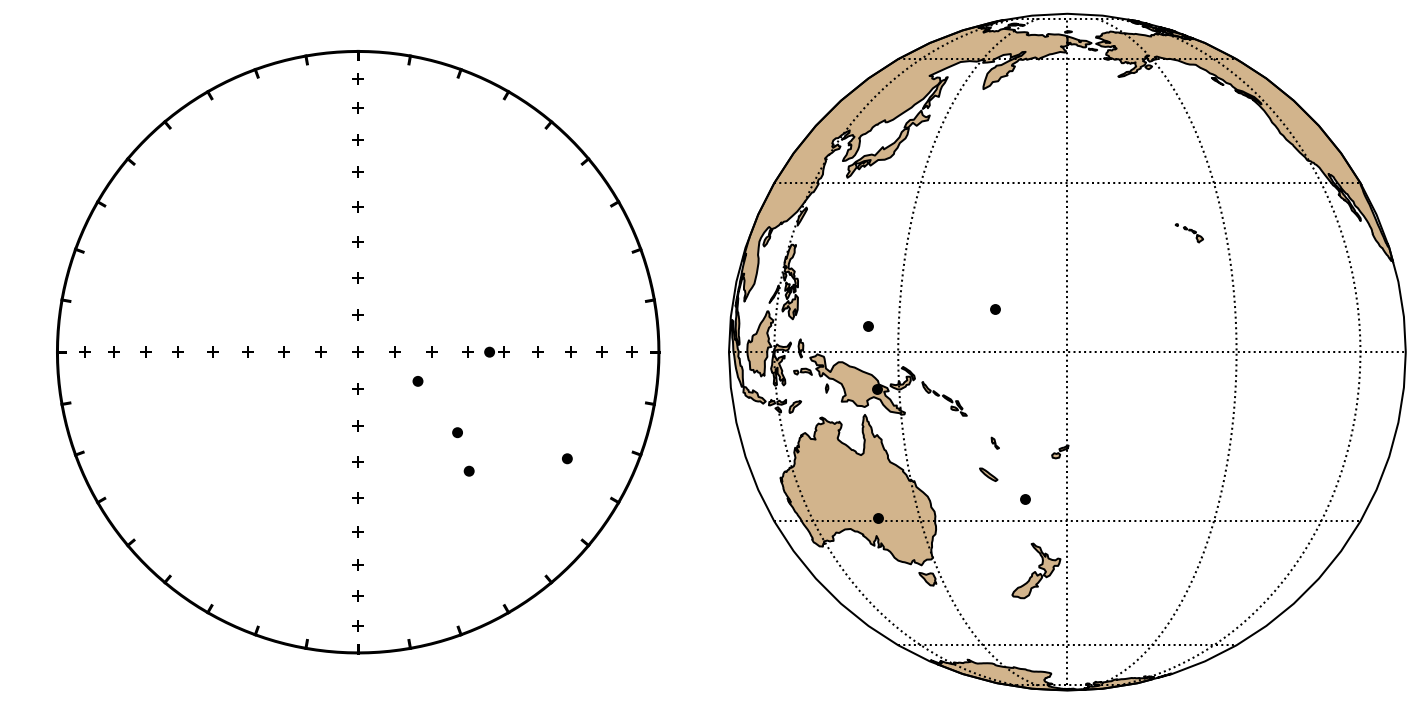

In [138]:
plot_dir_pole(Ueno1976a['dir_dec'], Ueno1976a['dir_inc'],
              Ueno1976a['plat'], Ueno1976a['plon'])

## Stupavsky 1982 French River anorthosite of the GFTZ
- this is potentially thermally overprinted by Grenville but not all
- the low temp A component is consistent with Grenville AN
- the high temp so called B component specific to this case is likely a Paleoproterozoic pole
- that the A component here is carried by magnetite and is AN is same as Ueno 1976 work in the Chibougamau Belt
- But unfortunately there is no thermochron data here, having a biotite Ar will be super helpful

In [142]:
Stupavsky1982a = pd.read_csv('../data/pmag_compilation/Stupavsky1982a.csv')
Stupavsky1982a = vgp_calc(Stupavsky1982a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Stupavsky1982a

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples    lat    lon  dir_k  \
0     1      112       69           12              3  46.25 -80.75    136   
1     2      112       73           11              3  46.25 -80.75    162   
2     3      110       66           14              8  46.25 -80.75    100   
3     4      103       77            3             93  46.25 -80.75   2178   

     vgp_lat     vgp_lon dir_comp_name  paleolatitude        plon       plat  
0  24.533812  317.613932            AN      52.485539  137.613932 -24.533812  
1  28.760435  312.736847            AN      58.555825  132.736847 -28.760435  
2  22.469828  321.801525            AN      48.316298  141.801525 -22.469828  
3  36.200836  309.659654            AN      65.215512  129.659654 -36.200836

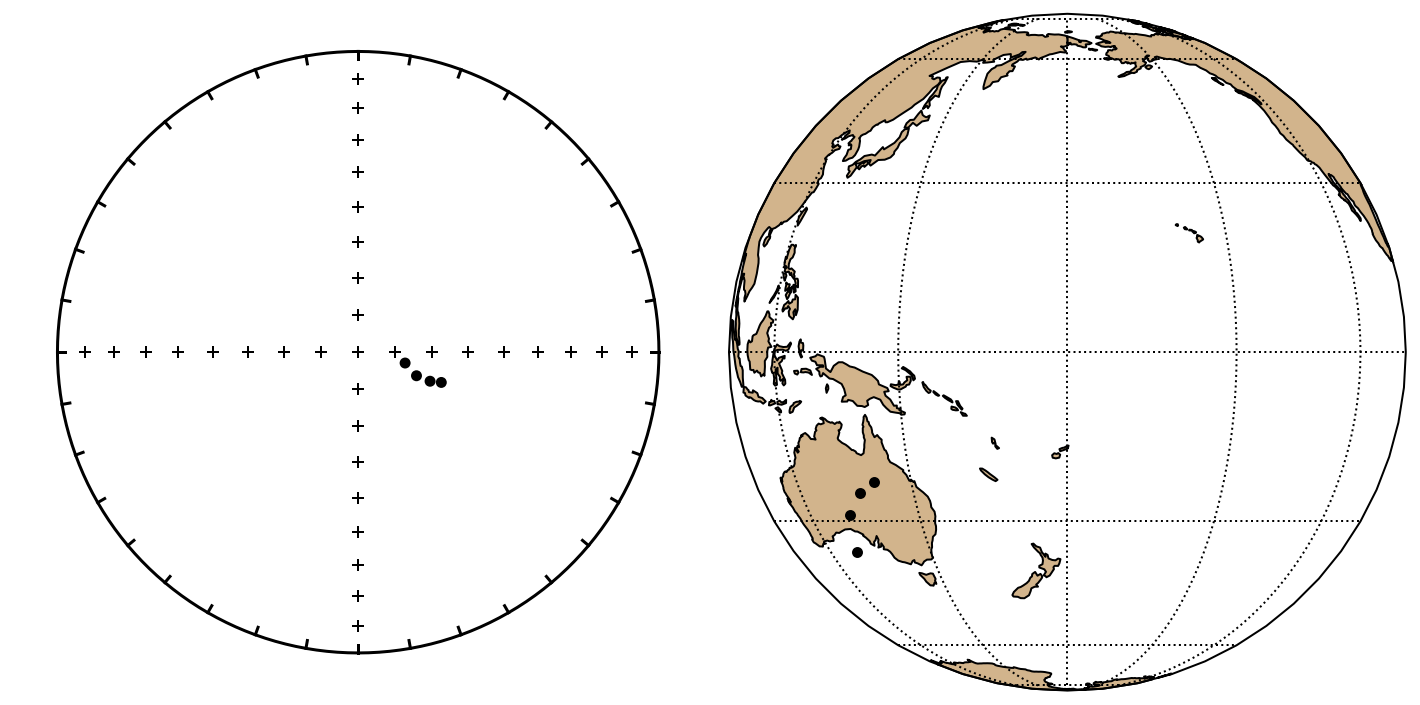

In [143]:
plot_dir_pole(Stupavsky1982a['dir_dec'], Stupavsky1982a['dir_inc'],
              Stupavsky1982a['plat'], Stupavsky1982a['plon'])

## Palmer 1973 River Valley anorthosite, and Fall Lake Complex

- This study has only 30 mT magnetic cleaning thus was actually seeing both soft magnetite and hard hematite blended remanence
- But overall both the pyroxenite and gabbro show AR direction - we can subselect them in the compilation of site level data and illustrate this
- the northern Grenville samples - those that are from St. Charles meta-anorthosite, River Valley anorthosite, and Fall Lake Complex are of AN direction but similar pole position - reflecting differential uplift? or perhaps lack of demag 

- we will isolate out the River Valley anorthosite, and Fall Lake Complex for later section as they are North to the ABT and should be regarded as overprinted rocks

In [146]:
Palmer1973a_NGF = Palmer1973a[Palmer1973a['site'].str.contains('RVA|FLC')].reset_index(drop=1)

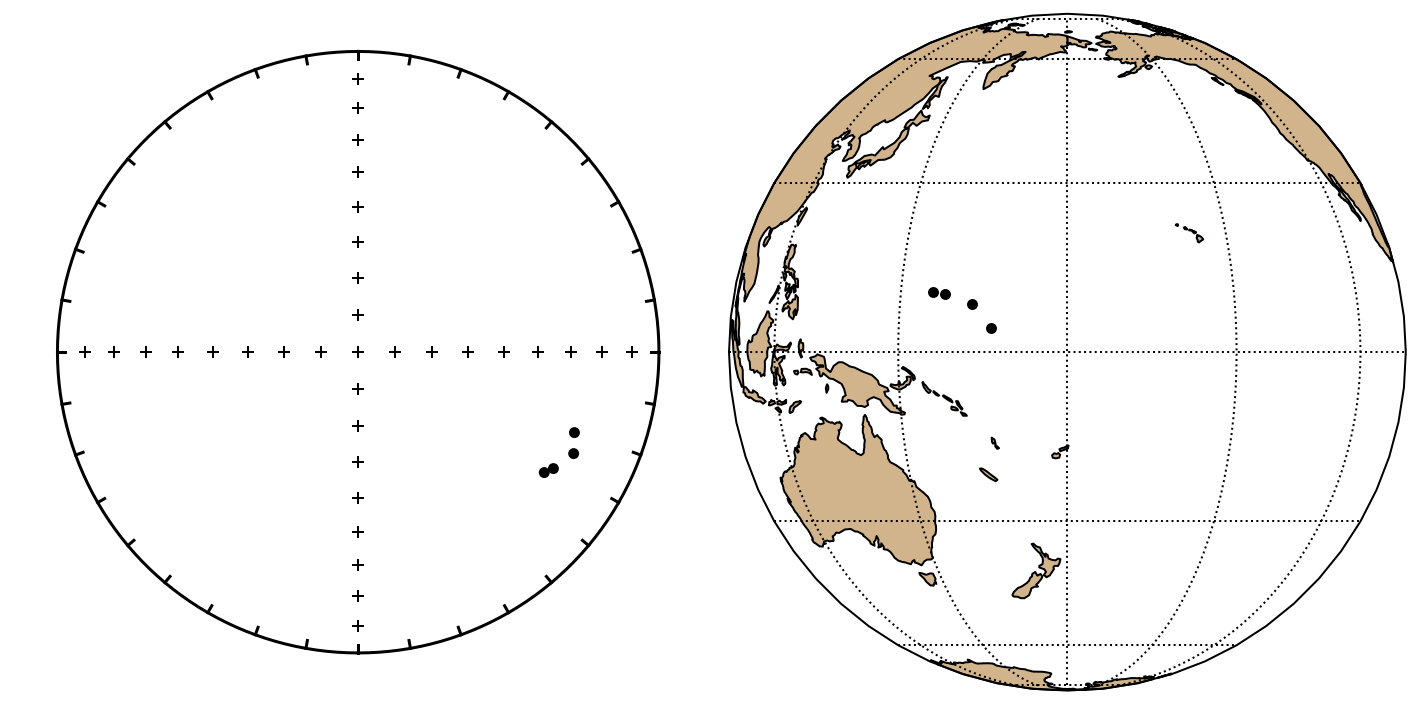

In [147]:
plot_dir_pole(Palmer1973a_NGF['dir_dec'], Palmer1973a_NGF['dir_inc'],
              Palmer1973a_NGF['plat'], Palmer1973a_NGF['plon'])

## Halls 2015a, b River Valley anorthosite and Sudbury dikes and Bustard Islands Gneiss that are metamorphosed 
- this study has unpublihsed unit level data for the River Valley anorthosite
- their directions are consistent with AN

# Labrador Grenville pmag

## Fahrig 1972 Michael Gabbro 
- this pole could be a Grenville pole
- but thermochron data is messy and old for the gabbro
- site location approximated from map

In [149]:
Fahrig1972a = pd.read_csv('../data/pmag_compilation/Fahrig1972a.csv')
Fahrig1972a = vgp_calc(Fahrig1972a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Fahrig1972a

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples   lat  lon  dir_k  \
0      1      136       35          5.1              6  54.5  -59    124   
1      2      139       31          5.2              6  54.5  -59    119   
2      3      140       38          3.6              7  54.5  -59    216   
3      5      134       27          6.3              5  54.5  -59     98   
4      6      131       29          4.3              6  54.5  -59    180   
5      7      134       23          2.9              4  54.5  -59    593   
6     11      138       36          2.6              6  54.5  -59    468   
7     12      146       33          5.5              7  54.5  -59     92   
8     13      140       32          4.2              6  54.5  -59    184   
9     29      141       26          7.5              7  54.5  -59     50   
10    30      143       22          6.0              6  54.5  -59     90   
11    32      131       38          9.2              7  54.5  -59     33   
12    57      142       35          2.7              5  54.5  -59    528   
13    58      131       20          3.2              5  54.5  -59    392   
14    59      140       36          8.2              5  54.5  -59     58   
15    60      138       31          5.9              5  54.5  -59    112   
16    61      143       30          3.5              5  54.5  -59    324   
17    62      138       30          3.2              5  54.5  -59    382   
18    63      136       34          2.3              5  54.5  -59    731   
19    64      139       28          7.1              5  54.5  -59     77   
20    65      138       38          4.9              5  54.5  -59    163   

      vgp_lat     vgp_lon dir_comp_name  paleolatitude        plon       plat  
0   -7.194841  342.364072            AN      19.295343  162.364072   7.194841  
1  -10.689529  340.747989            AN      16.721861  160.747989  10.689529  
2   -6.783781  338.081244            AN      21.337745  158.081244   6.783781  
3  -10.947973  346.234577            AN      14.292786  166.234577  10.947973  
4   -8.609341  348.356376            AN      15.490954  168.356376   8.609341  
5  -13.036973  347.243309            AN      11.982503  167.243309  13.036973  
6   -7.333263  340.353629            AN      19.964629  160.353629   7.333263  
7  -11.915372  333.926979            AN      17.988810  153.926979  11.915372  
8  -10.475717  339.604362            AN      17.350615  159.604362  10.475717  
9  -14.214887  340.102828            AN      13.705006  160.102828  14.214887  
10 -17.060511  339.101159            AN      11.420796  159.101159  17.060511  
11  -3.361301  345.763899            AN      21.337745  165.763899   3.361301  
12  -9.374179  337.082062            AN      19.295343  157.082062   9.374179  
13 -13.241524  350.711180            AN      10.314105  170.711180  13.241524  
14  -8.055899  338.602501            AN      19.964629  158.602501   8.055899  
15 -10.314741  341.644339            AN      16.721861  161.644339  10.314741  
16 -12.696158  337.348633            AN      16.102114  157.348633  12.696158  
17 -10.884007  341.893587            AN      16.102114  161.893587  10.884007  
18  -7.796322  342.634283            AN      18.636898  162.634283   7.796322  
19 -12.379094  341.475812            AN      14.887976  161.475812  12.379094  
20  -6.069604  339.812694            AN      21.337745  159.812694   6.069604

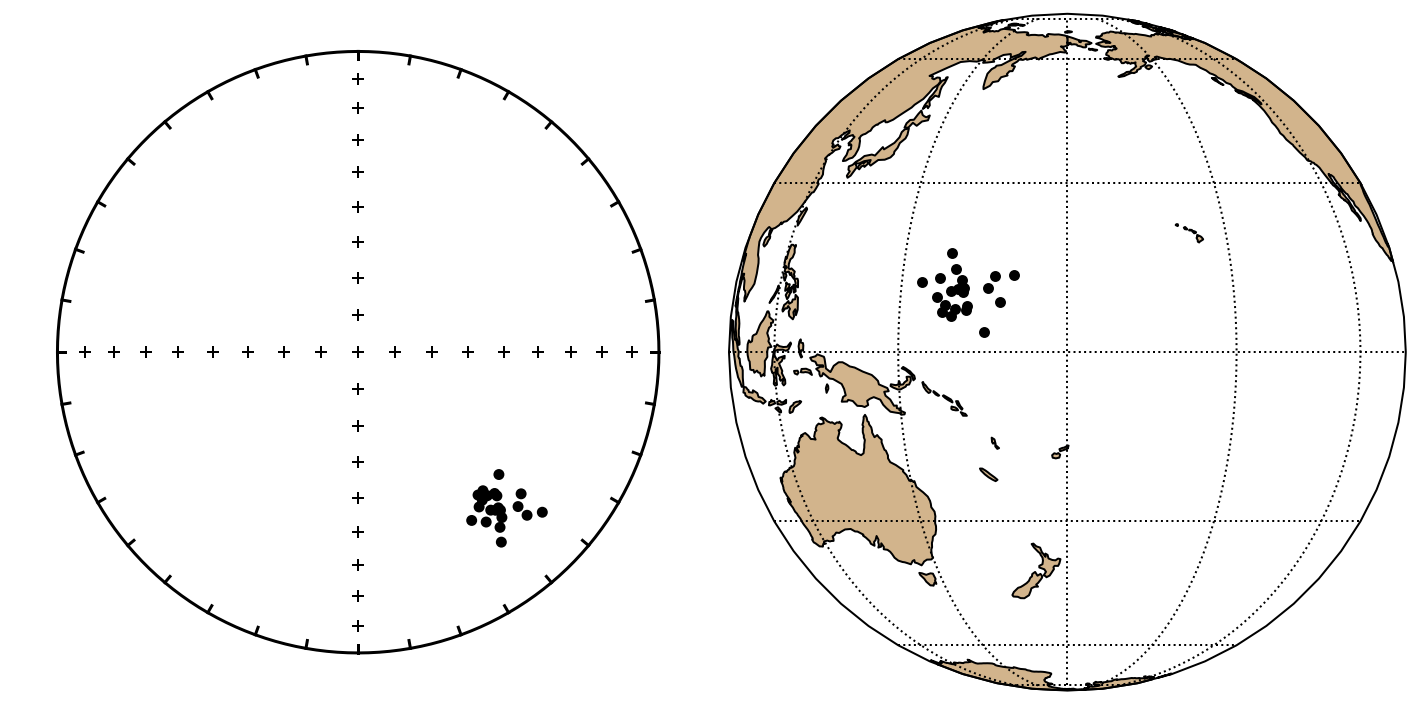

In [150]:
plot_dir_pole(Fahrig1972a['dir_dec'], Fahrig1972a['dir_inc'],
              Fahrig1972a['plat'], Fahrig1972a['plon'])

## Park 1996 Michael Gabbro and other mafic rocks in the region

- recovered similar southerly AN-like direction as Fahrig 1972
- found odd NW and down direction which might be Paleozoic overprint
- site location approximated from map

In [152]:
Park1996a = pd.read_csv('../data/pmag_compilation/Park1996a.csv')
Park1996a = vgp_calc(Park1996a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Park1996a

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples   lat  lon  dir_k  \
0     1      331      -49            9              9  54.5  -59     36   
1     2      120       54            6             11  54.5  -59     54   
2     3      121       54            6             13  54.5  -59     54   
3     4      133       26            4             33  54.5  -59     39   
4     5      133       26            4             36  54.5  -59     40   
5     6      351       80            3             30  54.5  -59     65   
6     7      352       80            3             35  54.5  -59     69   
7     8      352      -76           14              5  54.5  -59     30   

     vgp_lat     vgp_lon dir_comp_name  paleolatitude        plon       plat  
0   1.968549  145.866110            AR     -29.906833  145.866110   1.968549  
1  12.847092  348.031492            AN      34.535397  168.031492 -12.847092  
2  12.424689  347.306704            AN      34.535397  167.306704 -12.424689  
3 -11.062514  347.384367            AN      13.705006  167.384367  11.062514  
4 -11.062514  347.384367            AN      13.705006  167.384367  11.062514  
5  73.440495  290.482063           NaN      70.574600  110.482063 -73.440495  
6  73.540949  291.597758           NaN      70.574600  111.597758 -73.540949  
7 -28.160357  125.039528            AR     -63.496586  125.039528 -28.160357

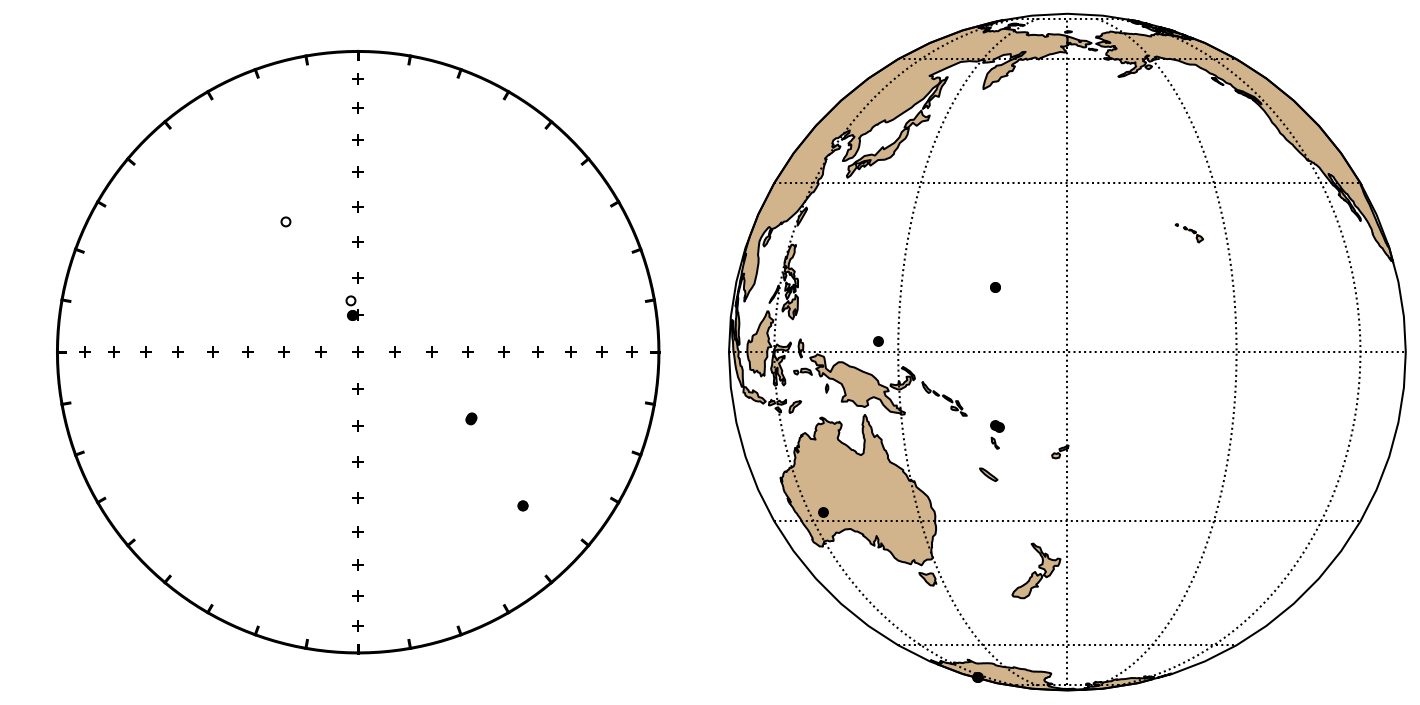

In [153]:
plot_dir_pole(Park1996a['dir_dec'], Park1996a['dir_inc'],
              Park1996a['plat'], Park1996a['plon'])

## Fahrig 1974 Mealy Mountain anorthosite and Shabogamo Gabbro, Labrador

- another Fahrig study in Labrador that indicate Grenville Orogeny extended far to the E end of Canada
- magnetite seems to be the dominant carrier for both AR and AN recorded
- site location approximated from map

In [154]:
Fahrig1974a = pd.read_csv('../data/pmag_compilation/Fahrig1974a.csv')
Fahrig1974a = vgp_calc(Fahrig1974a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Fahrig1974a

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples   lat  lon  dir_k  \
0     1      271      -49          5.6              7  53.0  -59     90   
1     5      320      -35          8.7              7  53.0  -59     37   
2     6      290      -10         10.8              6  53.0  -59     28   
3    10      310       24          6.2              7  53.0  -59     74   
4    16      318      -31          3.9              7  53.0  -59    187   
5    17      290       -2          3.4              6  53.0  -59    277   
6    18      323      -15          2.6              7  53.0  -59    418   
7    19      302      -38          6.6              6  53.0  -59     76   
8    24      287      -37          6.6              5  53.0  -59     91   
9    26      276      -34         10.0              7  53.0  -59     28   
10   33      302       37          9.5              6  53.0  -61     36   
11    1       32       69          8.5              7  53.0  -61     39   
12   2N       90       51          2.7              7  53.0  -61    394   
13   3N       84       70          3.3              9  53.0  -61    206   
14    8       88       49         16.2              5  53.0  -61     15   
15   10      116       81          7.7              7  53.0  -61     47   
16   11       92       62          2.9              7  53.0  -61    330   
17   12       68       66          3.5              7  53.0  -61    228   
18   13       61       68          7.8              6  53.0  -61     54   
19   23      131       67          5.7              8  53.0  -61     75   
20  25N      104       58          5.8              6  53.0  -61     97   
21   26      112       66          8.8              7  53.0  -61     36   
22   27      102       56          8.6              6  53.0  -61     44   
23   34       70       67          2.4              6  53.0  -61    572   
24   35       72       50          3.4              6  53.0  -61    288   
25   40      145       26          7.4              6  53.5  -65     59   
26   41      120       30          5.8              7  53.5  -65     82   
27   42      109       23          2.5              5  53.5  -65    643   
28   43      112        5          5.2              6  53.5  -65    119   
29   44       98       24         10.4              6  53.5  -65     30   
30   45       77       51          3.9              7  53.5  -65    184   
31   46       83       57          3.6              6  53.5  -65    249   
32   47       96       38          3.7              7  53.5  -65    208   
33   48      122       61          6.6              5  53.5  -65     91   
34   49       78       28         16.7              7  53.5  -65     10   
35   50       85        7         10.2              7  53.5  -65     27   
36   51       66       -7         16.7              7  53.5  -65     10   
37   52       75       21          3.8              6  53.5  -65    227   

      vgp_lat     vgp_lon dir_comp_name  paleolatitude        plon       plat  
0  -22.897769  191.193645            AR     -29.906833  191.193645 -22.897769  
1    9.858845  159.008199            AR     -19.295343  159.008199   9.858845  
2    7.752786  191.855923            AR      -5.038369  191.855923   7.752786  
3   33.444964  184.653276            AR      12.550216    4.653276 -33.444964  
4   11.451315  161.832557            AR     -16.721861  161.832557  11.451315  
5   11.061301  194.202938            AR      -1.000305  194.202938  11.061301  
6   21.735677  160.951610            AR      -7.630740  160.951610  21.735677  
7    0.369959  173.179188            AR     -21.337745  173.179188   0.369959  
8   -6.714926  185.299509            AR     -20.645256  185.299509  -6.714926  
9  -11.280447  194.932402            AR     -18.636898  194.932402 -11.280447  
10  35.451725  195.956715            AN      20.645256   15.956715 -35.451725  
11  70.781826   17.625033            AN      52.485539  197.625033 -70.781826  
12  24.808051    8.615446            

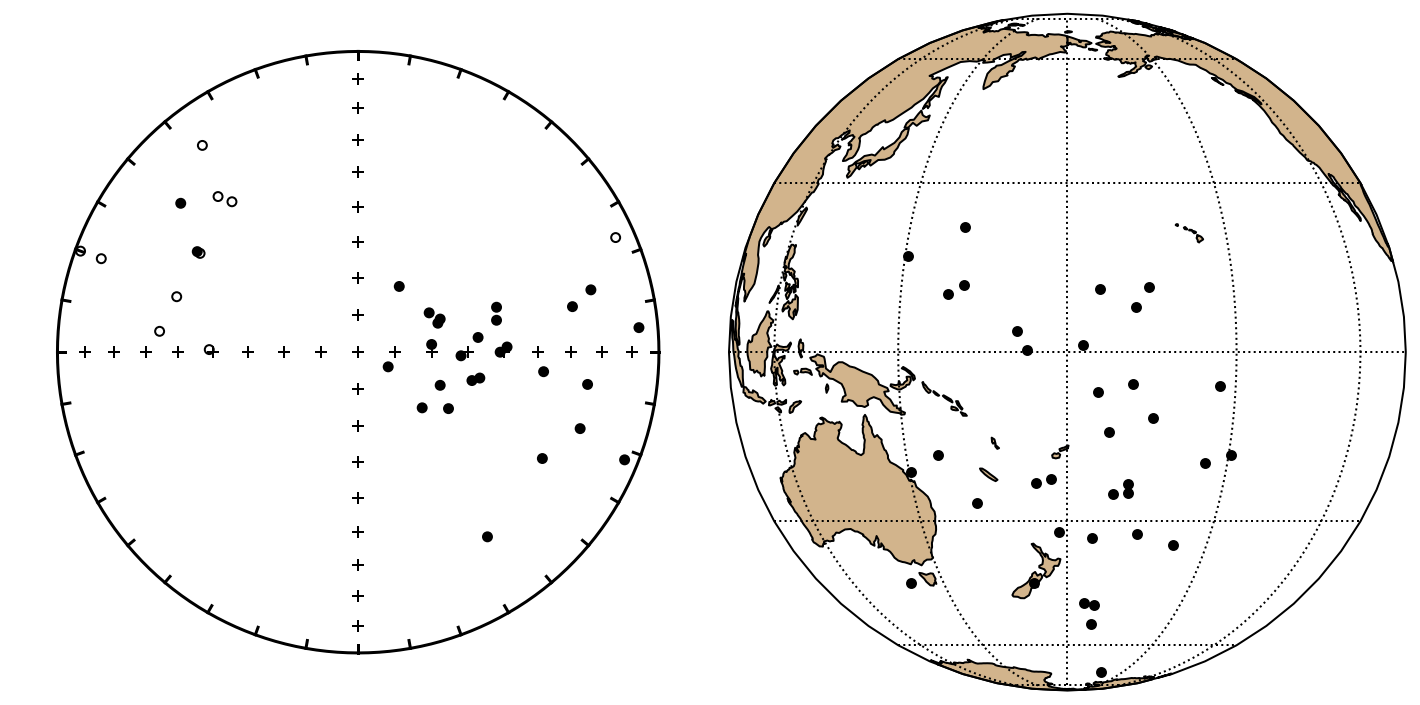

In [155]:
plot_dir_pole(Fahrig1974a['dir_dec'], Fahrig1974a['dir_inc'],
              Fahrig1974a['plat'], Fahrig1974a['plon'])

## Park 1983 Mealy dikes that intrude the Mealy anorthosite

In [186]:
Park1983a = pd.read_csv('../data/pmag_compilation/Park1983a.csv')
Park1983a = vgp_calc(Park1983a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Park1983a = Park1983a.drop([1, 3, 6, 11, 12, 17, 18, 19, ]).reset_index(drop=1)
# Park1983a

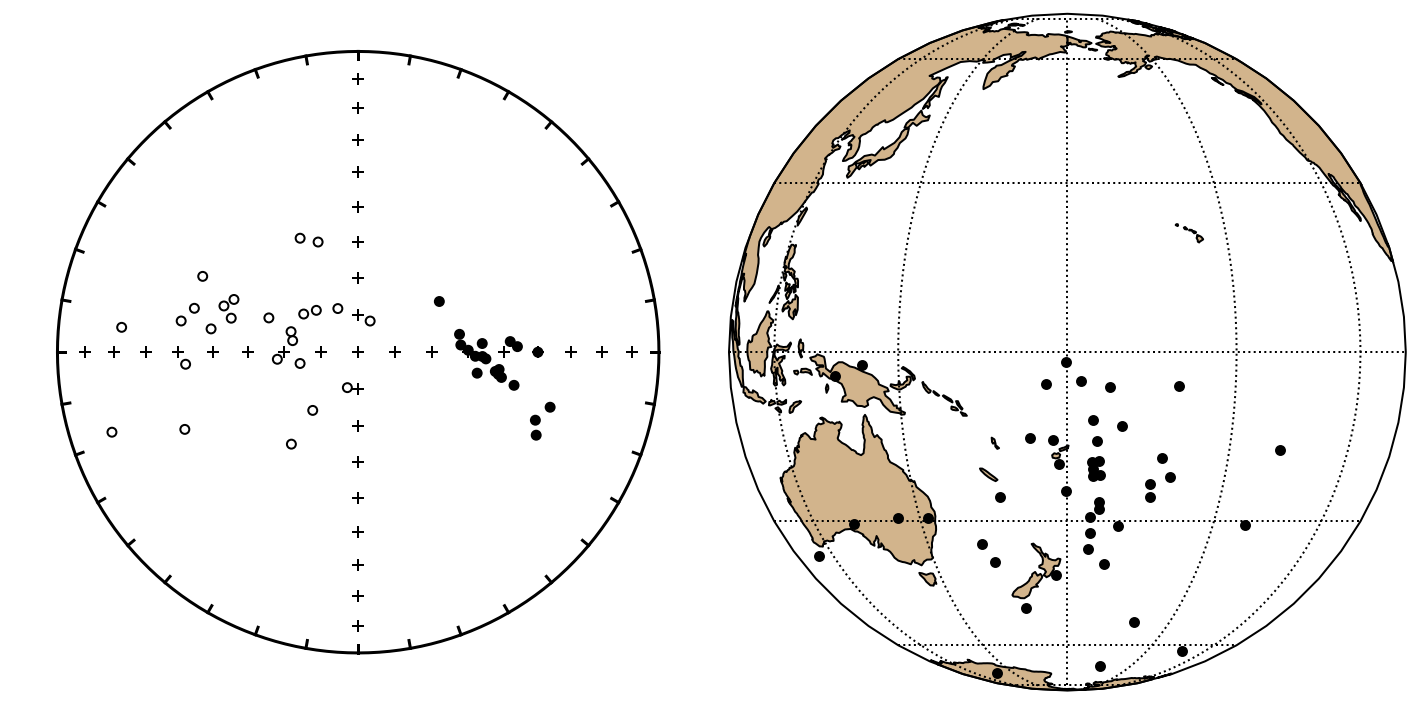

In [187]:
plot_dir_pole(Park1983a['dir_dec'], Park1983a['dir_inc'],
              Park1983a['plat'], Park1983a['plon'])

## Murthy 1976 Indian Head and Steel Mountain anorthosite

- average location provided in the paper, we can use that to recalculate the VGP positions
- AR direction is what we expect to see, but AN is nor soutehrly - this could be a bit hard to explain
- AR is carried by hematite
- authors suggest that the N is from Paleozoic overprint
- we need to decide whether to include poles from New Foundland, far from the CMB and CGB

In [157]:
Murthy1976a = pd.read_csv('../data/pmag_compilation/Murthy1976a.csv')
Murthy1976a = vgp_calc(Murthy1976a, 'lon', 'lat', 'dir_dec', 'dir_inc')
Murthy1976a

site  dir_dec  dir_inc  dir_alpha95  dir_n_samples   lat   lon  dir_k  \
0         1    346.5    -71.0           32              5  48.5 -58.5      6   
1         2    143.0    -14.5           23              5  48.5 -58.5     12   
2         3    142.5     52.0           21              5  48.5 -58.5     13   
3         4    177.0     15.5           11              5  48.5 -58.5     48   
4         5    161.0     30.5           24              4  48.5 -58.5     16   
5         6    165.5     26.5           32              3  48.5 -58.5     16   
6         7    167.0     27.5           18              3  48.5 -58.5     47   
7   8 and 9    178.0     32.5           15              5  48.5 -58.5     27   
8        10    137.0     38.5           19              3  48.5 -58.5     44   
9         2    335.5    -56.0           24              3  48.5 -58.5     28   
10  1 and 3    298.0    -63.5           25              4  48.5 -58.5     14   
11        4    295.5    -39.5           19              4  48.5 -58.5     24   
12        5    301.0    -65.0           15              4  48.5 -58.5     40   
13        6    331.0    -62.5           18              6  48.5 -58.5     14   

      vgp_lat     vgp_lon dir_comp_name  paleolatitude        plon       plat  
0  -14.560413  129.362593            AR     -55.446556  129.362593 -14.560413  
1  -38.379641  351.084803            AR      -7.367964  351.084803 -38.379641  
2   -2.238931  332.373269            AN      32.618057  152.373269   2.238931  
3  -33.543719  305.065994            AN       7.894424  125.065994  33.543719  
4  -22.917020  321.320057            AN      16.410888  141.320057  22.917020  
5  -26.186883  317.207887            AN      13.997993  137.207887  26.186883  
6  -25.859377  315.500004            AN      14.589431  135.500004  25.859377  
7  -23.807407  303.582932            AN      17.668505  123.582932  23.807407  
8   -9.992350  341.551656            AN      21.688604  161.551656   9.992350  
9    2.199431  140.974623            AR     -36.548819  140.974623   2.199431  
10 -18.100719  162.488733            AR     -45.081383  162.488733 -18.100719  
11  -1.241269  178.082336            AR     -22.399899  178.082336  -1.241269  
12 -18.358525  159.522478            AR     -46.996928  159.522478 -18.358525  
13  -5.787719  142.075494            AR     -43.845499  142.075494  -5.787719

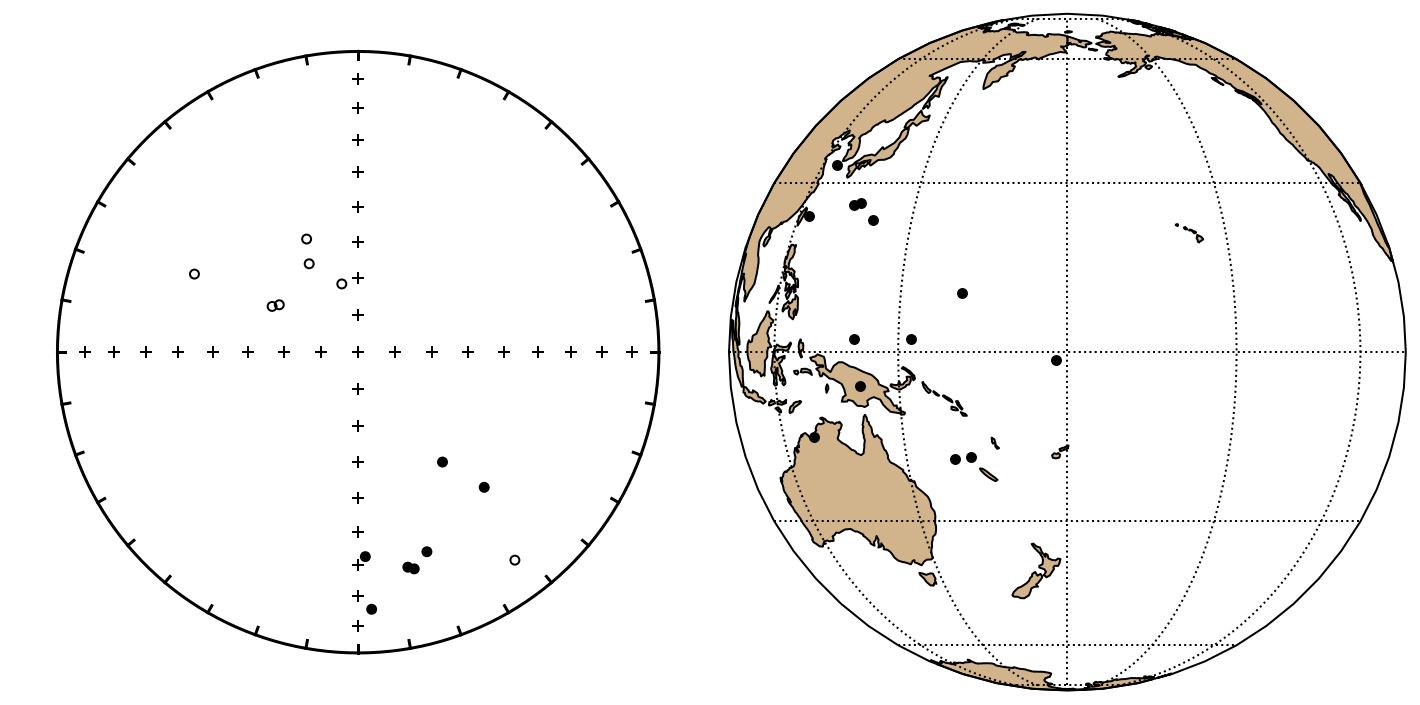

In [158]:
plot_dir_pole(Murthy1976a['dir_dec'], Murthy1976a['dir_inc'],
              Murthy1976a['plat'], Murthy1976a['plon'])